# Poor Children Impact Analysis

This notebook explores an approach to disaggregate official poverty rates into lower geospatial resolution using Relative Wealth Index (RWI) so that it can inform impact analysis.

## Methodology

1. Use children population (ages 0-5 + 5-15)
2. Classify tiles as Rural, Urban (based on SMOD), or Kingston Metropolitan Area (KMA = Kingston + Saint Andrew)
3. Calculate target poor children per classification: Total children in classification × Poverty rate
4. Rank all cells by lowest RWI within each classification
5. Starting from the lowest RWI, accumulate cells and their **children population** until the target is reached


## Configuration

Set the paths and parameters here:


In [1]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Base directory where downloaded files are located
BASE_DIR = "data"

# Country identifier
COUNTRY = "JAM"

# Impact probability data configuration (optional - for calculating potentially impacted poor children)
DATE = "2025-10-27"  # Format: YYYY-MM-DD
FORECAST_TIME = "000000"  # Format: HHMMSS (e.g., "000000" for midnight, "120000" for noon)
WIND_THRESHOLDS = ["34", "50", "64"]  # List of wind thresholds in knots to compare (e.g., ["34", "50", "64"])
STORM = "MELISSA"  # Storm name

# ============================================================================
# POVERTY RATES BY CLASSIFICATION
# ============================================================================

# Moderate poverty rates (%) for children (ages 0-15) by area classification 2022
POVERTY_RATE_RURAL = 34.6460305820465
POVERTY_RATE_URBAN = 22.9166205159144
POVERTY_RATE_KMA = 34.5674892972073  # Kingston Metropolitan Area (Kingston + Saint Andrew)

# SMOD classification threshold (>= 20 = urban, < 20 = rural)
SMOD_URBAN_THRESHOLD = 20.0

# Kingston Metropolitan Area parishes
KMA_PARISHES = ["Kingston", "Saint Andrew"]

print("# Poverty Rates by Classification (for children ages 0-15):")
print(f"  Rural: {POVERTY_RATE_RURAL:.2f}%")
print(f"  Urban: {POVERTY_RATE_URBAN:.2f}%")
print(f"  KMA (Kingston + Saint Andrew): {POVERTY_RATE_KMA:.2f}%")
print(f"\nSMOD Urban Threshold: >= {SMOD_URBAN_THRESHOLD}")
print(f"KMA Parishes: {', '.join(KMA_PARISHES)}")


# Poverty Rates by Classification (for children ages 0-15):
  Rural: 34.65%
  Urban: 22.92%
  KMA (Kingston + Saint Andrew): 34.57%

SMOD Urban Threshold: >= 20.0
KMA Parishes: Kingston, Saint Andrew


## Import Libraries


In [2]:
import os
import math
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        plt.style.use('default')
sns.set_palette("husl")

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# ============================================================================
# VISUALIZATION SAVING SETUP
# ============================================================================
# Set to True to save all visualizations to a folder
SAVE_VISUALIZATIONS = True
VISUALIZATIONS_DIR = "analysis_output/visualizations"

if SAVE_VISUALIZATIONS:
    os.makedirs(VISUALIZATIONS_DIR, exist_ok=True)
    print(f"Visualizations will be saved to: {VISUALIZATIONS_DIR}/")
else:
    print("Visualization saving is disabled (set SAVE_VISUALIZATIONS = True to enable)")

# plt.show() to automatically save meaningful figures before showing
_original_show = plt.show
_figure_counter = {'count': 0}

def _show_with_save(*args, **kwargs):
    """Wrapper around plt.show() that saves meaningful figures automatically"""
    if SAVE_VISUALIZATIONS:
        fig = plt.gcf()
        axes = fig.get_axes()
        
        # Only save if figure has meaningful content (has axes with titles or suptitle)
        filename = None
        
        if axes:
            # Check for suptitle (main title) first
            try:
                if fig._suptitle is not None:
                    suptitle = fig._suptitle.get_text()
                    if suptitle and suptitle.strip():
                        # Create filename from suptitle
                        filename = suptitle.lower().replace(' ', '_').replace('\n', '_')
                        filename = ''.join(c for c in filename if c.isalnum() or c in '_-')
            except:
                pass
            
            # Check for axis titles if no suptitle
            if not filename:
                for ax in axes:
                    try:
                        title = ax.get_title()
                        if title and title.strip():
                            filename = title.lower().replace(' ', '_').replace('\n', '_')
                            filename = ''.join(c for c in filename if c.isalnum() or c in '_-')
                            break
                    except:
                        pass
        
        if filename:
            # Save directly to visualizations directory using the title as filename
            filepath = os.path.join(VISUALIZATIONS_DIR, f"{filename}.png")
            fig.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"  Saved: {filepath}")
    
    return _original_show(*args, **kwargs)

# Replace plt.show with our wrapper
if SAVE_VISUALIZATIONS:
    plt.show = _show_with_save
    print("  Auto-saving enabled: Figures will be saved using their titles")

Visualizations will be saved to: analysis_output/visualizations/
  Auto-saving enabled: Figures will be saved using their titles


## Load Data Files


In [3]:
# Construct file paths
# Base admin boundaries file
admin_base_path = os.path.join(BASE_DIR, "geodb", "aos_views", "admin_views", f"{COUNTRY}_admin1.parquet")

# Base tile file (14-level tiles with population and RWI)
tiles_base_path = os.path.join(BASE_DIR, "geodb", "aos_views", "mercator_views", f"{COUNTRY}_14.parquet")

print(f"Loading data files...")
print(f"  Admin boundaries: {admin_base_path}")
print(f"  Tiles: {tiles_base_path}")

# Load base admin boundaries
if os.path.exists(admin_base_path):
    gdf_admin = gpd.read_parquet(admin_base_path)
    print(f"\nLoaded admin boundaries: {len(gdf_admin)} parishes")
    print(f"   Columns: {list(gdf_admin.columns)}")
else:
    raise FileNotFoundError(f"Admin boundaries file not found: {admin_base_path}")

# Load base tiles with population and RWI
if os.path.exists(tiles_base_path):
    gdf_tiles = gpd.read_parquet(tiles_base_path)
    print(f"\nLoaded tiles: {len(gdf_tiles)} cells")
    print(f"   Columns: {list(gdf_tiles.columns)}")
else:
    raise FileNotFoundError(f"Tiles file not found: {tiles_base_path}")


Loading data files...
  Admin boundaries: data/geodb/aos_views/admin_views/JAM_admin1.parquet
  Tiles: data/geodb/aos_views/mercator_views/JAM_14.parquet

Loaded admin boundaries: 14 parishes
   Columns: ['tile_id', 'school_age_population', 'infant_population', 'built_surface_m2', 'population', 'num_schools', 'num_hcs', 'smod_class', 'rwi', 'name', 'geometry']

Loaded tiles: 2231 cells
   Columns: ['tile_id', 'school_age_population', 'infant_population', 'population', 'built_surface_m2', 'smod_class', 'num_schools', 'num_hcs', 'rwi', 'geometry', 'id']


## Prepare Data for Analysis


In [4]:
# Identify the correct column names
# Try to find RWI column
rwi_column = None
for col in gdf_tiles.columns:
    if col.lower() == 'rwi' or col.lower() == 'relative_wealth_index':
        rwi_column = col
        break

if rwi_column is None:
    rwi_cols = [col for col in gdf_tiles.columns if 'rwi' in col.lower()]
    if rwi_cols:
        rwi_column = rwi_cols[0]

# Try to find children population columns (0-5 and 5-15)
infant_col = None
school_age_col = None
for col in gdf_tiles.columns:
    if 'infant' in col.lower() or '0-5' in col.lower():
        infant_col = col
    if 'school_age' in col.lower() or '5-15' in col.lower():
        school_age_col = col

# Try to find tile_id column
tile_id_column = None
for col in gdf_tiles.columns:
    if col.lower() in ['tile_id', 'tileid', 'id', 'zone_id']:
        tile_id_column = col
        break

print(f"Identified columns:")
print(f"  RWI column: {rwi_column}")
print(f"  Infant population (0-5): {infant_col}")
print(f"  School age population (5-15): {school_age_col}")
print(f"  Tile ID column: {tile_id_column}")

if rwi_column is None:
    print("\nWarning: Could not find RWI column")
    print(f"   Available columns: {list(gdf_tiles.columns)}")
    raise ValueError("Required column (RWI) not found")

if infant_col is None or school_age_col is None:
    print("\nWarning: Could not find children population columns")
    print(f"   Available columns: {list(gdf_tiles.columns)}")
    raise ValueError("Required columns (infant_population and school_age_population) not found")

# Create a working copy of tiles
gdf_work = gdf_tiles.copy()

# Ensure we have the necessary columns with standardized names
gdf_work['rwi'] = gdf_work[rwi_column]
gdf_work['infant_population'] = gdf_work[infant_col].fillna(0)
gdf_work['school_age_population'] = gdf_work[school_age_col].fillna(0)
gdf_work['children_population'] = gdf_work['infant_population'] + gdf_work['school_age_population']

if tile_id_column:
    gdf_work['tile_id'] = gdf_work[tile_id_column]
else:
    gdf_work['tile_id'] = gdf_work.index

# Remove rows with missing RWI or zero children population
gdf_work = gdf_work[gdf_work['rwi'].notna() & (gdf_work['children_population'] > 0)].copy()

print(f"\nPrepared {len(gdf_work)} tiles with valid RWI and children population data")
print(f"  Total children population: {gdf_work['children_population'].sum():,.0f}")
print(f"  - Ages 0-5: {gdf_work['infant_population'].sum():,.0f}")
print(f"  - Ages 5-15: {gdf_work['school_age_population'].sum():,.0f}")


Identified columns:
  RWI column: rwi
  Infant population (0-5): infant_population
  School age population (5-15): school_age_population
  Tile ID column: tile_id

Prepared 2224 tiles with valid RWI and children population data
  Total children population: 845,814
  - Ages 0-5: 217,525
  - Ages 5-15: 628,289


## Spatial Join: Assign Tiles to Parishes and Classify


In [5]:
# Perform spatial join to assign each tile to a parish
# Ensure both GeoDataFrames have the same CRS
if gdf_work.crs != gdf_admin.crs:
    gdf_work = gdf_work.to_crs(gdf_admin.crs)

# Start with a copy of all original tiles - we will assign parishes one by one
# This ensures we never lose any tiles
gdf_tiles_with_admin = gdf_work.copy()
gdf_tiles_with_admin['parish'] = None

print(f"Assigning {len(gdf_tiles_with_admin)} tiles to parishes...")

# For each tile, determine its parish assignment
for idx, tile_row in gdf_tiles_with_admin.iterrows():
    tile_geom = tile_row.geometry
    tile_centroid = tile_geom.centroid
    assigned_parish = None
    
    # Step 1: Check if tile intersects any parish
    intersecting_parishes = []
    for admin_idx, admin_row in gdf_admin.iterrows():
        if tile_geom.intersects(admin_row.geometry):
            intersecting_parishes.append(admin_row['name'])
    
    if len(intersecting_parishes) == 1:
        # Tile intersects exactly one parish - assign to it
        assigned_parish = intersecting_parishes[0]
    elif len(intersecting_parishes) > 1:
        # Tile intersects multiple parishes - use centroid to decide
        centroid_gdf = gpd.GeoDataFrame([{'geometry': tile_centroid}], crs=gdf_admin.crs)
        centroid_join = gpd.sjoin(centroid_gdf, gdf_admin[['name', 'geometry']], how='left', predicate='within')
        
        if len(centroid_join) > 0 and centroid_join['name'].iloc[0] is not None:
            # Centroid falls within one of the intersecting parishes
            assigned_parish = centroid_join['name'].iloc[0]
        else:
            # Centroid doesn't fall within any parish, use nearest
            min_dist = float('inf')
            for admin_idx, admin_row in gdf_admin.iterrows():
                if admin_row['name'] in intersecting_parishes:  # Only check intersecting parishes
                    dist = tile_centroid.distance(admin_row.geometry)
                    if dist < min_dist:
                        min_dist = dist
                        assigned_parish = admin_row['name']
    else:
        # Tile doesn't intersect any parish - assign to nearest parish
        min_dist = float('inf')
        for admin_idx, admin_row in gdf_admin.iterrows():
            dist = tile_centroid.distance(admin_row.geometry)
            if dist < min_dist:
                min_dist = dist
                assigned_parish = admin_row['name']
    
    # Assign the parish
    if assigned_parish:
        gdf_tiles_with_admin.loc[idx, 'parish'] = assigned_parish
    else:
        print(f"Warning: Could not assign parish to tile {idx}")

# Verify all tiles have a parish
final_missing = gdf_tiles_with_admin['parish'].isna().sum()
if final_missing > 0:
    print(f"\nWarning: {final_missing} tiles still missing parish assignment")
    # Last resort: assign remaining tiles to nearest parish
    for idx in gdf_tiles_with_admin[gdf_tiles_with_admin['parish'].isna()].index:
        tile_centroid = gdf_tiles_with_admin.loc[idx, 'geometry'].centroid
        min_dist = float('inf')
        nearest_parish = None
        for admin_idx, admin_row in gdf_admin.iterrows():
            dist = tile_centroid.distance(admin_row.geometry)
            if dist < min_dist:
                min_dist = dist
                nearest_parish = admin_row['name']
        if nearest_parish:
            gdf_tiles_with_admin.loc[idx, 'parish'] = nearest_parish

# Final verification
final_missing = gdf_tiles_with_admin['parish'].isna().sum()
if final_missing > 0:
    print(f"\nError: {final_missing} tiles still missing parish assignment after all attempts")
else:
    print(f"\n✓ All {len(gdf_tiles_with_admin)} tiles successfully assigned to parishes")

# Ensure required columns exist
if 'rwi' not in gdf_tiles_with_admin.columns:
    rwi_cols = [col for col in gdf_tiles_with_admin.columns if 'rwi' in col.lower()]
    if rwi_cols:
        gdf_tiles_with_admin['rwi'] = gdf_tiles_with_admin[rwi_cols[0]]
    else:
        raise ValueError("RWI column not found after spatial join")

print(f"\nAssigned {len(gdf_tiles_with_admin)} tiles to parishes")
print(f"Parishes found:")
print(gdf_tiles_with_admin['parish'].value_counts().sort_index())


Assigning 2224 tiles to parishes...


✓ All 2224 tiles successfully assigned to parishes

Assigned 2224 tiles to parishes
Parishes found:
parish
Clarendon          240
Hanover            100
Kingston             4
Manchester         159
Portland           171
Saint Andrew        94
Saint Ann          240
Saint Catherine    239
Saint Elizabeth    235
Saint James        119
Saint Mary         131
Saint Thomas       157
Trelawny           170
Westmoreland       165
Name: count, dtype: int64


  Saved: analysis_output/visualizations/assigned_tiles_per_parish_2224_tiles_assigned_to_14_parishes.png


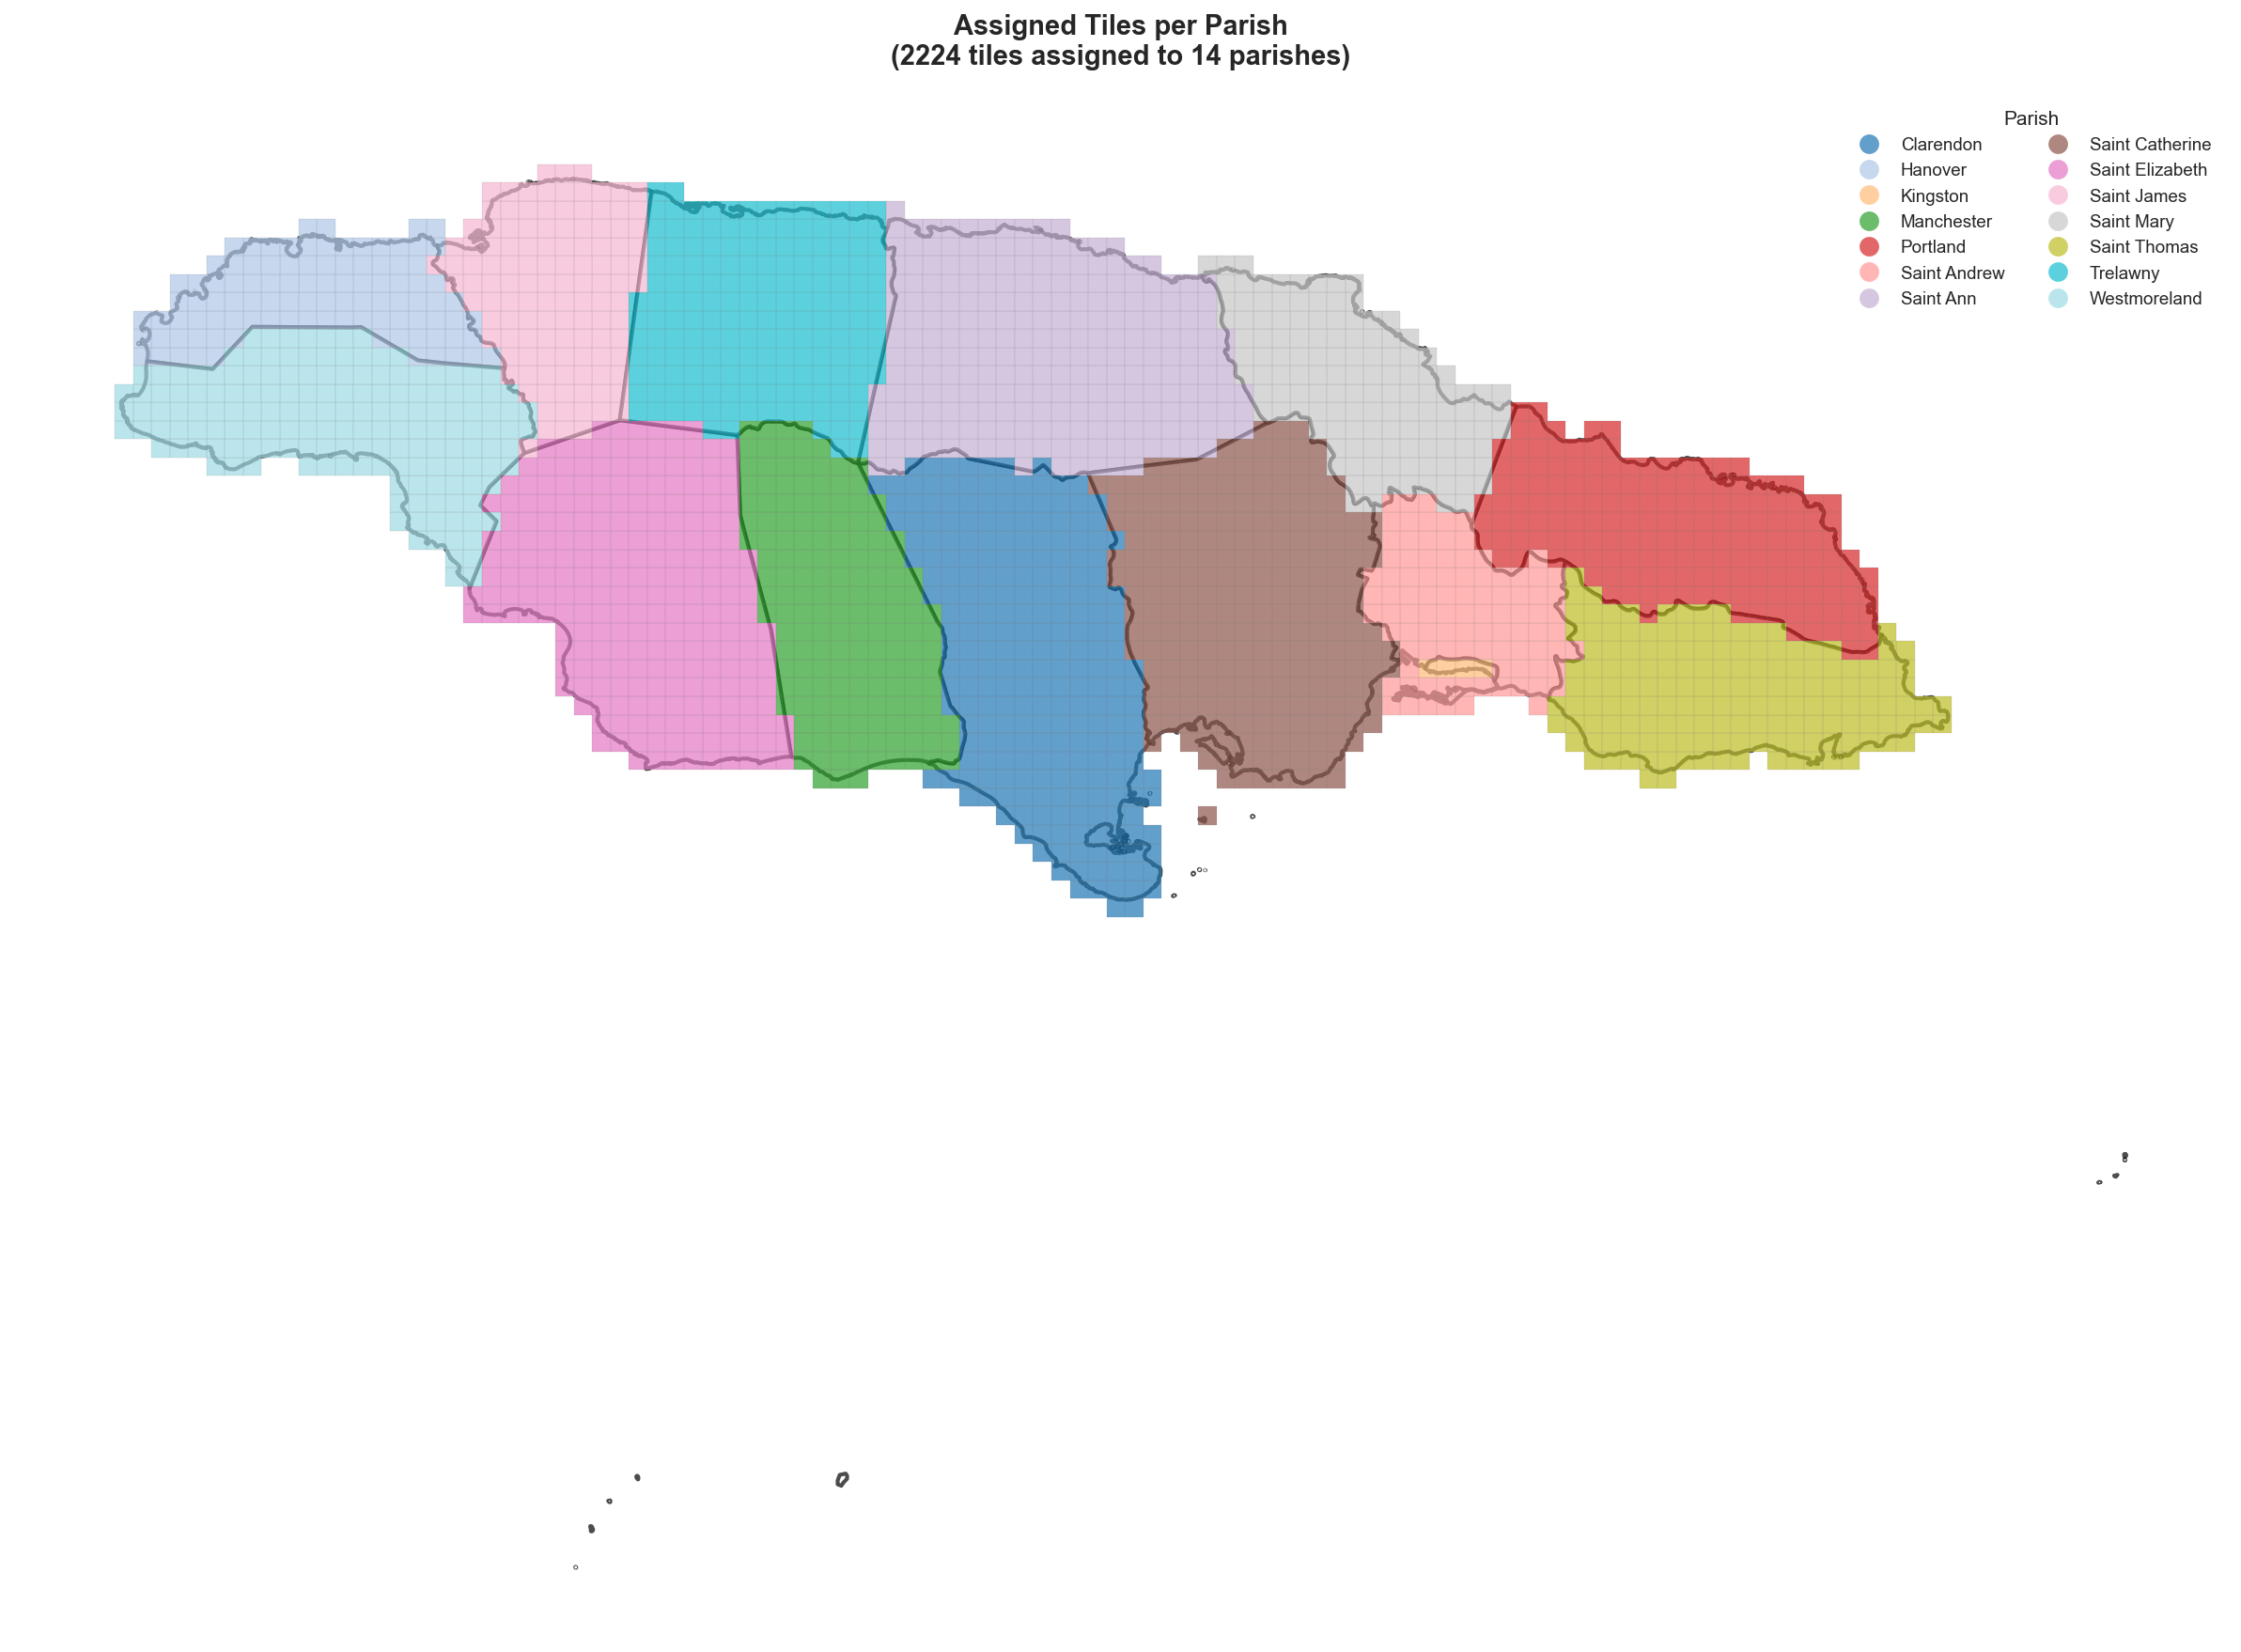


Tile assignment summary:
  Total tiles assigned: 2224
  Parishes: 14
  Tiles per parish:
    Clarendon: 240 tiles
    Hanover: 100 tiles
    Kingston: 4 tiles
    Manchester: 159 tiles
    Portland: 171 tiles
    Saint Andrew: 94 tiles
    Saint Ann: 240 tiles
    Saint Catherine: 239 tiles
    Saint Elizabeth: 235 tiles
    Saint James: 119 tiles
    Saint Mary: 131 tiles
    Saint Thomas: 157 tiles
    Trelawny: 170 tiles
    Westmoreland: 165 tiles


In [6]:
# Visualize assigned tiles per parish
fig, ax = plt.subplots(figsize=(16, 12))

# Plot parish boundaries
gdf_admin.plot(ax=ax, color='white', edgecolor='black', linewidth=2, alpha=0.7, label='Parish Boundaries')

# Plot tiles colored by parish
if len(gdf_tiles_with_admin) > 0:
    gdf_tiles_with_admin.plot(
        ax=ax, 
        column='parish', 
        categorical=True, 
        cmap='tab20', 
        alpha=0.7, 
        markersize=2, 
        edgecolor='gray',
        linewidth=0.1,
        legend=True, 
        legend_kwds={
            'loc': 'upper right',
            'fontsize': 9, 
            'ncol': 2,
            'title': 'Parish',
            'title_fontsize': 10
        }
    )

ax.set_title(f'Assigned Tiles per Parish\n({len(gdf_tiles_with_admin)} tiles assigned to {gdf_tiles_with_admin["parish"].nunique()} parishes)', 
             fontsize=14, fontweight='bold', pad=15)
ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\nTile assignment summary:")
print(f"  Total tiles assigned: {len(gdf_tiles_with_admin)}")
print(f"  Parishes: {gdf_tiles_with_admin['parish'].nunique()}")
print(f"  Tiles per parish:")
parish_counts = gdf_tiles_with_admin['parish'].value_counts().sort_index()
for parish, count in parish_counts.items():
    print(f"    {parish}: {count} tiles")


In [7]:
def classify_area(parish, smod_class):
    """
    Classify tile as KMA, Urban, or Rural.
    Priority: KMA > Urban > Rural
    """
    # Check if in KMA first
    if parish in KMA_PARISHES:
        return "KMA"

    # Then check SMOD for urban/rural
    if smod_class is None or math.isnan(smod_class):
        return "unknown"
    elif smod_class >= SMOD_URBAN_THRESHOLD:
        return "Urban"
    else:
        return "Rural"



# Classify each tile
gdf_tiles_with_admin['area_classification'] = gdf_tiles_with_admin.apply(
    lambda row: classify_area(row['parish'], row['smod_class']), axis=1
)

# Remove tiles with unknown classification
gdf_tiles_with_admin = gdf_tiles_with_admin[gdf_tiles_with_admin['area_classification'] != 'unknown'].copy()

# Print classification summary
print("\n" + "=" * 60)
print("Area Classification Summary:")
print("=" * 60)
classification_counts = gdf_tiles_with_admin['area_classification'].value_counts()
for classification, count in classification_counts.items():
    children_pop = gdf_tiles_with_admin[gdf_tiles_with_admin['area_classification'] == classification]['children_population'].sum()
    print(f"{classification}:")
    print(f"  Tiles: {count}")
    print(f"  Children population: {children_pop:,.0f}")

# Calculate targets per classification
print("\n" + "=" * 60)
print("Target Calculation (Total children × Poverty rate):")
print("=" * 60)
classification_targets = {}
for classification in ['KMA', 'Urban', 'Rural']:
    classification_tiles = gdf_tiles_with_admin[gdf_tiles_with_admin['area_classification'] == classification]
    if len(classification_tiles) > 0:
        total_children_pop = classification_tiles['children_population'].sum()

        # Get poverty rate
        if classification == 'KMA':
            poverty_rate = POVERTY_RATE_KMA / 100
        elif classification == 'Urban':
            poverty_rate = POVERTY_RATE_URBAN / 100
        elif classification == 'Rural':
            poverty_rate = POVERTY_RATE_RURAL / 100

        # Calculate target: total children × poverty rate
        target_poor_children = total_children_pop * poverty_rate
        classification_targets[classification] = target_poor_children

        print(f"\n{classification}:")
        print(f"  Total children population: {total_children_pop:,.0f}")
        print(f"  Poverty rate: {poverty_rate*100:.2f}%")
        print(f"  Target poor children: {target_poor_children:,.0f}")
        print(f"  (When selecting tiles, we accumulate children until reaching this target)")
        print(f"  (All children in selected tiles count as poor)")


Area Classification Summary:
Rural:
  Tiles: 1976
  Children population: 411,510
Urban:
  Tiles: 150
  Children population: 248,419
KMA:
  Tiles: 98
  Children population: 185,885

Target Calculation (Total children × Poverty rate):

KMA:
  Total children population: 185,885
  Poverty rate: 34.57%
  Target poor children: 64,256
  (When selecting tiles, we accumulate children until reaching this target)
  (All children in selected tiles count as poor)

Urban:
  Total children population: 248,419
  Poverty rate: 22.92%
  Target poor children: 56,929
  (When selecting tiles, we accumulate children until reaching this target)
  (All children in selected tiles count as poor)

Rural:
  Total children population: 411,510
  Poverty rate: 34.65%
  Target poor children: 142,572
  (When selecting tiles, we accumulate children until reaching this target)
  (All children in selected tiles count as poor)


## Implement Poor Children Identification Methodology


In [8]:
def identify_poorest_children_cells(gdf_tiles, classification_targets, rwi_col='rwi', children_col='children_population', classification_col='area_classification'):
    """
    Identify the cells containing the poorest children by area classification (Urban/Rural/KMA).
    
    Methodology:
    1. For each classification, rank cells by lowest RWI
    2. Starting from lowest RWI, accumulate cells and their **children population** until reaching target
    3. When a tile is selected, ALL children in that tile count as poor
    4. Return the identified cells
    
    Parameters:
    -----------
    gdf_tiles : GeoDataFrame
        Tiles with RWI, children_population, and area_classification information
    classification_targets : dict
        Dictionary mapping classification names to target poor children
    rwi_col : str
        Column name for RWI values
    children_col : str
        Column name for children population values
    classification_col : str
        Column name for area classification (Urban/Rural/KMA)
    
    Returns:
    --------
    GeoDataFrame with identified poorest cells, including a 'is_poorest' flag
    DataFrame with summary statistics
    """
    
    # Create a copy to avoid modifying original
    gdf_result = gdf_tiles.copy()
    gdf_result['is_poorest'] = False
    
    # Store summary statistics
    summary_stats = []
    
    print("\n" + "=" * 60)
    print("Selecting tiles by RWI to reach target:")
    print("=" * 60)
    
    # Process each classification
    for classification_name, target_poor_children in classification_targets.items():
        # Get all tiles for this classification
        classification_tiles = gdf_result[gdf_result[classification_col] == classification_name].copy()
        
        if len(classification_tiles) == 0:
            print(f"No tiles found for classification: {classification_name}")
            continue
        
        # Sort by RWI (ascending - lowest RWI first)
        classification_tiles = classification_tiles.sort_values(by=rwi_col, ascending=True)
        
        # Accumulate CHILDREN POPULATION starting from lowest RWI
        # When a tile is selected, ALL children in that tile count as poor
        cumulative_children_pop = 0
        selected_tiles = []
        
        for idx, row in classification_tiles.iterrows():
            tile_children_pop = row[children_col]
            cumulative_children_pop += tile_children_pop
            selected_tiles.append(idx)
            
            # Check if the target is reached
            if cumulative_children_pop >= target_poor_children:
                break
        
        # Mark selected tiles as poorest
        gdf_result.loc[selected_tiles, 'is_poorest'] = True
        
        # Calculate statistics
        selected_tiles_gdf = gdf_result.loc[selected_tiles]
        final_children_pop = selected_tiles_gdf[children_col].sum()
        # All children in selected tiles count as poor
        final_poor_children = final_children_pop
        
        avg_rwi = selected_tiles_gdf[rwi_col].mean() if len(selected_tiles) > 0 else None
        min_rwi = selected_tiles_gdf[rwi_col].min() if len(selected_tiles) > 0 else None
        max_rwi = selected_tiles_gdf[rwi_col].max() if len(selected_tiles) > 0 else None
        
        # Get parish breakdown for selected tiles
        selected_parishes = selected_tiles_gdf['parish'].value_counts().to_dict()
        
        summary_stats.append({
            'classification': classification_name,
            'target_poor_children': target_poor_children,
            'cells_selected': len(selected_tiles),
            'children_pop_covered': final_children_pop,
            'poor_children_covered': final_poor_children,
            'coverage_pct': (final_poor_children / target_poor_children * 100) if target_poor_children > 0 else 0,
            'avg_rwi': avg_rwi,
            'min_rwi': min_rwi,
            'max_rwi': max_rwi,
            'total_tiles_in_classification': len(classification_tiles),
            'parishes_represented': len(selected_parishes),
        })
        
        print(f"\n{classification_name}:")
        print(f"  Target poor children: {target_poor_children:,.0f}")
        print(f"  Selected {len(selected_tiles)}/{len(classification_tiles)} tiles ({len(selected_tiles)/len(classification_tiles)*100:.1f}%)")
        print(f"  Children in selected tiles: {final_children_pop:,.0f}")
        print(f"  Poor children (all children count as poor): {final_poor_children:,.0f} ({final_poor_children/target_poor_children*100:.1f}%)")
        print(f"  RWI range: {min_rwi:.2f} to {max_rwi:.2f} (avg: {avg_rwi:.2f})")
        print(f"  Tiles in {len(selected_parishes)} parishes")
    
    return gdf_result, pd.DataFrame(summary_stats)

# Run the analysis
print("Identifying poorest children cells by classification (Urban/Rural/KMA)...")
gdf_poorest, df_summary = identify_poorest_children_cells(
    gdf_tiles_with_admin,
    classification_targets,
    rwi_col='rwi',
    children_col='children_population',
    classification_col='area_classification'
)

print("\n" + "=" * 60)
print(f"Total poorest cells identified: {gdf_poorest['is_poorest'].sum()}")
print(f"Total children in selected cells: {gdf_poorest[gdf_poorest['is_poorest']]['children_population'].sum():,.0f}")
print(f"(All children in selected cells are considered poor)")

# Print summary by classification
print("\n" + "=" * 60)
print("Summary by Classification:")
print("=" * 60)
for classification in ['KMA', 'Urban', 'Rural']:
    classification_tiles = gdf_poorest[gdf_poorest['area_classification'] == classification]
    selected = classification_tiles[classification_tiles['is_poorest']]
    total_children = classification_tiles['children_population'].sum()
    selected_children = selected['children_population'].sum() if len(selected) > 0 else 0
    print(f"{classification}: {len(selected)}/{len(classification_tiles)} tiles selected ({len(selected)/len(classification_tiles)*100:.1f}%)")
    print(f"  Children: {selected_children:,.0f} / {total_children:,.0f} ({selected_children/total_children*100:.1f}%)")


Identifying poorest children cells by classification (Urban/Rural/KMA)...

Selecting tiles by RWI to reach target:

KMA:
  Target poor children: 64,256
  Selected 73/98 tiles (74.5%)
  Children in selected tiles: 65,004
  Poor children (all children count as poor): 65,004 (101.2%)
  RWI range: -0.68 to 0.86 (avg: 0.26)
  Tiles in 2 parishes

Urban:
  Target poor children: 56,929
  Selected 49/150 tiles (32.7%)
  Children in selected tiles: 57,165
  Poor children (all children count as poor): 57,165 (100.4%)
  RWI range: -0.14 to 0.57 (avg: 0.40)
  Tiles in 12 parishes

Rural:
  Target poor children: 142,572
  Selected 1209/1976 tiles (61.2%)
  Children in selected tiles: 142,839
  Poor children (all children count as poor): 142,839 (100.2%)
  RWI range: -1.04 to 0.06 (avg: -0.15)
  Tiles in 12 parishes

Total poorest cells identified: 1331
Total children in selected cells: 265,008
(All children in selected cells are considered poor)

Summary by Classification:
KMA: 73/98 tiles selected

## Calculate Expected Impacted Poor Children

Load impact probability data and calculate the expected impacted poor children (poor children × impact probability):


In [9]:
# Store impact data for multiple thresholds (tile-level only)
impact_tile_data = {}

if DATE and FORECAST_TIME and WIND_THRESHOLDS and STORM:
    date_str = DATE.replace("-", "")
    forecast_datetime_str = f"{date_str}{FORECAST_TIME}"
    
    # Load tile-level data for each wind threshold
    for wind_threshold in WIND_THRESHOLDS:
        tile_impact_file = f"{COUNTRY}_{STORM}_{forecast_datetime_str}_{wind_threshold}_14.csv"
        tile_impact_path = os.path.join(BASE_DIR, "geodb", "aos_views", "mercator_views", tile_impact_file)
        
        if os.path.exists(tile_impact_path):
            print(f"Loading tile-level impact data for {wind_threshold}kt from: {tile_impact_path}")
            df_tile = pd.read_csv(tile_impact_path)
            zone_cols = [col for col in ['zone_id', 'tile_id', 'tileid', 'tile'] if col in df_tile.columns]
            if not zone_cols or 'probability' not in df_tile.columns:
                print(f"  Tile file missing required columns; {wind_threshold}kt will have 0 impact")
                continue
            zone_col = zone_cols[0]
            impact_tile_data[wind_threshold] = df_tile[[zone_col, 'probability']].rename(columns={zone_col: 'tile_id_source'})
            print(f"  Loaded {len(df_tile)} tile probabilities")
        else:
            print(f"Tile-level impact file not found for {wind_threshold}kt: {tile_impact_path}")
            print(f"  {wind_threshold}kt will have 0 impact (no data available)")
    
    # Process all requested thresholds (even if no data, set impact to 0)
    if WIND_THRESHOLDS:
        # Attach a helper column for tile-id matching (strip leading zeros for consistency)
        gdf_poorest['tile_id_match'] = gdf_poorest['tile_id'].astype(str).str.lstrip('0')
        
        # Merge tile-level probabilities for thresholds with data
        if impact_tile_data:
            print(f"\nMerging tile-level impact probabilities for {len(impact_tile_data)} threshold(s)...")
            for wind_threshold, df_tile in impact_tile_data.items():
                prob_col = f'impact_probability_{wind_threshold}kt'
                impact_col = f'potentially_impacted_poor_children_{wind_threshold}kt'
                df_tile = df_tile.copy()
                df_tile['tile_id_match'] = df_tile['tile_id_source'].astype(str).str.lstrip('0')
                df_tile = df_tile.rename(columns={'probability': prob_col})
                gdf_poorest = gdf_poorest.merge(
                    df_tile[['tile_id_match', prob_col]],
                    on='tile_id_match',
                    how='left'
                )
                # Calculate expected impacted poor children at TILE LEVEL:
                # Impact = Children Population × Impact Probability
                # This is calculated for ALL tiles, but only tiles marked as 'poor' (is_poorest=True) 
                # will have non-zero values. These tile-level impacts are then aggregated (summed) 
                # to parish level in the visualization section below.
                gdf_poorest[impact_col] = (
                    gdf_poorest['children_population'] * gdf_poorest[prob_col]
                ).where(gdf_poorest['is_poorest'], 0).fillna(0).round(0).astype(int)
        
        # For thresholds without data, set impact to 0
        for wind_threshold in WIND_THRESHOLDS:
            impact_col = f'potentially_impacted_poor_children_{wind_threshold}kt'
            if impact_col not in gdf_poorest.columns:
                # No data available for this threshold, set impact to 0
                gdf_poorest[impact_col] = 0
        
        # Aggregate impact data by classification for summary
        impact_summary = []
        for classification in ['KMA', 'Urban', 'Rural']:
            classification_tiles = gdf_poorest[gdf_poorest['area_classification'] == classification]
            selected_tiles = classification_tiles[classification_tiles['is_poorest']]
            
            if len(selected_tiles) > 0:
                row = {'classification': classification}
                for wind_threshold in WIND_THRESHOLDS:
                    impact_col = f'potentially_impacted_poor_children_{wind_threshold}kt'
                    row[impact_col] = selected_tiles[impact_col].sum()
                impact_summary.append(row)
        
        if impact_summary:
            df_impact_summary = pd.DataFrame(impact_summary)
            df_summary = df_summary.merge(df_impact_summary, on='classification', how='left')
        
        # Report totals for each threshold
        print(f"\nImpact probability processing complete for {len(WIND_THRESHOLDS)} threshold(s)")
        for wind_threshold in WIND_THRESHOLDS:
            impact_col = f'potentially_impacted_poor_children_{wind_threshold}kt'
            if impact_col in gdf_poorest.columns:
                total = gdf_poorest[gdf_poorest['is_poorest']][impact_col].sum()
                if total > 0:
                    print(f"   {wind_threshold}kt: Total potentially impacted poor children: {total:,.0f}")
                else:
                    print(f"   {wind_threshold}kt: Total potentially impacted poor children: 0 (no data available)")
else:
    print("Impact probability configuration not set (DATE, FORECAST_TIME, WIND_THRESHOLDS, STORM)")
    print("   Skipping impact probability calculation")


Loading tile-level impact data for 34kt from: data/geodb/aos_views/mercator_views/JAM_MELISSA_20251027000000_34_14.csv
  Loaded 2231 tile probabilities
Loading tile-level impact data for 50kt from: data/geodb/aos_views/mercator_views/JAM_MELISSA_20251027000000_50_14.csv
  Loaded 2231 tile probabilities
Loading tile-level impact data for 64kt from: data/geodb/aos_views/mercator_views/JAM_MELISSA_20251027000000_64_14.csv
  Loaded 2231 tile probabilities

Merging tile-level impact probabilities for 3 threshold(s)...

Impact probability processing complete for 3 threshold(s)
   34kt: Total potentially impacted poor children: 86,185
   50kt: Total potentially impacted poor children: 7,109
   64kt: Total potentially impacted poor children: 1,791


## Overall Map Visualization


  Saved: analysis_output/visualizations/selected_tiles_by_classification_kmared_urbanorange_ruralgreen.png


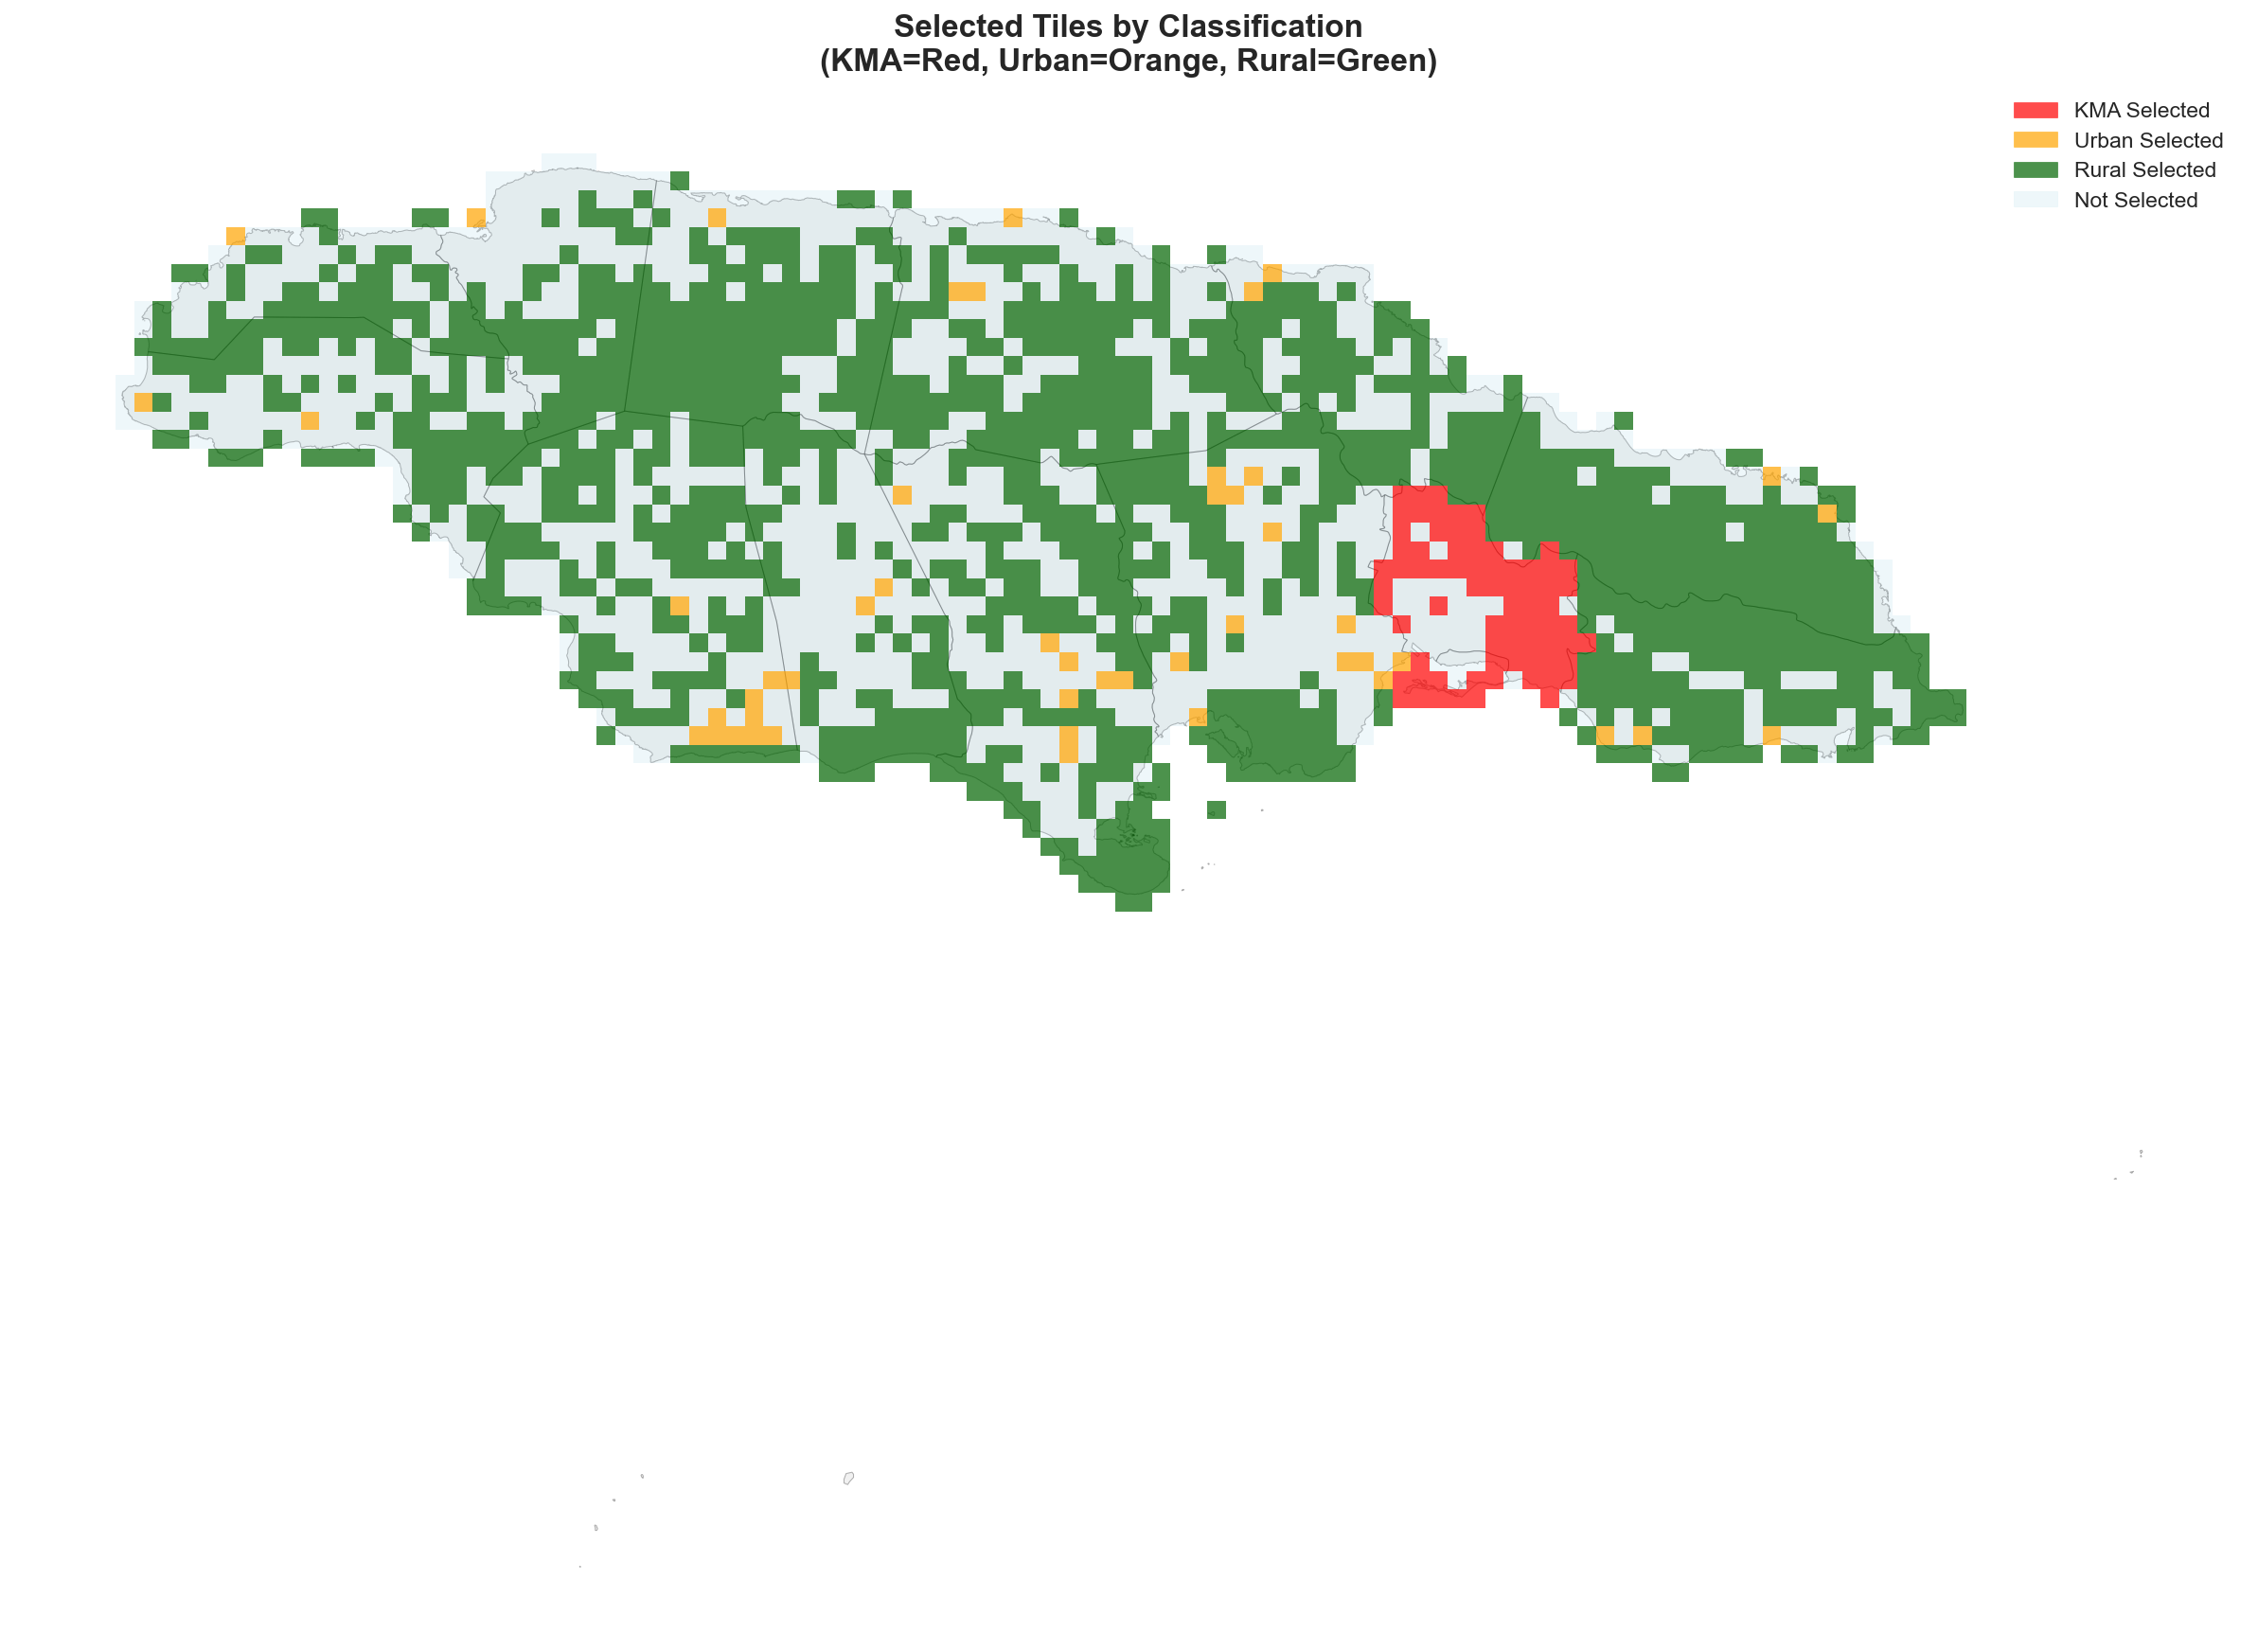


Map Summary:
  Total tiles: 2224
  Selected tiles: 1331 (59.8%)
  Children in selected tiles: 265,008


In [10]:
# Create overall map showing selected tiles by classification
fig, ax = plt.subplots(figsize=(16, 12))

# Plot admin boundaries
gdf_admin.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5, alpha=0.3)

# Plot non-selected tiles
non_selected = gdf_poorest[~gdf_poorest['is_poorest']]
if len(non_selected) > 0:
    non_selected.plot(ax=ax, color='lightblue', alpha=0.2, markersize=1, label='Not Selected')

# Plot selected tiles by classification
import matplotlib.patches as mpatches
legend_handles = []
for classification, color in [('KMA', 'red'), ('Urban', 'orange'), ('Rural', 'darkgreen')]:
    selected_class = gdf_poorest[(gdf_poorest['is_poorest']) & (gdf_poorest['area_classification'] == classification)]
    if len(selected_class) > 0:
        selected_class.plot(ax=ax, color=color, alpha=0.7, markersize=2)
        legend_handles.append(mpatches.Patch(color=color, label=f'{classification} Selected', alpha=0.7))

if len(non_selected) > 0:
    legend_handles.append(mpatches.Patch(color='lightblue', label='Not Selected', alpha=0.2))

ax.set_title('Selected Tiles by Classification\n(KMA=Red, Urban=Orange, Rural=Green)', 
              fontsize=16, fontweight='bold')
if legend_handles:
    ax.legend(handles=legend_handles, loc='upper right', fontsize=11)
ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\nMap Summary:")
print(f"  Total tiles: {len(gdf_poorest)}")
print(f"  Selected tiles: {gdf_poorest['is_poorest'].sum()} ({gdf_poorest['is_poorest'].sum()/len(gdf_poorest)*100:.1f}%)")
print(f"  Children in selected tiles: {gdf_poorest[gdf_poorest['is_poorest']]['children_population'].sum():,.0f}")


## Methodology Demonstration



METHODOLOGY DEMONSTRATION: Urban

Urban Classification:
  Total children population: 248,419
  Poverty rate: 22.92%
  Target poor children: 56,929
  Total tiles in classification: 150
  Tiles selected: 49
  Children in selected tiles: 57,165

  Saved: analysis_output/visualizations/methodology_demonstration_how_poorest_children_cells_are_selected_in_urban_classification.png


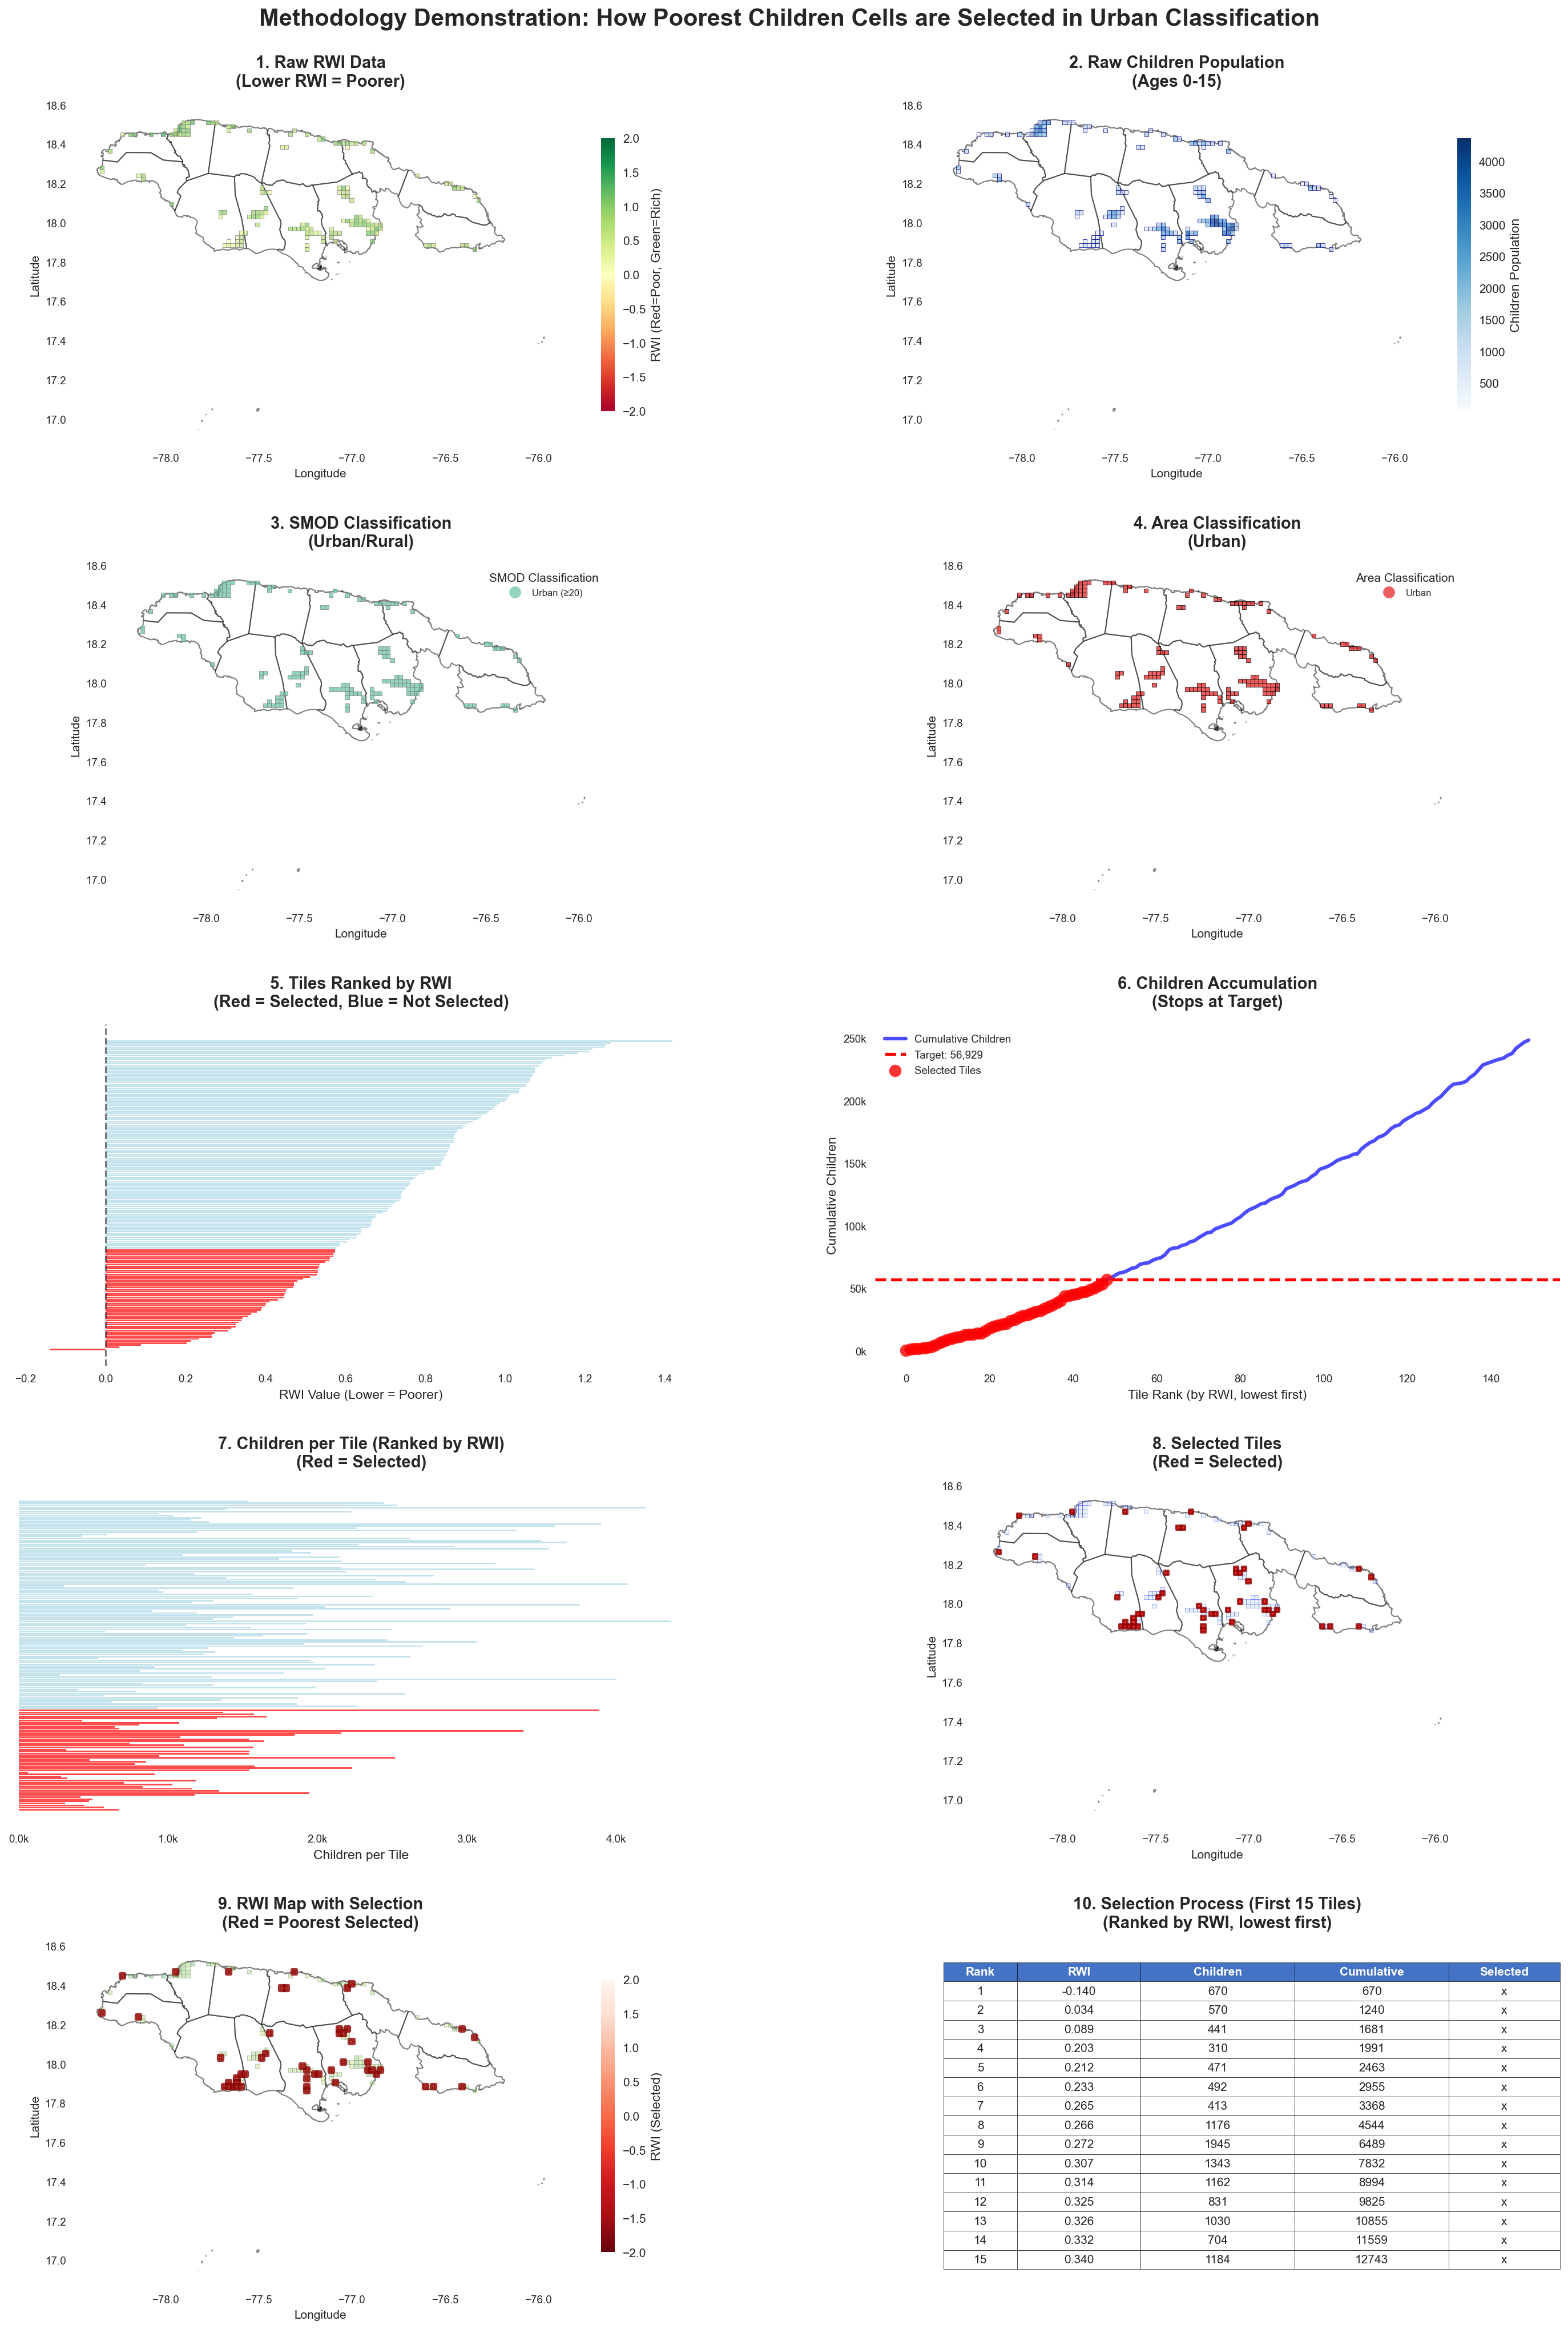


Completed methodology demonstration for Urban

METHODOLOGY DEMONSTRATION: Rural

Rural Classification:
  Total children population: 411,510
  Poverty rate: 34.65%
  Target poor children: 142,572
  Total tiles in classification: 1976
  Tiles selected: 1209
  Children in selected tiles: 142,839

  Saved: analysis_output/visualizations/methodology_demonstration_how_poorest_children_cells_are_selected_in_rural_classification.png


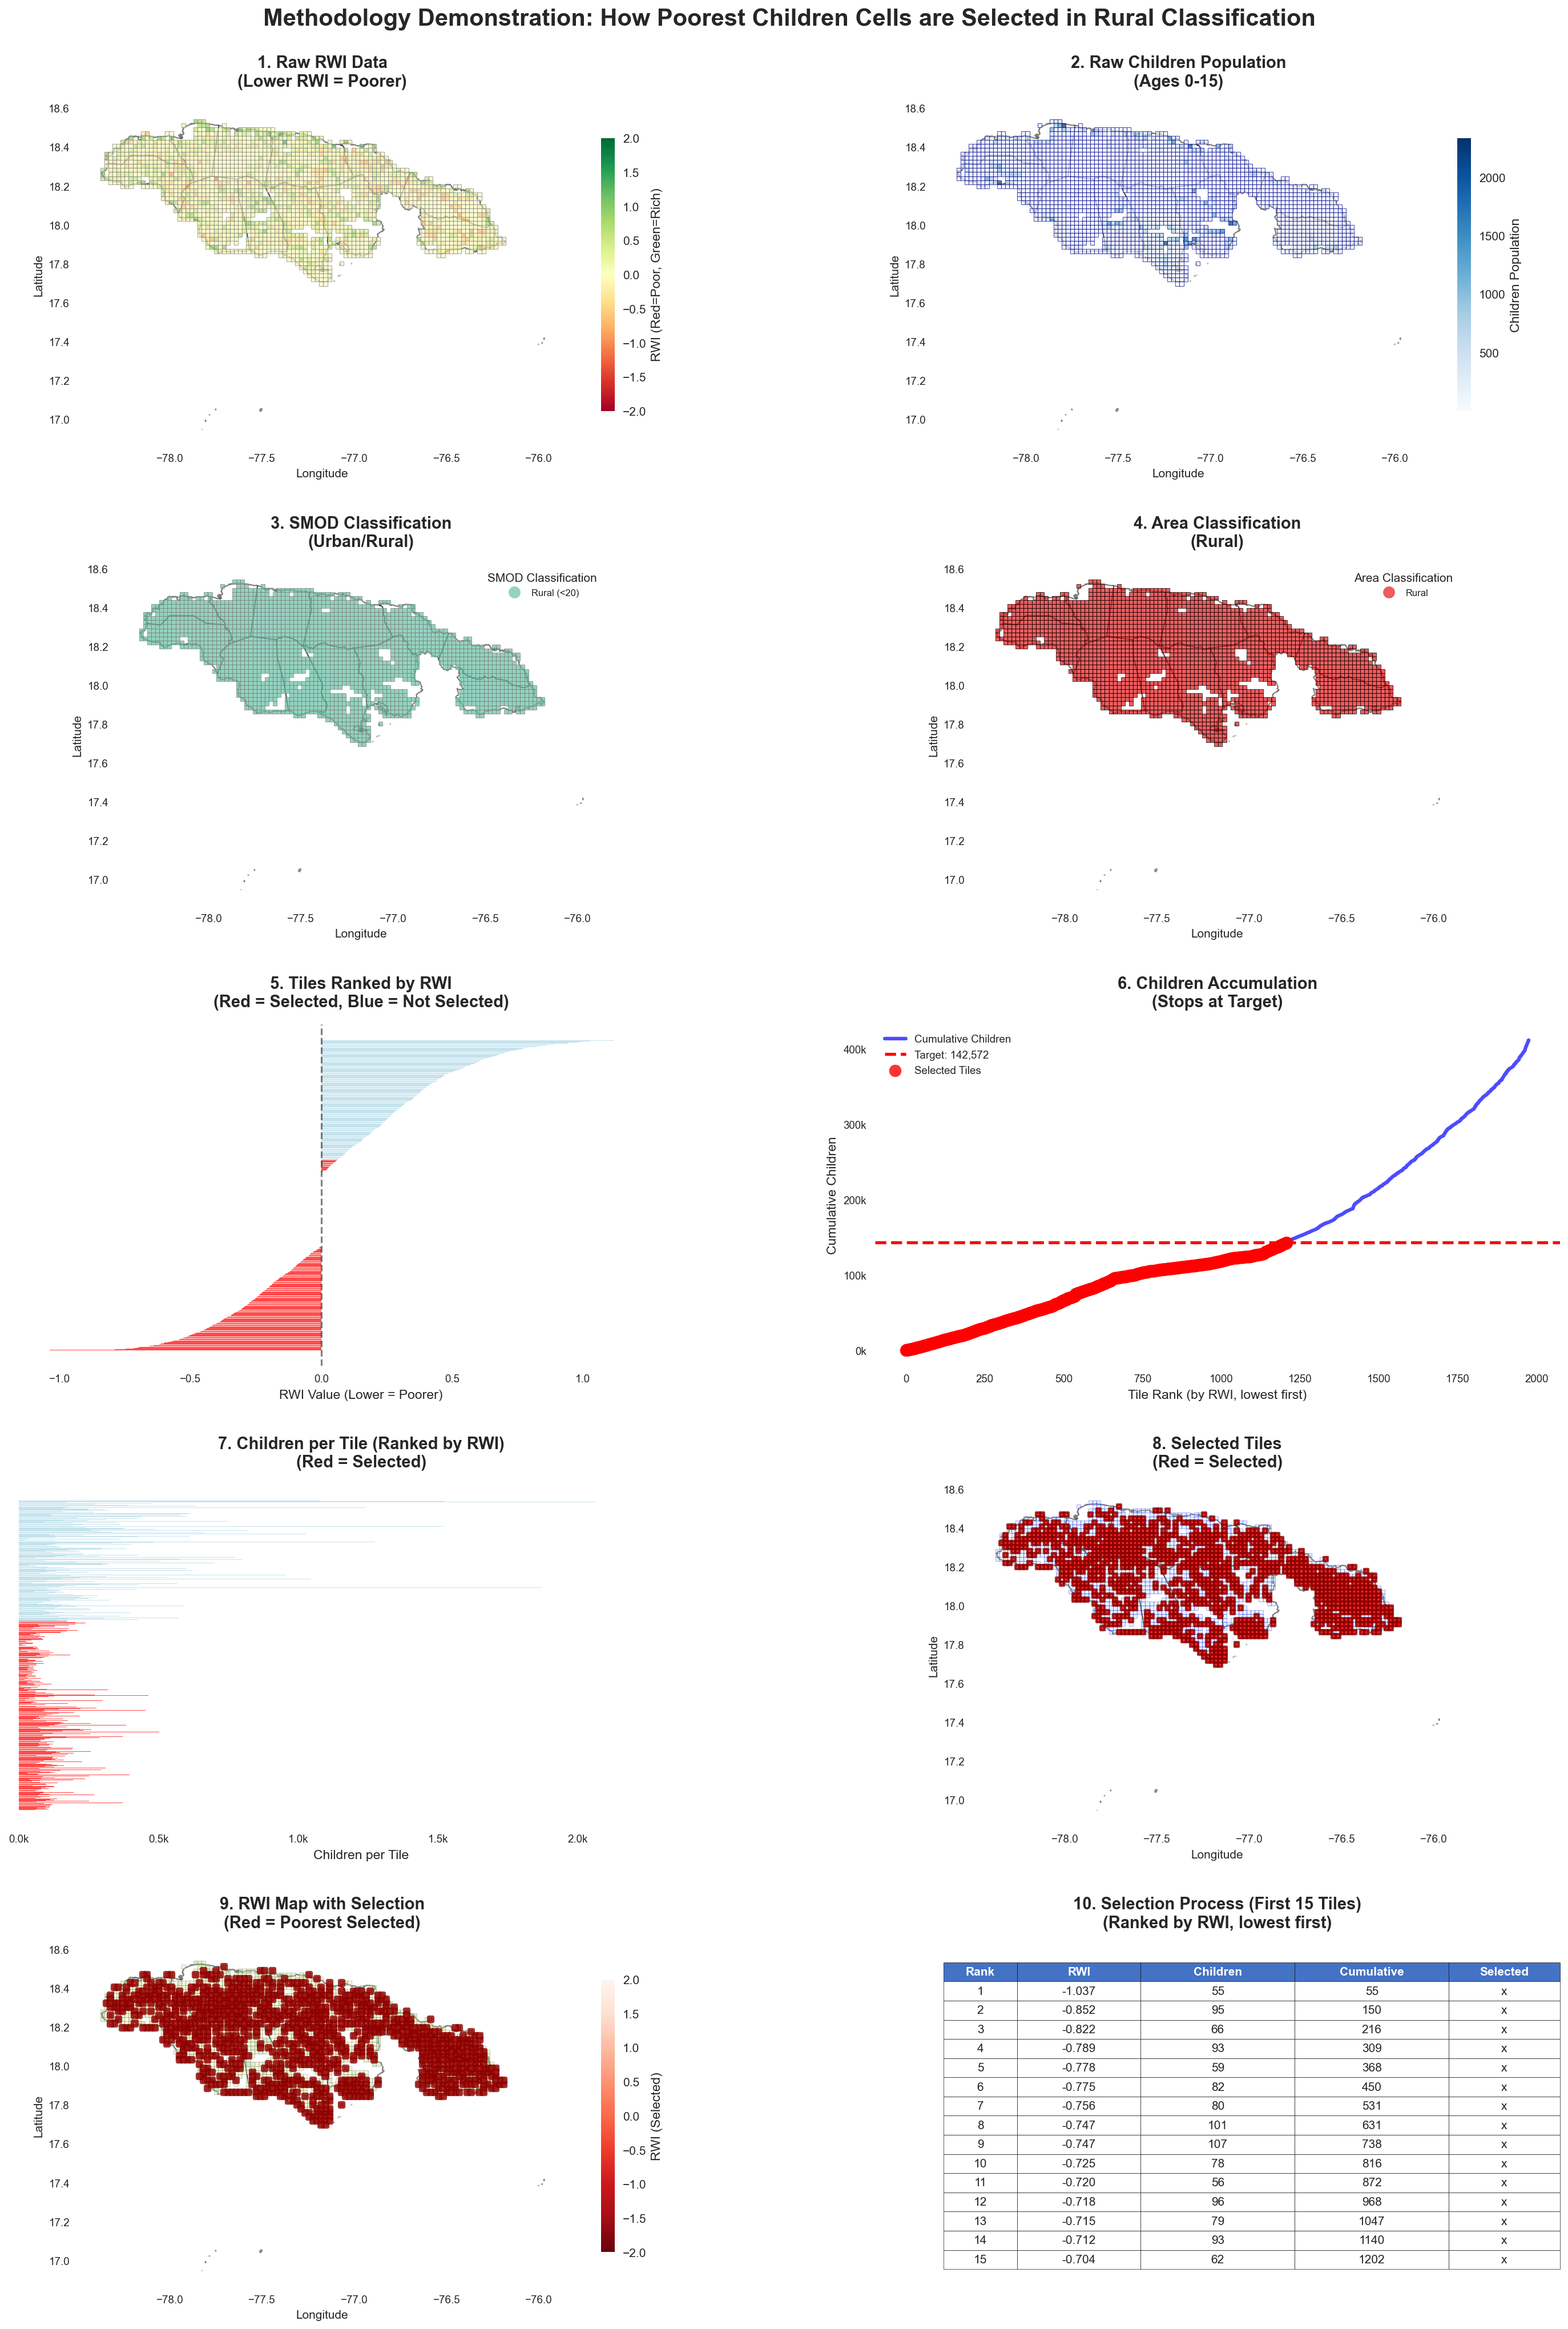


Completed methodology demonstration for Rural

METHODOLOGY DEMONSTRATION: KMA

KMA Classification:
  Total children population: 185,885
  Poverty rate: 34.57%
  Target poor children: 64,256
  Total tiles in classification: 98
  Tiles selected: 73
  Children in selected tiles: 65,004

  Saved: analysis_output/visualizations/methodology_demonstration_how_poorest_children_cells_are_selected_in_kma_classification.png


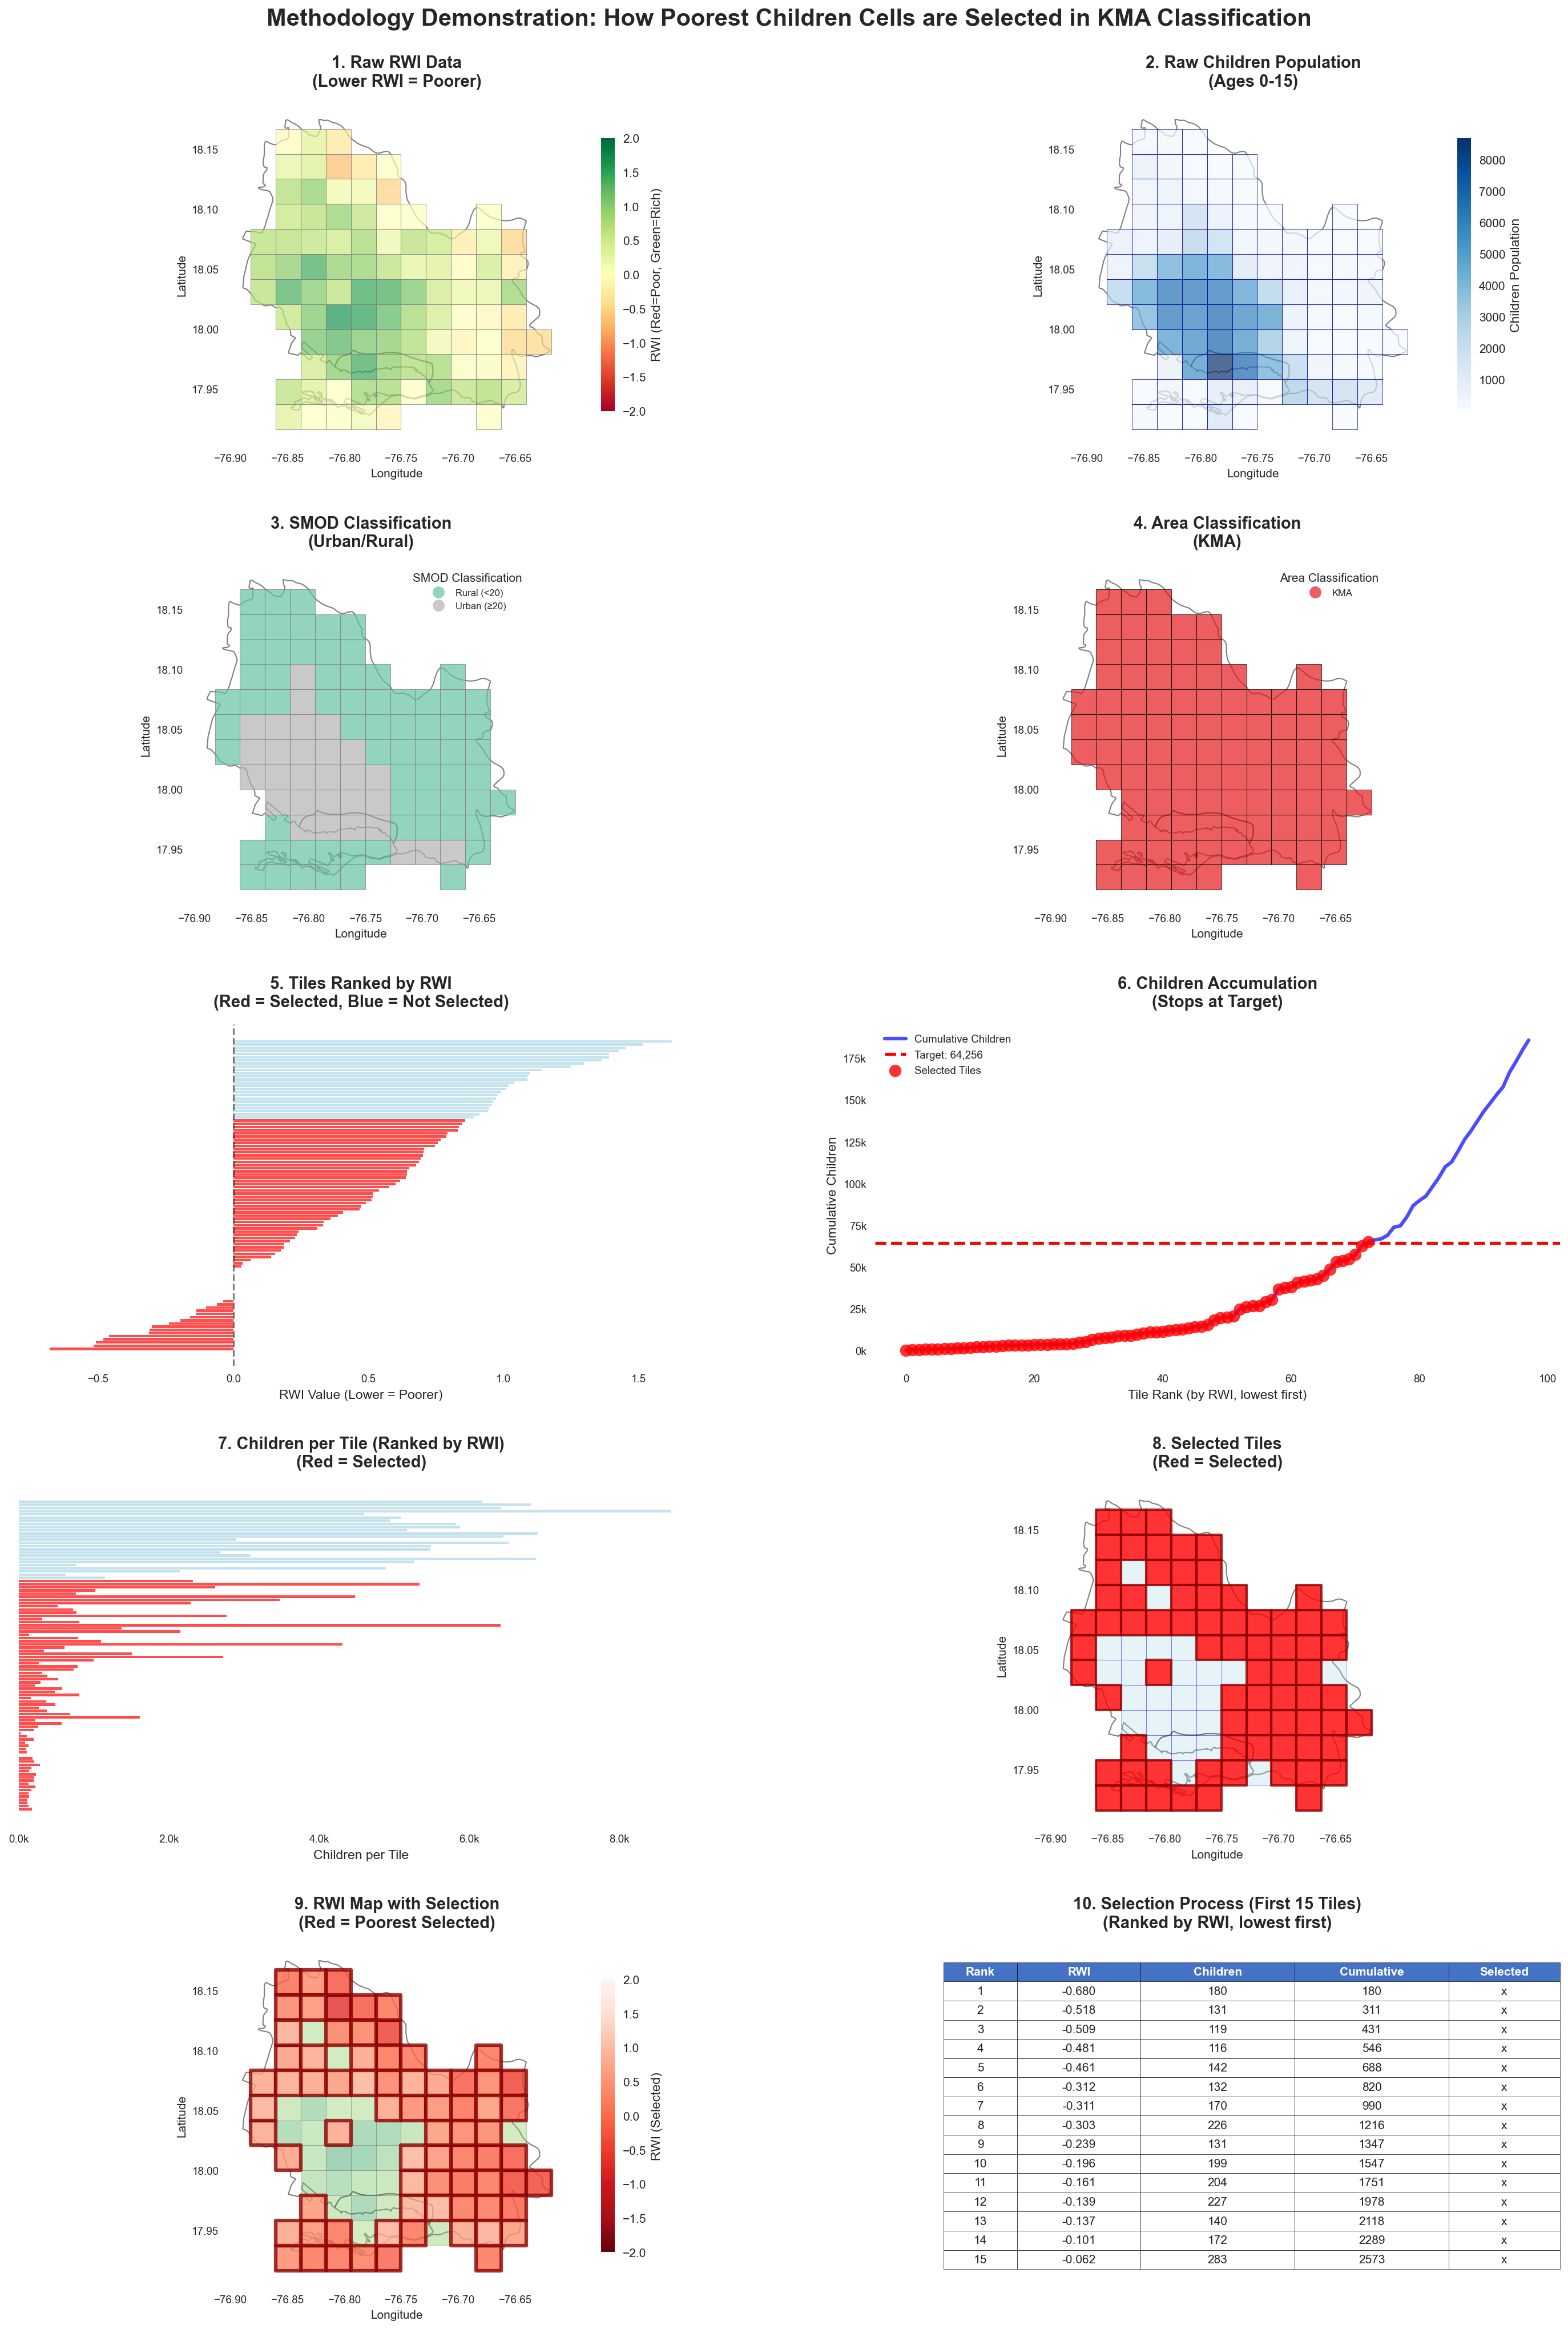


Completed methodology demonstration for KMA


In [11]:
# Create comprehensive methodology demonstration for each classification
# Generate separate demonstrations for Urban, Rural, and KMA

for DEMO_CLASSIFICATION in ['Urban', 'Rural', 'KMA']:
    print(f"\n" + "=" * 80)
    print(f"METHODOLOGY DEMONSTRATION: {DEMO_CLASSIFICATION}")
    print("=" * 80)
    
    # Get data for the demo classification
    classification_tiles = gdf_poorest[gdf_poorest['area_classification'] == DEMO_CLASSIFICATION].copy()
    
    if len(classification_tiles) == 0:
        print(f"No tiles found for {DEMO_CLASSIFICATION}")
        print(f"Available classifications: {gdf_poorest['area_classification'].unique()}")
        continue
    
    # Sort by RWI (ascending - lowest first)
    classification_tiles_sorted = classification_tiles.sort_values(by='rwi', ascending=True).copy()
    
    # Calculate cumulative children
    classification_tiles_sorted['cumulative_children'] = classification_tiles_sorted['children_population'].cumsum()
    
    # Get target
    target_poor_children = classification_targets[DEMO_CLASSIFICATION]
    
    # Identify which tiles are selected
    classification_tiles_sorted['is_selected'] = classification_tiles_sorted['is_poorest']
    
    # Get poverty rate for this classification
    if DEMO_CLASSIFICATION == 'KMA':
        poverty_rate = POVERTY_RATE_KMA / 100
    elif DEMO_CLASSIFICATION == 'Urban':
        poverty_rate = POVERTY_RATE_URBAN / 100
    elif DEMO_CLASSIFICATION == 'Rural':
        poverty_rate = POVERTY_RATE_RURAL / 100
    
    total_children = classification_tiles_sorted['children_population'].sum()
    
    print(f"\n{DEMO_CLASSIFICATION} Classification:")
    print(f"  Total children population: {total_children:,.0f}")
    print(f"  Poverty rate: {poverty_rate*100:.2f}%")
    print(f"  Target poor children: {target_poor_children:,.0f}")
    print(f"  Total tiles in classification: {len(classification_tiles_sorted)}")
    print(f"  Tiles selected: {classification_tiles_sorted['is_selected'].sum()}")
    print(f"  Children in selected tiles: {classification_tiles_sorted[classification_tiles_sorted['is_selected']]['children_population'].sum():,.0f}")
    print()
    
    # Get parishes that have tiles in this classification
    demo_parishes = classification_tiles_sorted['parish'].unique()
    demo_admin = gdf_admin[gdf_admin['name'].isin(demo_parishes)]
    
    # Create comprehensive visualization (5 rows x 2 columns, 10 panels total - 2-column layout)
    fig = plt.figure(figsize=(20, 28))
    from matplotlib.gridspec import GridSpec
    gs = GridSpec(5, 2, figure=fig, hspace=0.35, wspace=0.25, left=0.05, right=0.95, top=0.94, bottom=0.03)
    
    # Get RWI range - RWI typically ranges from -2 to 2
    rwi_min = classification_tiles_sorted['rwi'].min()
    rwi_max = classification_tiles_sorted['rwi'].max()
    # Use full RWI range for proper color mapping
    rwi_vmin = -2.0
    rwi_vmax = 2.0
    
    # 1. Raw RWI Data (Row 0, Col 0)
    ax1 = fig.add_subplot(gs[0, 0])
    if len(demo_admin) > 0:
        demo_admin.plot(ax=ax1, color='white', edgecolor='black', linewidth=1, alpha=0.5)
    classification_tiles_sorted.plot(ax=ax1, column='rwi', cmap='RdYlGn', 
                                    edgecolor='gray', linewidth=0.5, alpha=0.7, legend=True,
                                    vmin=rwi_vmin, vmax=rwi_vmax,
                                    legend_kwds={'label': 'RWI (Red=Poor, Green=Rich)', 'shrink': 0.8})
    ax1.set_title('1. Raw RWI Data\n(Lower RWI = Poorer)', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlabel('Longitude', fontsize=10)
    ax1.set_ylabel('Latitude', fontsize=10)
    ax1.tick_params(labelsize=9)
    ax1.grid(True, alpha=0.3)
    
    # 2. Raw Children Population (Row 0, Col 1)
    ax2 = fig.add_subplot(gs[0, 1])
    if len(demo_admin) > 0:
        demo_admin.plot(ax=ax2, color='white', edgecolor='black', linewidth=1, alpha=0.5)
    classification_tiles_sorted.plot(ax=ax2, column='children_population', cmap='Blues', 
                                    edgecolor='darkblue', linewidth=0.5, alpha=0.7, legend=True,
                                    legend_kwds={'label': 'Children Population', 'shrink': 0.8})
    ax2.set_title('2. Raw Children Population\n(Ages 0-15)', fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('Longitude', fontsize=10)
    ax2.set_ylabel('Latitude', fontsize=10)
    ax2.tick_params(labelsize=9)
    ax2.grid(True, alpha=0.3)
    
    # 3. SMOD Classification (Row 1, Col 0)
    ax3 = fig.add_subplot(gs[1, 0])
    if len(demo_admin) > 0:
        demo_admin.plot(ax=ax3, color='white', edgecolor='black', linewidth=1, alpha=0.5)
    # Create SMOD categories for visualization
    classification_tiles_sorted['smod_category'] = classification_tiles_sorted['smod_class'].apply(
        lambda x: 'Urban (≥20)' if x >= SMOD_URBAN_THRESHOLD else 'Rural (<20)' if pd.notna(x) else 'No Data'
    )
    classification_tiles_sorted.plot(ax=ax3, column='smod_category', categorical=True,
                                    cmap='Set2', edgecolor='gray', linewidth=0.5, alpha=0.7, legend=True,
                                    legend_kwds={'title': 'SMOD Classification', 'loc': 'upper right', 'fontsize': 8})
    ax3.set_title('3. SMOD Classification\n(Urban/Rural)', fontsize=14, fontweight='bold', pad=15)
    ax3.set_xlabel('Longitude', fontsize=10)
    ax3.set_ylabel('Latitude', fontsize=10)
    ax3.tick_params(labelsize=9)
    ax3.grid(True, alpha=0.3)
    
    # 4. Area Classification (Row 1, Col 1)
    ax4 = fig.add_subplot(gs[1, 1])
    if len(demo_admin) > 0:
        demo_admin.plot(ax=ax4, color='white', edgecolor='black', linewidth=1, alpha=0.5)
    classification_tiles_sorted.plot(ax=ax4, column='area_classification', categorical=True,
                                    cmap='Set1', edgecolor='black', linewidth=0.5, alpha=0.7, legend=True,
                                    legend_kwds={'title': 'Area Classification', 'loc': 'upper right', 'fontsize': 8})
    ax4.set_title(f'4. Area Classification\n({DEMO_CLASSIFICATION})', fontsize=14, fontweight='bold', pad=15)
    ax4.set_xlabel('Longitude', fontsize=10)
    ax4.set_ylabel('Latitude', fontsize=10)
    ax4.tick_params(labelsize=9)
    ax4.grid(True, alpha=0.3)
    
    # 5. RWI Ranking (Row 2, Col 0) - Bar chart showing RWI sorted
    ax5 = fig.add_subplot(gs[2, 0])
    sorted_rwi = classification_tiles_sorted['rwi'].values
    colors_rwi = ['red' if sel else 'lightblue' for sel in classification_tiles_sorted['is_selected'].values]
    ax5.barh(range(len(sorted_rwi)), sorted_rwi, color=colors_rwi, alpha=0.7)
    ax5.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
    ax5.set_yticks([])
    ax5.set_xlabel('RWI Value (Lower = Poorer)', fontsize=11)
    ax5.set_title('5. Tiles Ranked by RWI\n(Red = Selected, Blue = Not Selected)', fontsize=14, fontweight='bold', pad=15)
    ax5.tick_params(labelsize=9)
    ax5.grid(True, alpha=0.3, axis='x')
    
    # 6. Cumulative Children (Row 2, Col 1) - Line chart showing accumulation
    ax6 = fig.add_subplot(gs[2, 1])
    x = range(len(classification_tiles_sorted))
    ax6.plot(x, classification_tiles_sorted['cumulative_children'].values, 
            'b-', linewidth=3, label='Cumulative Children', alpha=0.7)
    ax6.axhline(y=target_poor_children, color='red', linestyle='--', linewidth=2.5, 
               label=f'Target: {target_poor_children:,.0f}')
    
    # Highlight selected tiles
    selected_indices = [i for i, sel in enumerate(classification_tiles_sorted['is_selected'].values) if sel]
    if selected_indices:
        selected_cumulative = classification_tiles_sorted.iloc[selected_indices]['cumulative_children'].values
        ax6.scatter(selected_indices, selected_cumulative, color='red', s=100, zorder=5, 
                   label='Selected Tiles', alpha=0.8)
    
    ax6.set_xlabel('Tile Rank (by RWI, lowest first)', fontsize=11)
    ax6.set_ylabel('Cumulative Children', fontsize=11)
    ax6.set_title('6. Children Accumulation\n(Stops at Target)', fontsize=14, fontweight='bold', pad=15)
    ax6.tick_params(labelsize=9)
    ax6.legend(fontsize=9)
    ax6.grid(True, alpha=0.3)
    ax6.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}k'))
    
    # 7. Children per Tile (Row 3, Col 0) - Bar chart
    ax7 = fig.add_subplot(gs[3, 0])
    sorted_children = classification_tiles_sorted['children_population'].values
    colors_children = ['red' if sel else 'lightblue' for sel in classification_tiles_sorted['is_selected'].values]
    ax7.barh(range(len(sorted_children)), sorted_children, color=colors_children, alpha=0.7)
    ax7.set_yticks([])
    ax7.set_xlabel('Children per Tile', fontsize=11)
    ax7.set_title('7. Children per Tile (Ranked by RWI)\n(Red = Selected)', fontsize=14, fontweight='bold', pad=15)
    ax7.tick_params(labelsize=9)
    ax7.grid(True, alpha=0.3, axis='x')
    ax7.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.1f}k'))
    
    # 8. Selection Result Map (Row 3, Col 1)
    ax8 = fig.add_subplot(gs[3, 1])
    if len(demo_admin) > 0:
        demo_admin.plot(ax=ax8, color='white', edgecolor='black', linewidth=1, alpha=0.5)
    # Plot non-selected tiles
    non_selected = classification_tiles_sorted[~classification_tiles_sorted['is_selected']]
    if len(non_selected) > 0:
        non_selected.plot(ax=ax8, color='lightblue', edgecolor='blue', alpha=0.3, linewidth=0.5)
    # Plot selected tiles (poorest)
    selected = classification_tiles_sorted[classification_tiles_sorted['is_selected']]
    if len(selected) > 0:
        selected.plot(ax=ax8, color='red', edgecolor='darkred', linewidth=2, alpha=0.8, label='Selected Tiles')
    ax8.set_title('8. Selected Tiles\n(Red = Selected)', fontsize=14, fontweight='bold', pad=15)
    ax8.set_xlabel('Longitude', fontsize=10)
    ax8.set_ylabel('Latitude', fontsize=10)
    ax8.tick_params(labelsize=9)
    ax8.legend(fontsize=9)
    ax8.grid(True, alpha=0.3)
    
    # 9. Combined RWI + Selection (Row 4, Col 0)
    ax9 = fig.add_subplot(gs[4, 0])
    if len(demo_admin) > 0:
        demo_admin.plot(ax=ax9, color='white', edgecolor='black', linewidth=1, alpha=0.5)
    # Color by RWI, highlight selected
    non_selected = classification_tiles_sorted[~classification_tiles_sorted['is_selected']]
    selected = classification_tiles_sorted[classification_tiles_sorted['is_selected']]
    
    if len(non_selected) > 0:
        non_selected.plot(ax=ax9, column='rwi', cmap='RdYlGn', 
                         edgecolor='gray', linewidth=0.5, alpha=0.4, legend=False,
                         vmin=rwi_vmin, vmax=rwi_vmax)
    if len(selected) > 0:
        selected.plot(ax=ax9, column='rwi', cmap='Reds_r',
                     edgecolor='darkred', linewidth=3, alpha=0.8, legend=True,
                     vmin=rwi_vmin, vmax=rwi_vmax,
                     legend_kwds={'label': 'RWI (Selected)', 'shrink': 0.8})
    ax9.set_title('9. RWI Map with Selection\n(Red = Poorest Selected)', fontsize=14, fontweight='bold', pad=15)
    ax9.set_xlabel('Longitude', fontsize=10)
    ax9.set_ylabel('Latitude', fontsize=10)
    ax9.tick_params(labelsize=9)
    ax9.grid(True, alpha=0.3)
    
    # 10. Selection Process Table (Row 4, Col 1)
    ax10 = fig.add_subplot(gs[4, 1])
    ax10.axis('off')
    ax10.set_title('10. Selection Process (First 15 Tiles)\n(Ranked by RWI, lowest first)', 
                   fontsize=14, fontweight='bold', pad=15)
    
    # Create a table showing the selection process
    table_data = []
    table_data.append(['Rank', 'RWI', 'Children', 'Cumulative', 'Selected'])
    cum_children = 0
    for rank, (idx, row) in enumerate(classification_tiles_sorted.head(15).iterrows(), 1):
        cum_children += row['children_population']
        selected_mark = 'x' if row['is_selected'] else ''
        table_data.append([
            str(rank),
            f"{row['rwi']:.3f}",
            f"{row['children_population']:.0f}",
            f"{cum_children:.0f}",
            selected_mark
        ])
    
    table = ax10.table(cellText=table_data, loc='center', cellLoc='center',
                      colWidths=[0.12, 0.2, 0.25, 0.25, 0.18],
                      bbox=[0.1, 0.05, 0.9, 0.9])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style the header row
    for i in range(5):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Highlight selected rows
    for i in range(1, len(table_data)):
        if table_data[i][4] == '✓':
            for j in range(5):
                table[(i, j)].set_facecolor('#FFE699')
    
    plt.suptitle(f'Methodology Demonstration: How Poorest Children Cells are Selected in {DEMO_CLASSIFICATION} Classification', 
                fontsize=20, fontweight='bold', y=0.98)
    plt.show()
    
    print(f"\nCompleted methodology demonstration for {DEMO_CLASSIFICATION}")

  Saved: analysis_output/visualizations/poor_children_selection_process_tiles_selected_by_rwi_ranking.png


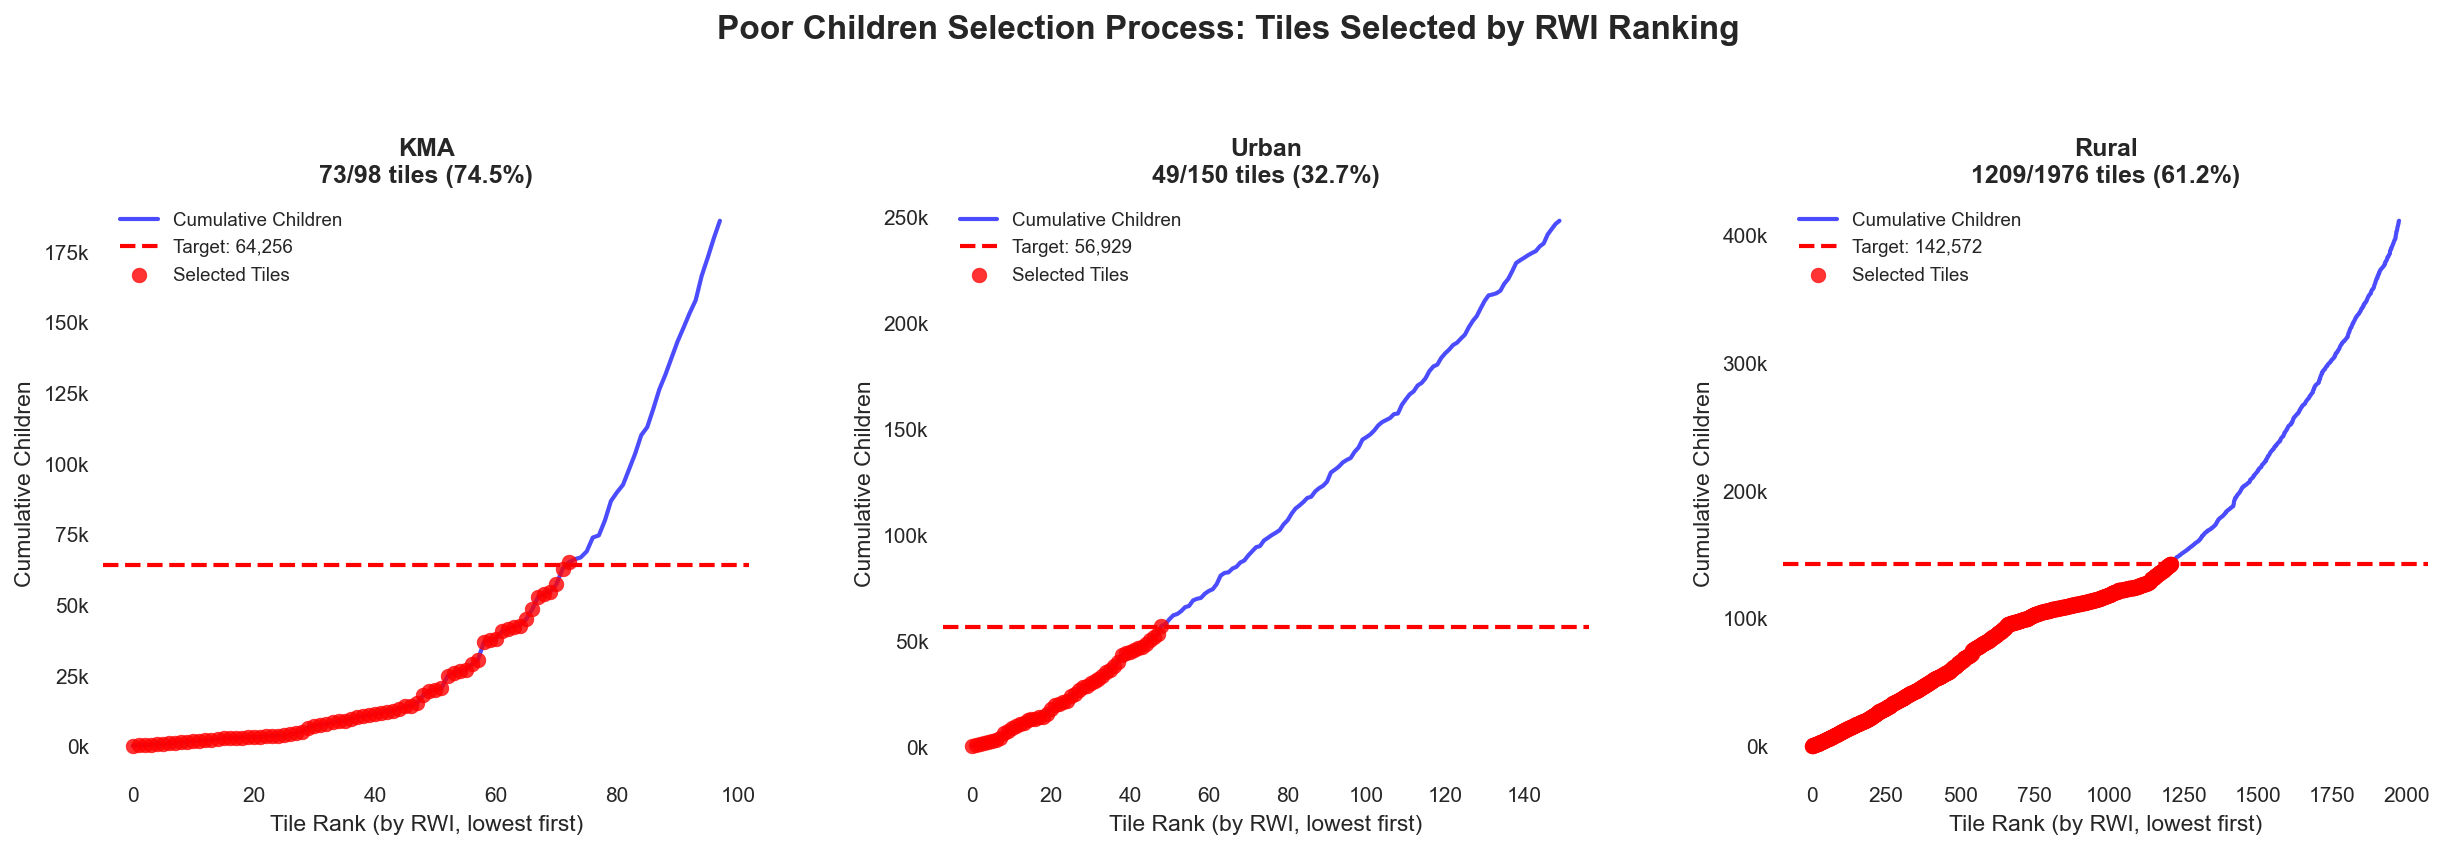

In [12]:
# Create visualization showing selection process for each classification
fig = plt.figure(figsize=(20, 12))
from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.3)

for idx, classification in enumerate(['KMA', 'Urban', 'Rural']):
    ax = fig.add_subplot(gs[idx // 3, idx % 3])

    classification_tiles = gdf_poorest[gdf_poorest['area_classification'] == classification].copy()
    classification_tiles = classification_tiles.sort_values(by='rwi', ascending=True)

    # Get poverty rate
    if classification == 'KMA':
        poverty_rate = POVERTY_RATE_KMA / 100
    elif classification == 'Urban':
        poverty_rate = POVERTY_RATE_URBAN / 100
    elif classification == 'Rural':
        poverty_rate = POVERTY_RATE_RURAL / 100

    target = classification_targets[classification]

    # Calculate cumulative
    classification_tiles['cumulative_children'] = classification_tiles['children_population'].cumsum()
    classification_tiles['is_selected'] = classification_tiles.index.isin(
        gdf_poorest[gdf_poorest['is_poorest']].index
    )

    # Plot cumulative children
    x = range(len(classification_tiles))
    ax.plot(x, classification_tiles['cumulative_children'].values,
           'b-', linewidth=2, alpha=0.7, label='Cumulative Children')
    ax.axhline(y=target, color='red', linestyle='--', linewidth=2,
              label=f'Target: {target:,.0f}')

    # Highlight selected tiles
    selected_indices = classification_tiles[classification_tiles['is_selected']].index
    selected_positions = [i for i, idx in enumerate(classification_tiles.index) if idx in selected_indices]
    if selected_positions:
        selected_cumulative = classification_tiles.loc[selected_indices, 'cumulative_children'].values
        ax.scatter(selected_positions, selected_cumulative, color='red', s=50, zorder=5,
                  alpha=0.8, label='Selected Tiles')

    selected_count = classification_tiles['is_selected'].sum()
    total_count = len(classification_tiles)

    ax.set_xlabel('Tile Rank (by RWI, lowest first)', fontsize=11)
    ax.set_ylabel('Cumulative Children', fontsize=11)
    ax.set_title(f'{classification}\n{selected_count}/{total_count} tiles ({selected_count/total_count*100:.1f}%)',
                fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}k'))

plt.suptitle('Poor Children Selection Process: Tiles Selected by RWI Ranking',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## Combined RWI Distribution and Children Accumulation Visualization


Urban
  Saved: analysis_output/visualizations/combined_view_rwi_distribution__children_accumulation_urban_both_metrics_normalized_to_0-1_scale_for_direct_comparison.png


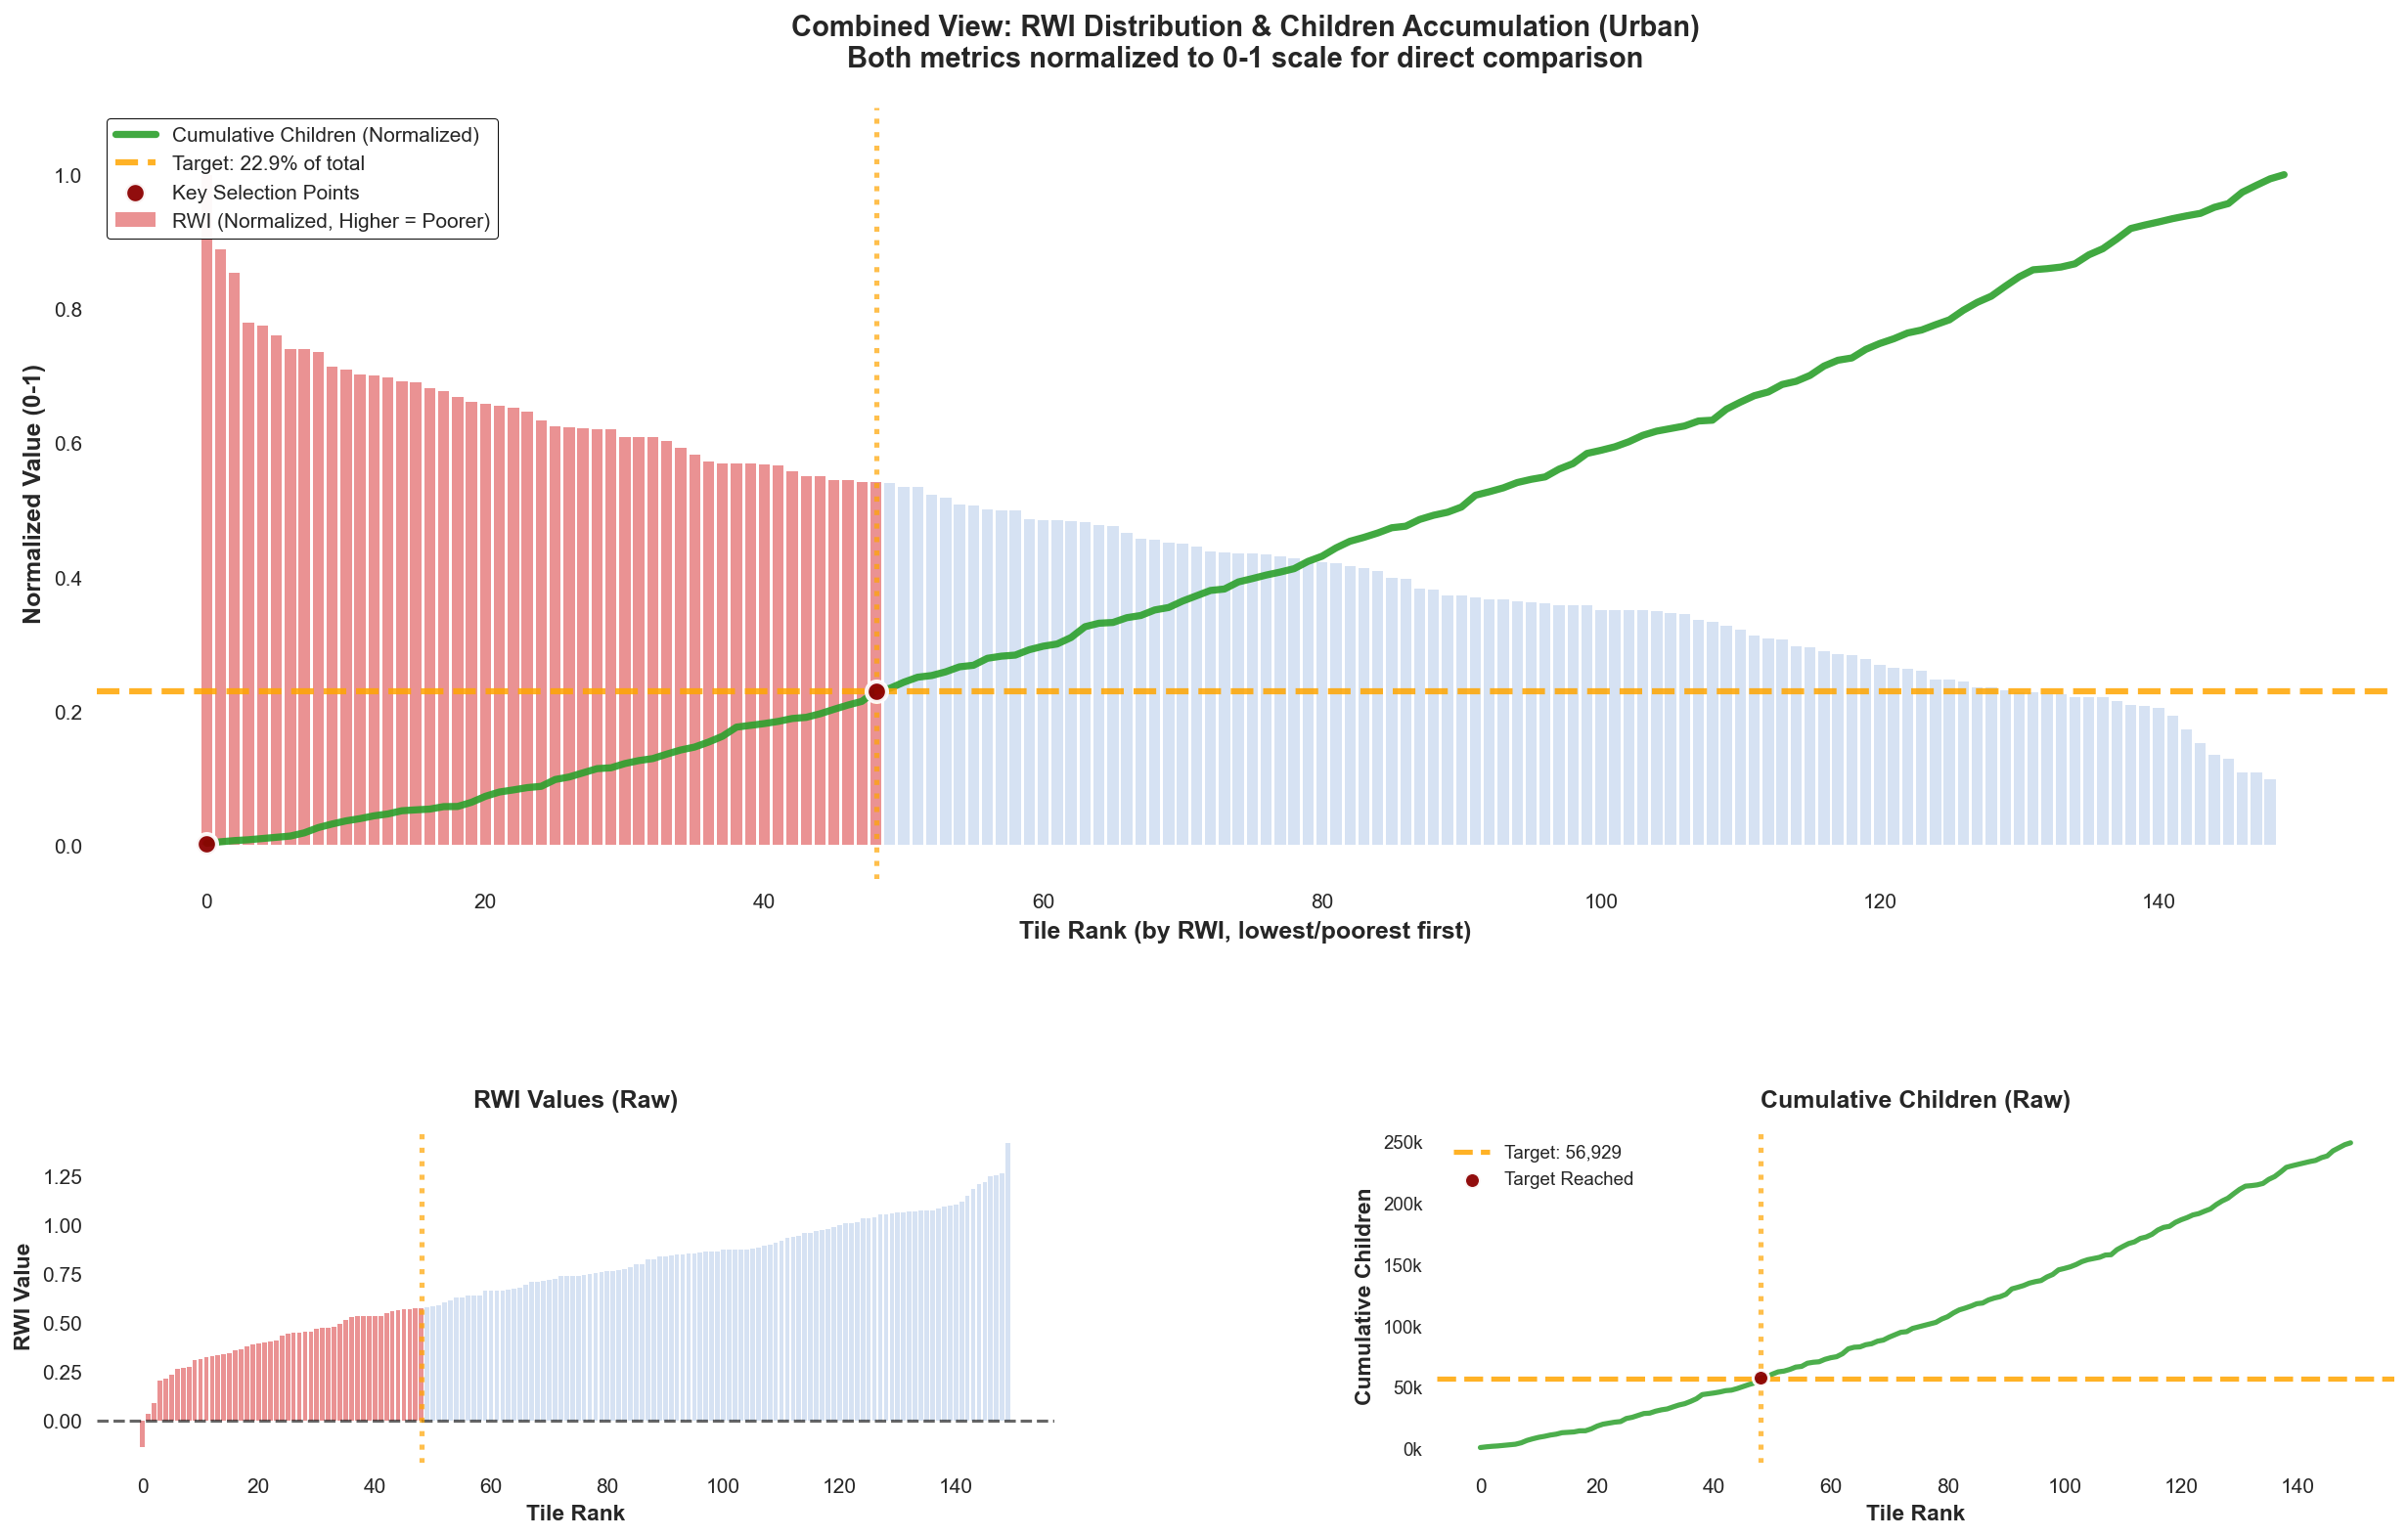

Rural
  Saved: analysis_output/visualizations/combined_view_rwi_distribution__children_accumulation_rural_both_metrics_normalized_to_0-1_scale_for_direct_comparison.png


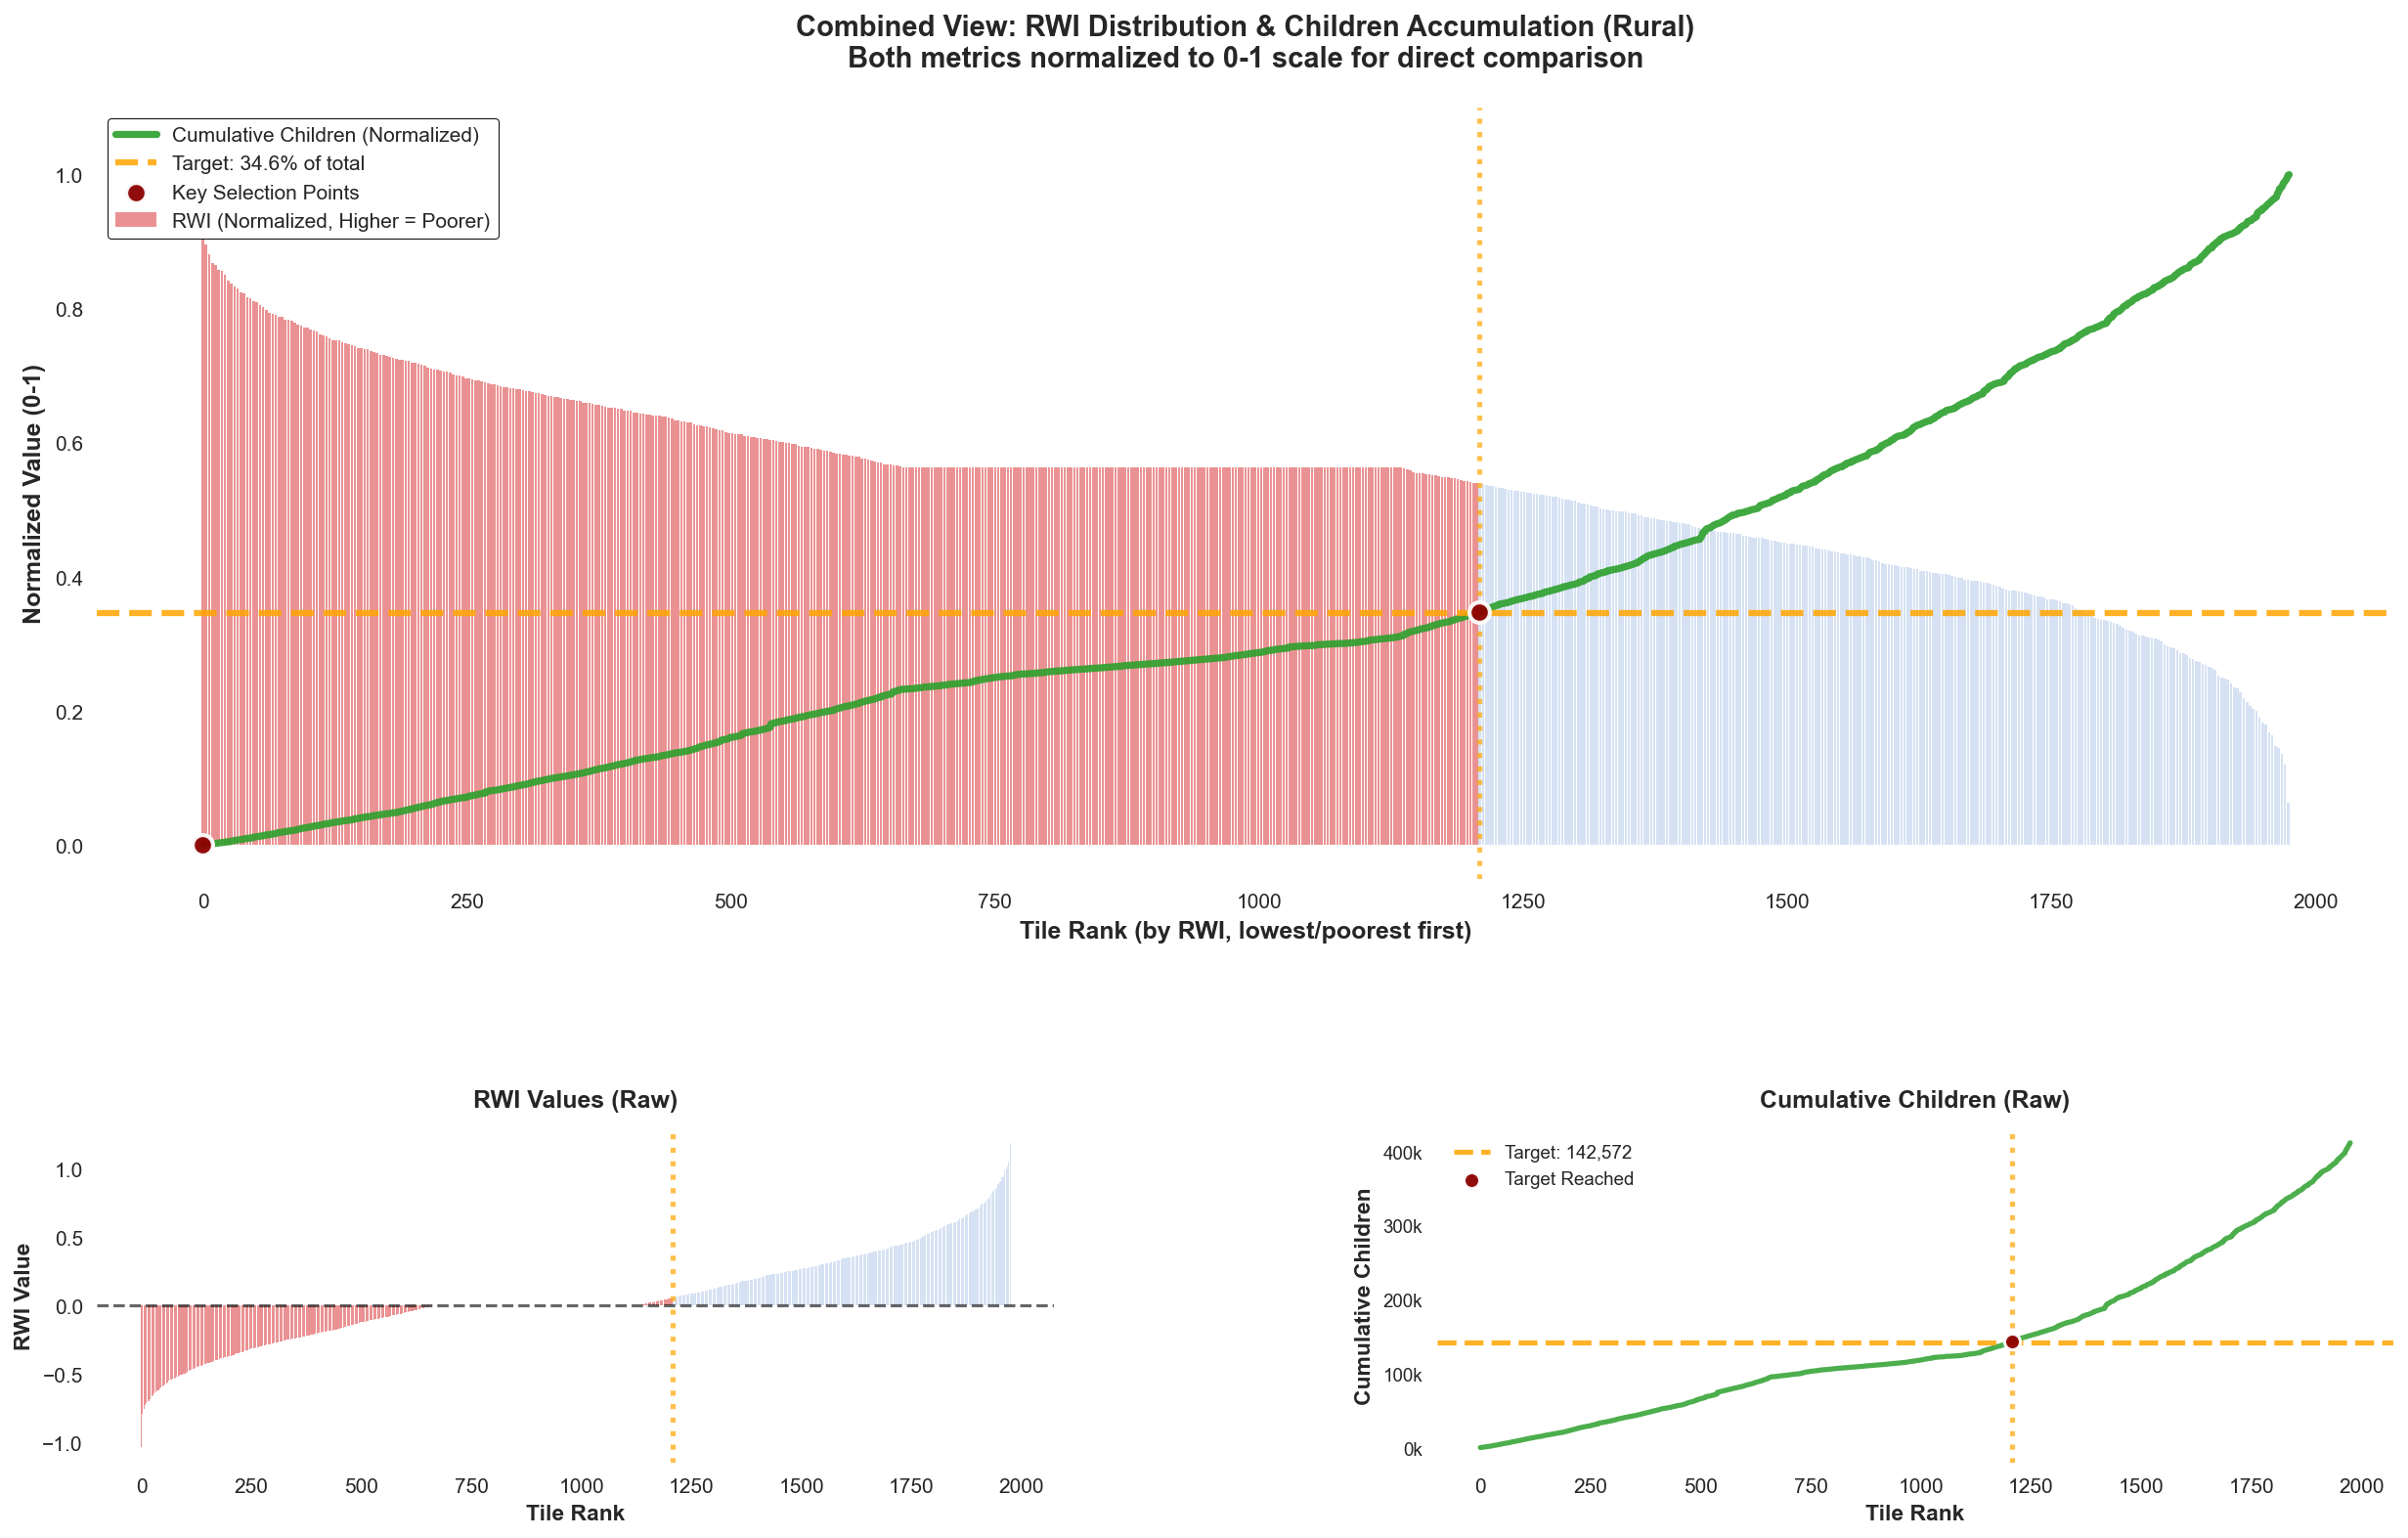

KMA
  Saved: analysis_output/visualizations/combined_view_rwi_distribution__children_accumulation_kma_both_metrics_normalized_to_0-1_scale_for_direct_comparison.png


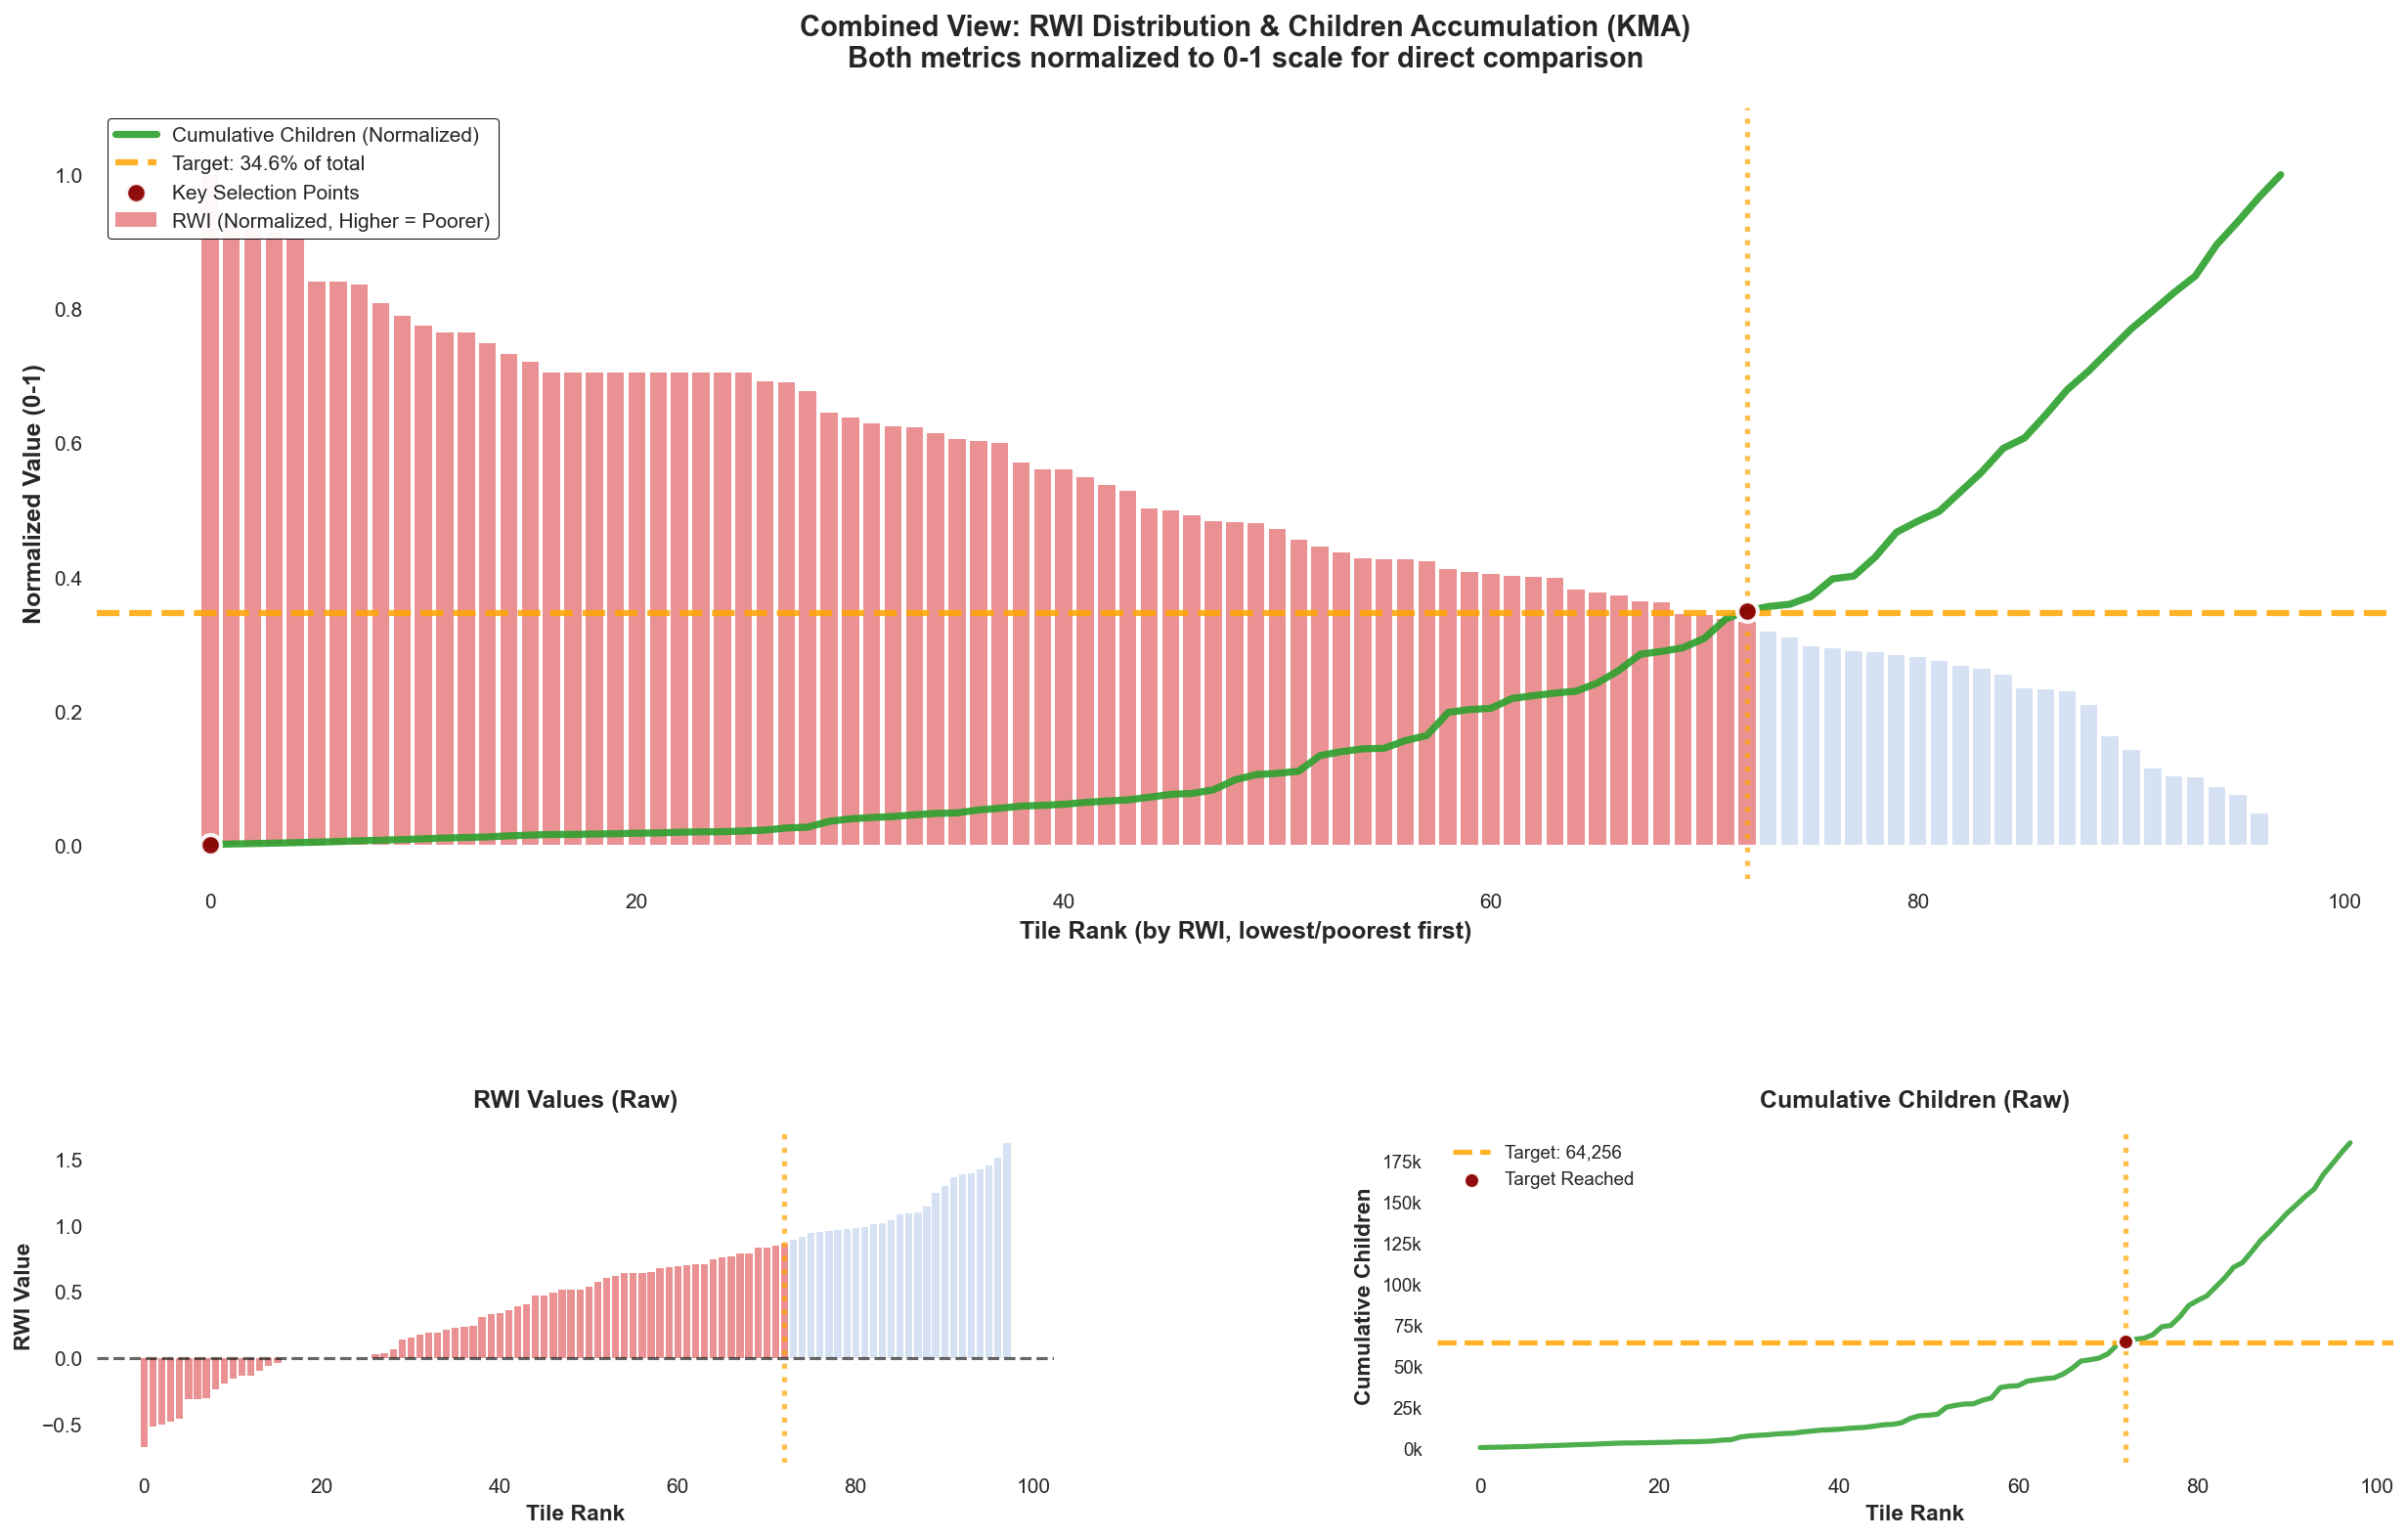

In [13]:
# Create combined visualization for each classification with normalized values
for DEMO_CLASSIFICATION in ['Urban', 'Rural', 'KMA']:
    print(f"{DEMO_CLASSIFICATION}")

    # Get data for the demo classification
    classification_tiles = gdf_poorest[gdf_poorest['area_classification'] == DEMO_CLASSIFICATION].copy()
    
    if len(classification_tiles) == 0:
        print(f"No tiles found for {DEMO_CLASSIFICATION}")
        continue
    
    # Sort by RWI (ascending - lowest first)
    classification_tiles_sorted = classification_tiles.sort_values(by='rwi', ascending=True).copy()
    classification_tiles_sorted['tile_rank'] = range(len(classification_tiles_sorted))
    
    # Calculate cumulative children
    classification_tiles_sorted['cumulative_children'] = classification_tiles_sorted['children_population'].cumsum()
    
    # Get target
    target_poor_children = classification_targets[DEMO_CLASSIFICATION]
    total_children = classification_tiles_sorted['children_population'].sum()
    
    # Identify which tiles are selected
    classification_tiles_sorted['is_selected'] = classification_tiles_sorted['is_poorest']
    
    # Normalize values to 0-1 scale for comparison
    rwi_min = classification_tiles_sorted['rwi'].min()
    rwi_max = classification_tiles_sorted['rwi'].max()
    rwi_range = rwi_max - rwi_min if rwi_max != rwi_min else 1
    
    # Normalize RWI: map from [rwi_min, rwi_max] to [0, 1] (inverted so lower RWI = higher normalized value)
    classification_tiles_sorted['rwi_normalized'] = 1 - (classification_tiles_sorted['rwi'] - rwi_min) / rwi_range
    
    # Normalize cumulative children: map from [0, total_children] to [0, 1]
    classification_tiles_sorted['cumulative_children_normalized'] = classification_tiles_sorted['cumulative_children'] / total_children if total_children > 0 else 0
    
    # Normalize target
    target_normalized = target_poor_children / total_children if total_children > 0 else 0
    
    # Create figure with subplots - increased spacing to reduce overlap
    fig = plt.figure(figsize=(18, 11))
    gs = fig.add_gridspec(2, 2, hspace=0.45, wspace=0.4, height_ratios=[2.3, 1], 
                         left=0.08, right=0.95, top=0.92, bottom=0.08)
    
    # Main plot: Normalized RWI and Cumulative Children
    ax_main = fig.add_subplot(gs[0, :])
    
    selected_mask = classification_tiles_sorted['is_selected']
    
    # Use bars but with thinner width and sampling for large datasets to reduce overlap
    colors = ['#d62728' if sel else '#aec7e8' for sel in selected_mask]
    
    # For large datasets, sample bars to reduce visual clutter
    total_tiles = len(classification_tiles_sorted)
    if total_tiles > 500:
        # Sample every Nth bar for display
        sample_step = max(1, total_tiles // 500)
        sampled_ranks = classification_tiles_sorted['tile_rank'].iloc[::sample_step]
        sampled_rwi_norm = classification_tiles_sorted['rwi_normalized'].iloc[::sample_step]
        sampled_colors = [colors[i] for i in range(0, len(colors), sample_step)]
        bar_width = sample_step * 0.8
    else:
        sampled_ranks = classification_tiles_sorted['tile_rank']
        sampled_rwi_norm = classification_tiles_sorted['rwi_normalized']
        sampled_colors = colors
        bar_width = 0.8
    
    ax_main.bar(sampled_ranks, sampled_rwi_norm,
                color=sampled_colors, alpha=0.5, width=bar_width, 
                label='RWI (Normalized, Higher = Poorer)', zorder=1)
    
    # Plot normalized cumulative children as line
    ax_main.plot(classification_tiles_sorted['tile_rank'], 
                classification_tiles_sorted['cumulative_children_normalized'],
                color='#2ca02c', linewidth=3.5, alpha=0.9, label='Cumulative Children (Normalized)', zorder=5)
    
    # Add target line
    ax_main.axhline(y=target_normalized, color='orange', linestyle='--', linewidth=3, 
                   alpha=0.85, label=f'Target: {target_normalized:.1%} of total', zorder=6)
    
    # Highlight only key points on the cumulative line to reduce overlap
    selected_indices = classification_tiles_sorted[selected_mask]['tile_rank'].values
    target_reached_idx = None
    if len(selected_indices) > 0:
        target_reached_idx = selected_indices[-1]
        target_reached_cumulative = classification_tiles_sorted.iloc[target_reached_idx]['cumulative_children_normalized']
        
        # Only show key points: first selected, target intersection
        key_indices = [selected_indices[0], target_reached_idx]
        key_indices = sorted(set(key_indices))
        
        key_cumulative = classification_tiles_sorted.iloc[key_indices]['cumulative_children_normalized'].values
        ax_main.scatter(key_indices, key_cumulative, 
                       color='darkred', s=100, zorder=8, alpha=0.95, 
                       label='Key Selection Points', marker='o', edgecolors='white', linewidths=2)
        
        # Add vertical line at target reached
        ax_main.axvline(x=target_reached_idx, color='orange', linestyle=':', linewidth=2.5, 
                      alpha=0.7, zorder=4)
    
    ax_main.set_xlabel('Tile Rank (by RWI, lowest/poorest first)', fontsize=12, fontweight='bold')
    ax_main.set_ylabel('Normalized Value (0-1)', fontsize=12, fontweight='bold')
    ax_main.set_title(f'Combined View: RWI Distribution & Children Accumulation ({DEMO_CLASSIFICATION})\n' +
                      f'Both metrics normalized to 0-1 scale for direct comparison', 
                     fontsize=14, fontweight='bold', pad=20)
    ax_main.grid(True, alpha=0.3, axis='y', linestyle='--')
    # Fix legend - remove invalid linewidth parameter
    legend = ax_main.legend(loc='upper left', fontsize=10, framealpha=0.95, frameon=True, edgecolor='black')
    legend.get_frame().set_linewidth(0.5)
    ax_main.set_ylim(-0.05, 1.1)
    
    # Bottom left: RWI distribution (raw values) - use bars with sampling
    ax_rwi = fig.add_subplot(gs[1, 0])
    
    # Use same sampling as main plot
    if total_tiles > 500:
        sampled_rwi = classification_tiles_sorted['rwi'].iloc[::sample_step]
    else:
        sampled_rwi = classification_tiles_sorted['rwi']
    
    ax_rwi.bar(sampled_ranks, sampled_rwi,
               color=sampled_colors, alpha=0.5, width=bar_width)
    
    ax_rwi.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.6, zorder=3)
    
    if target_reached_idx is not None:
        ax_rwi.axvline(x=target_reached_idx, color='orange', linestyle=':', linewidth=2.5, 
                      alpha=0.7, zorder=4)
    
    ax_rwi.set_xlabel('Tile Rank', fontsize=11, fontweight='bold')
    ax_rwi.set_ylabel('RWI Value', fontsize=11, fontweight='bold')
    ax_rwi.set_title('RWI Values (Raw)', fontsize=12, fontweight='bold', pad=10)
    ax_rwi.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    # Bottom right: Cumulative children (raw values)
    ax_children = fig.add_subplot(gs[1, 1])
    ax_children.plot(classification_tiles_sorted['tile_rank'], 
                    classification_tiles_sorted['cumulative_children'],
                    color='#2ca02c', linewidth=2.5, alpha=0.85, zorder=2)
    ax_children.axhline(y=target_poor_children, color='orange', linestyle='--', 
                       linewidth=2.5, alpha=0.85, label=f'Target: {target_poor_children:,.0f}', zorder=3)
    
    if target_reached_idx is not None:
        target_reached_cumulative = classification_tiles_sorted.iloc[target_reached_idx]['cumulative_children']
        # Only show key point at target intersection
        ax_children.scatter([target_reached_idx], [target_reached_cumulative], 
                           color='darkred', s=60, zorder=5, alpha=0.95, marker='o', 
                           edgecolors='white', linewidths=1.5, label='Target Reached')
        ax_children.axvline(x=target_reached_idx, color='orange', linestyle=':', 
                           linewidth=2.5, alpha=0.7, zorder=4)
    
    ax_children.set_xlabel('Tile Rank', fontsize=11, fontweight='bold')
    ax_children.set_ylabel('Cumulative Children', fontsize=11, fontweight='bold')
    ax_children.set_title('Cumulative Children (Raw)', fontsize=12, fontweight='bold', pad=10)
    ax_children.tick_params(axis='y', labelsize=9)
    ax_children.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}k'))
    ax_children.grid(True, alpha=0.3, axis='y', linestyle='--')
    ax_children.legend(loc='best', fontsize=9, framealpha=0.9)
    
    # Add statistics text box - positioned to avoid overlap with legend and plot elements
    selected_count = selected_mask.sum()
    total_count = len(classification_tiles_sorted)
    children_selected = classification_tiles_sorted[selected_mask]['children_population'].sum()
    
    plt.tight_layout()
    plt.show()

## Per-Parish Visualizations


  Saved: analysis_output/visualizations/poorest_children_cells_by_parish_red__poorest_darker__lower_rwi.png


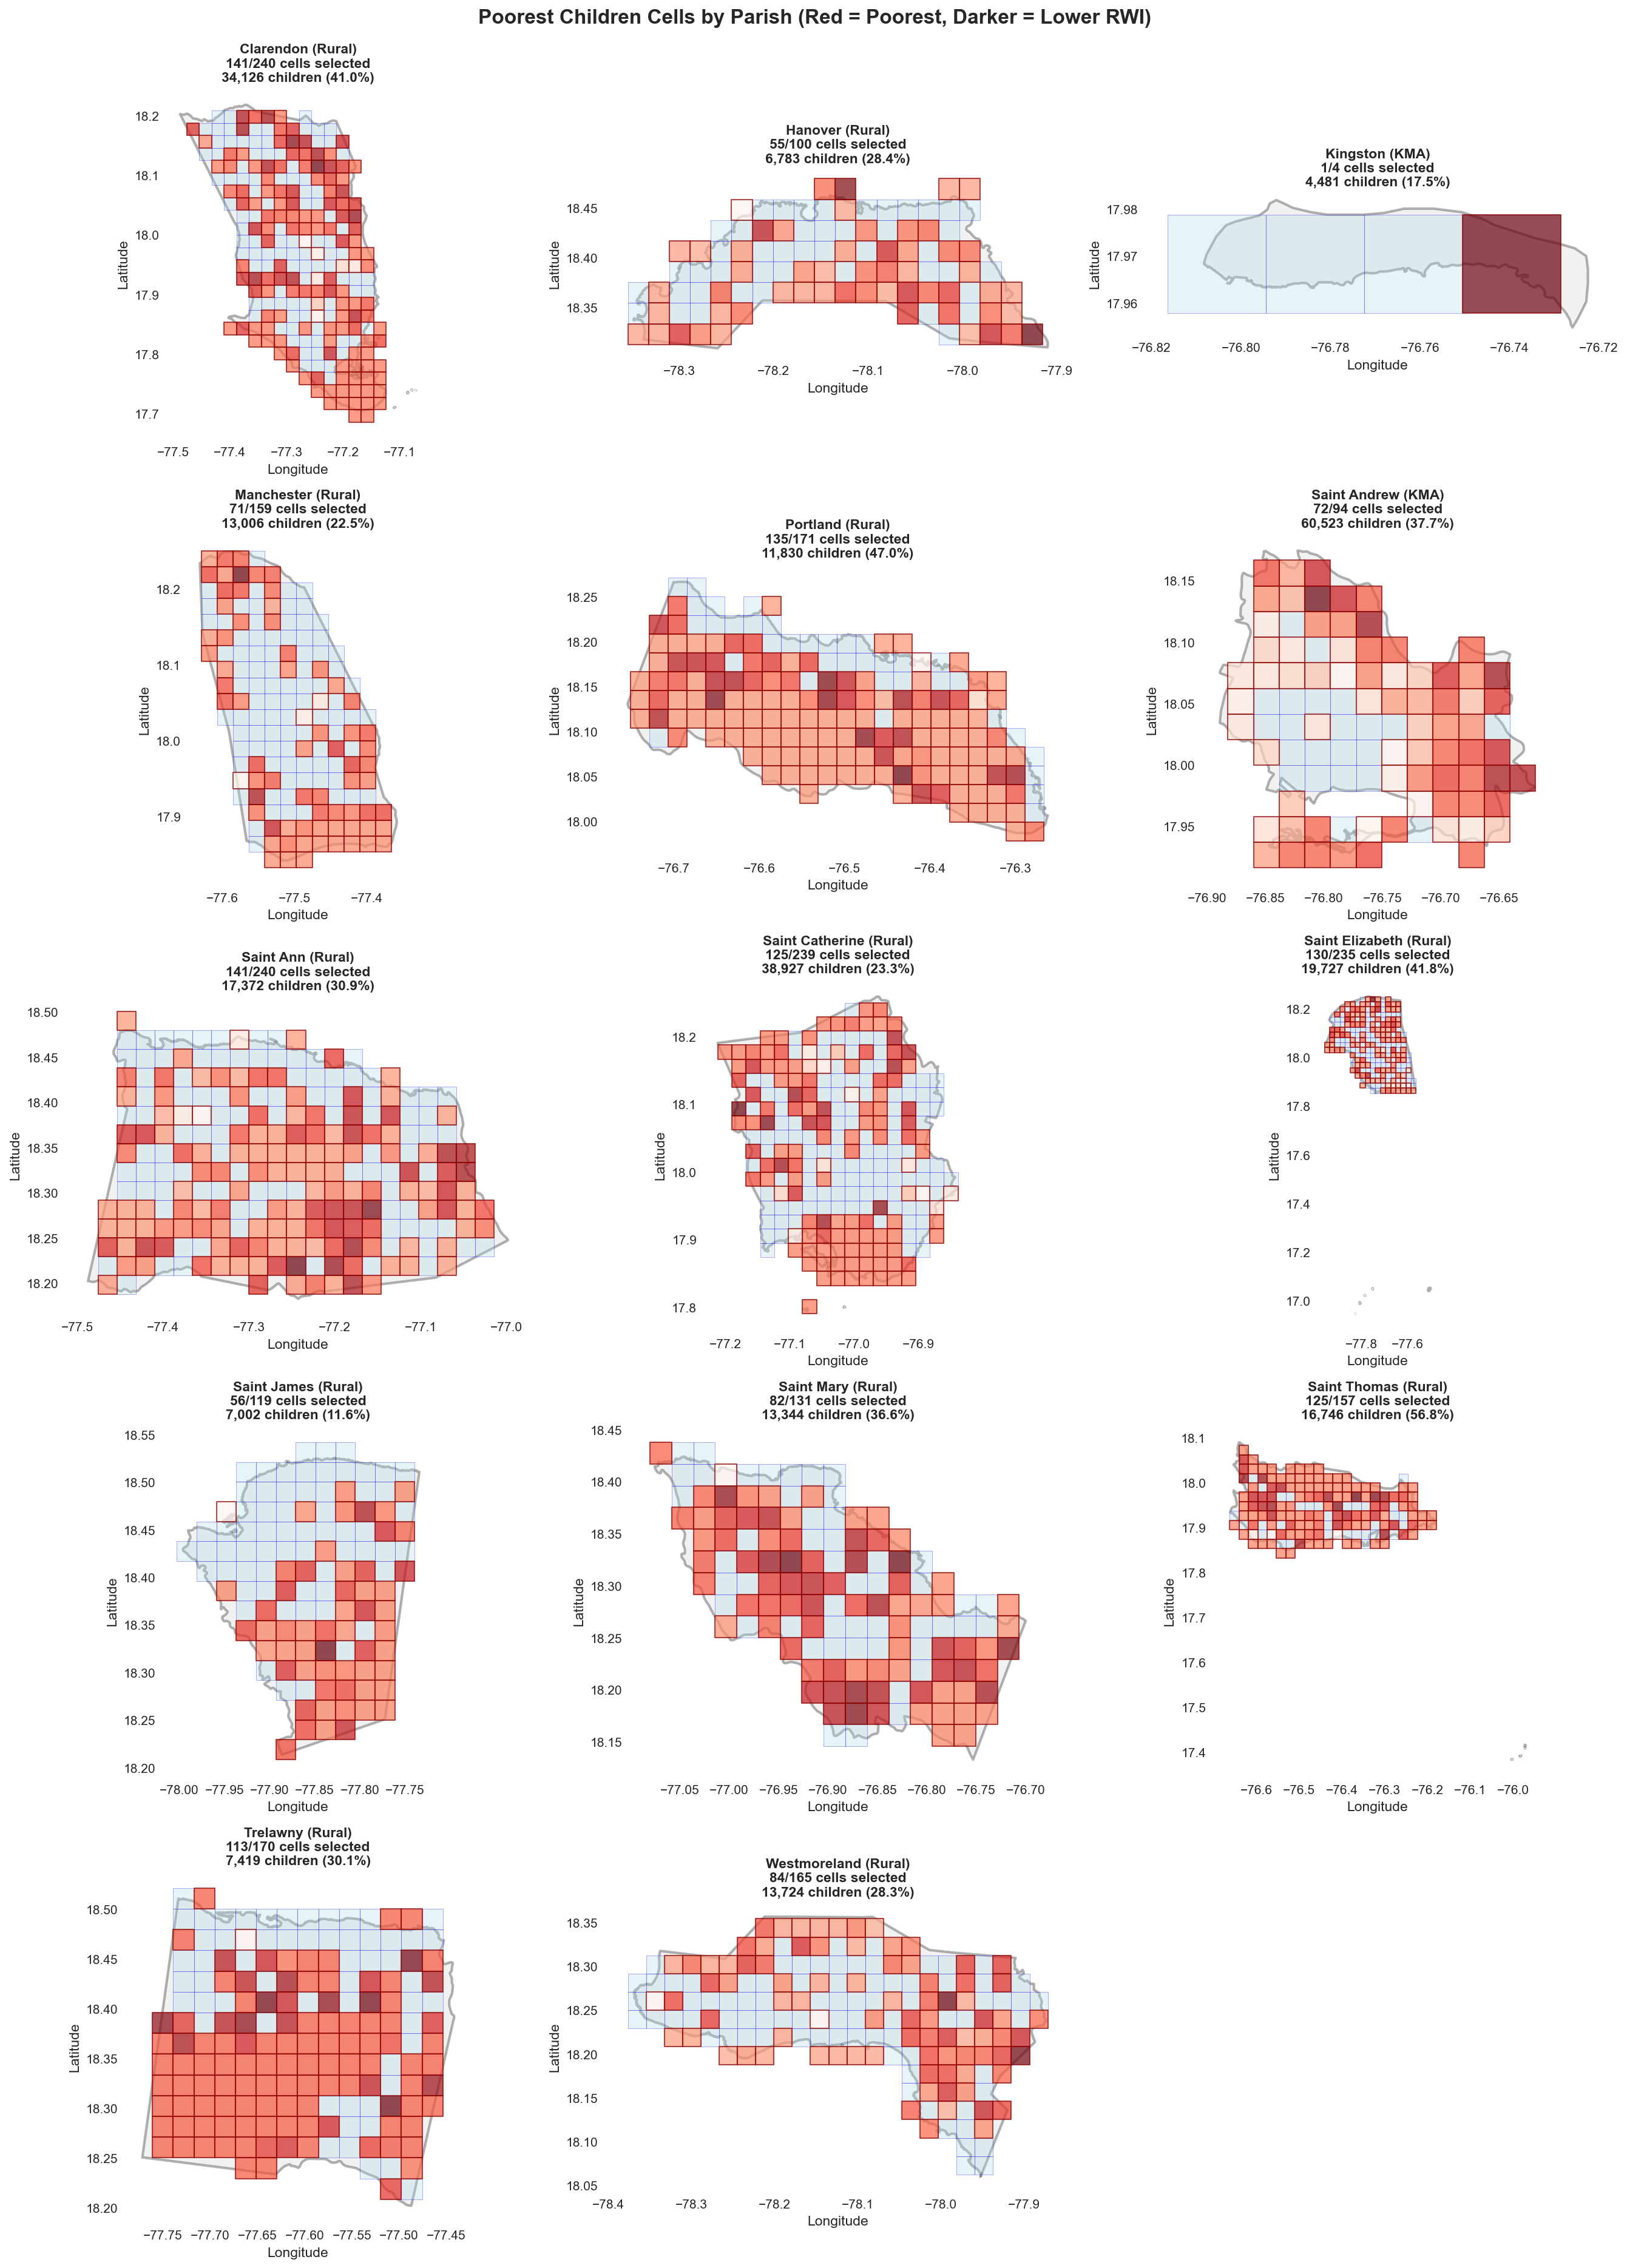

In [14]:
# Create individual visualizations for each parish
parishes_with_data = gdf_poorest[gdf_poorest['parish'].notna()]['parish'].unique()

# Filter to only parishes that have tiles
parishes_to_plot = [p for p in sorted(parishes_with_data) if len(gdf_poorest[gdf_poorest['parish'] == p]) > 0]

# Calculate how many plots per row (3-4 parishes per row)
parishes_per_row = 3
n_rows = (len(parishes_to_plot) + parishes_per_row - 1) // parishes_per_row

# Create figure with subplots
fig, axes = plt.subplots(n_rows, parishes_per_row, figsize=(6*parishes_per_row, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif parishes_per_row == 1:
    axes = axes.reshape(-1, 1)

axes = axes.flatten()

for idx, parish_name in enumerate(parishes_to_plot):
    ax = axes[idx]
    
    # Get parish admin boundary
    parish_admin = gdf_admin[gdf_admin['name'] == parish_name]
    
    # Get all tiles for this parish
    parish_all_tiles = gdf_poorest[gdf_poorest['parish'] == parish_name].copy()
    
    # Get poorest tiles
    parish_poorest = parish_all_tiles[parish_all_tiles['is_poorest']].copy()
    
    if len(parish_admin) > 0 and len(parish_all_tiles) > 0:
        # Plot parish boundary
        parish_admin.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=2, alpha=0.3, label='Parish Boundary')
        
        # Plot all tiles (non-poorest) in light blue
        non_poorest = parish_all_tiles[~parish_all_tiles['is_poorest']]
        if len(non_poorest) > 0:
            non_poorest.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.3, linewidth=0.5, label='Other Tiles')
        
        # Plot poorest tiles in red
        if len(parish_poorest) > 0:
            # Color by RWI for poorest tiles (darker red = lower RWI = poorer)
            parish_poorest.plot(ax=ax, column='rwi', cmap='Reds_r', edgecolor='darkred', 
                               linewidth=1, alpha=0.7, legend=False, label='Poorest Cells', 
                               vmin=parish_poorest['rwi'].min(), vmax=parish_poorest['rwi'].max())
        
        # Add title with statistics
        if len(parish_poorest) > 0:
            children_covered = parish_poorest['children_population'].sum()
            total_children = parish_all_tiles['children_population'].sum()
            coverage_pct = (children_covered / total_children * 100) if total_children > 0 else 0
            classification = parish_poorest['area_classification'].iloc[0] if len(parish_poorest) > 0 else parish_all_tiles['area_classification'].iloc[0]
            title = f"{parish_name} ({classification})\n{len(parish_poorest)}/{len(parish_all_tiles)} cells selected\n{children_covered:,.0f} children ({coverage_pct:.1f}%)"
        else:
            title = f"{parish_name}\nNo poorest cells identified"
        
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, f"No data for\n{parish_name}", 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(parish_name, fontsize=11, fontweight='bold')

# Hide unused subplots
for idx in range(len(parishes_to_plot), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Poorest Children Cells by Parish (Red = Poorest, Darker = Lower RWI)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## Expected Impacted Poor Children by Parish



Parish Impact Summary:
         parish  selected_tiles  children_in_selected
      Clarendon             141          34125.970062
        Hanover              55           6783.128959
       Kingston               1           4481.383774
     Manchester              71          13005.771297
       Portland             135          11829.746719
   Saint Andrew              72          60522.715248
      Saint Ann             141          17372.398459
Saint Catherine             125          38926.638267
Saint Elizabeth             130          19727.352165
    Saint James              56           7001.641774
     Saint Mary              82          13343.516888
   Saint Thomas             125          16745.502899
       Trelawny             113           7418.888927
   Westmoreland              84          13723.579457
  Saved: analysis_output/visualizations/expected_impacted_poor_children_by_parish_and_wind_threshold.png


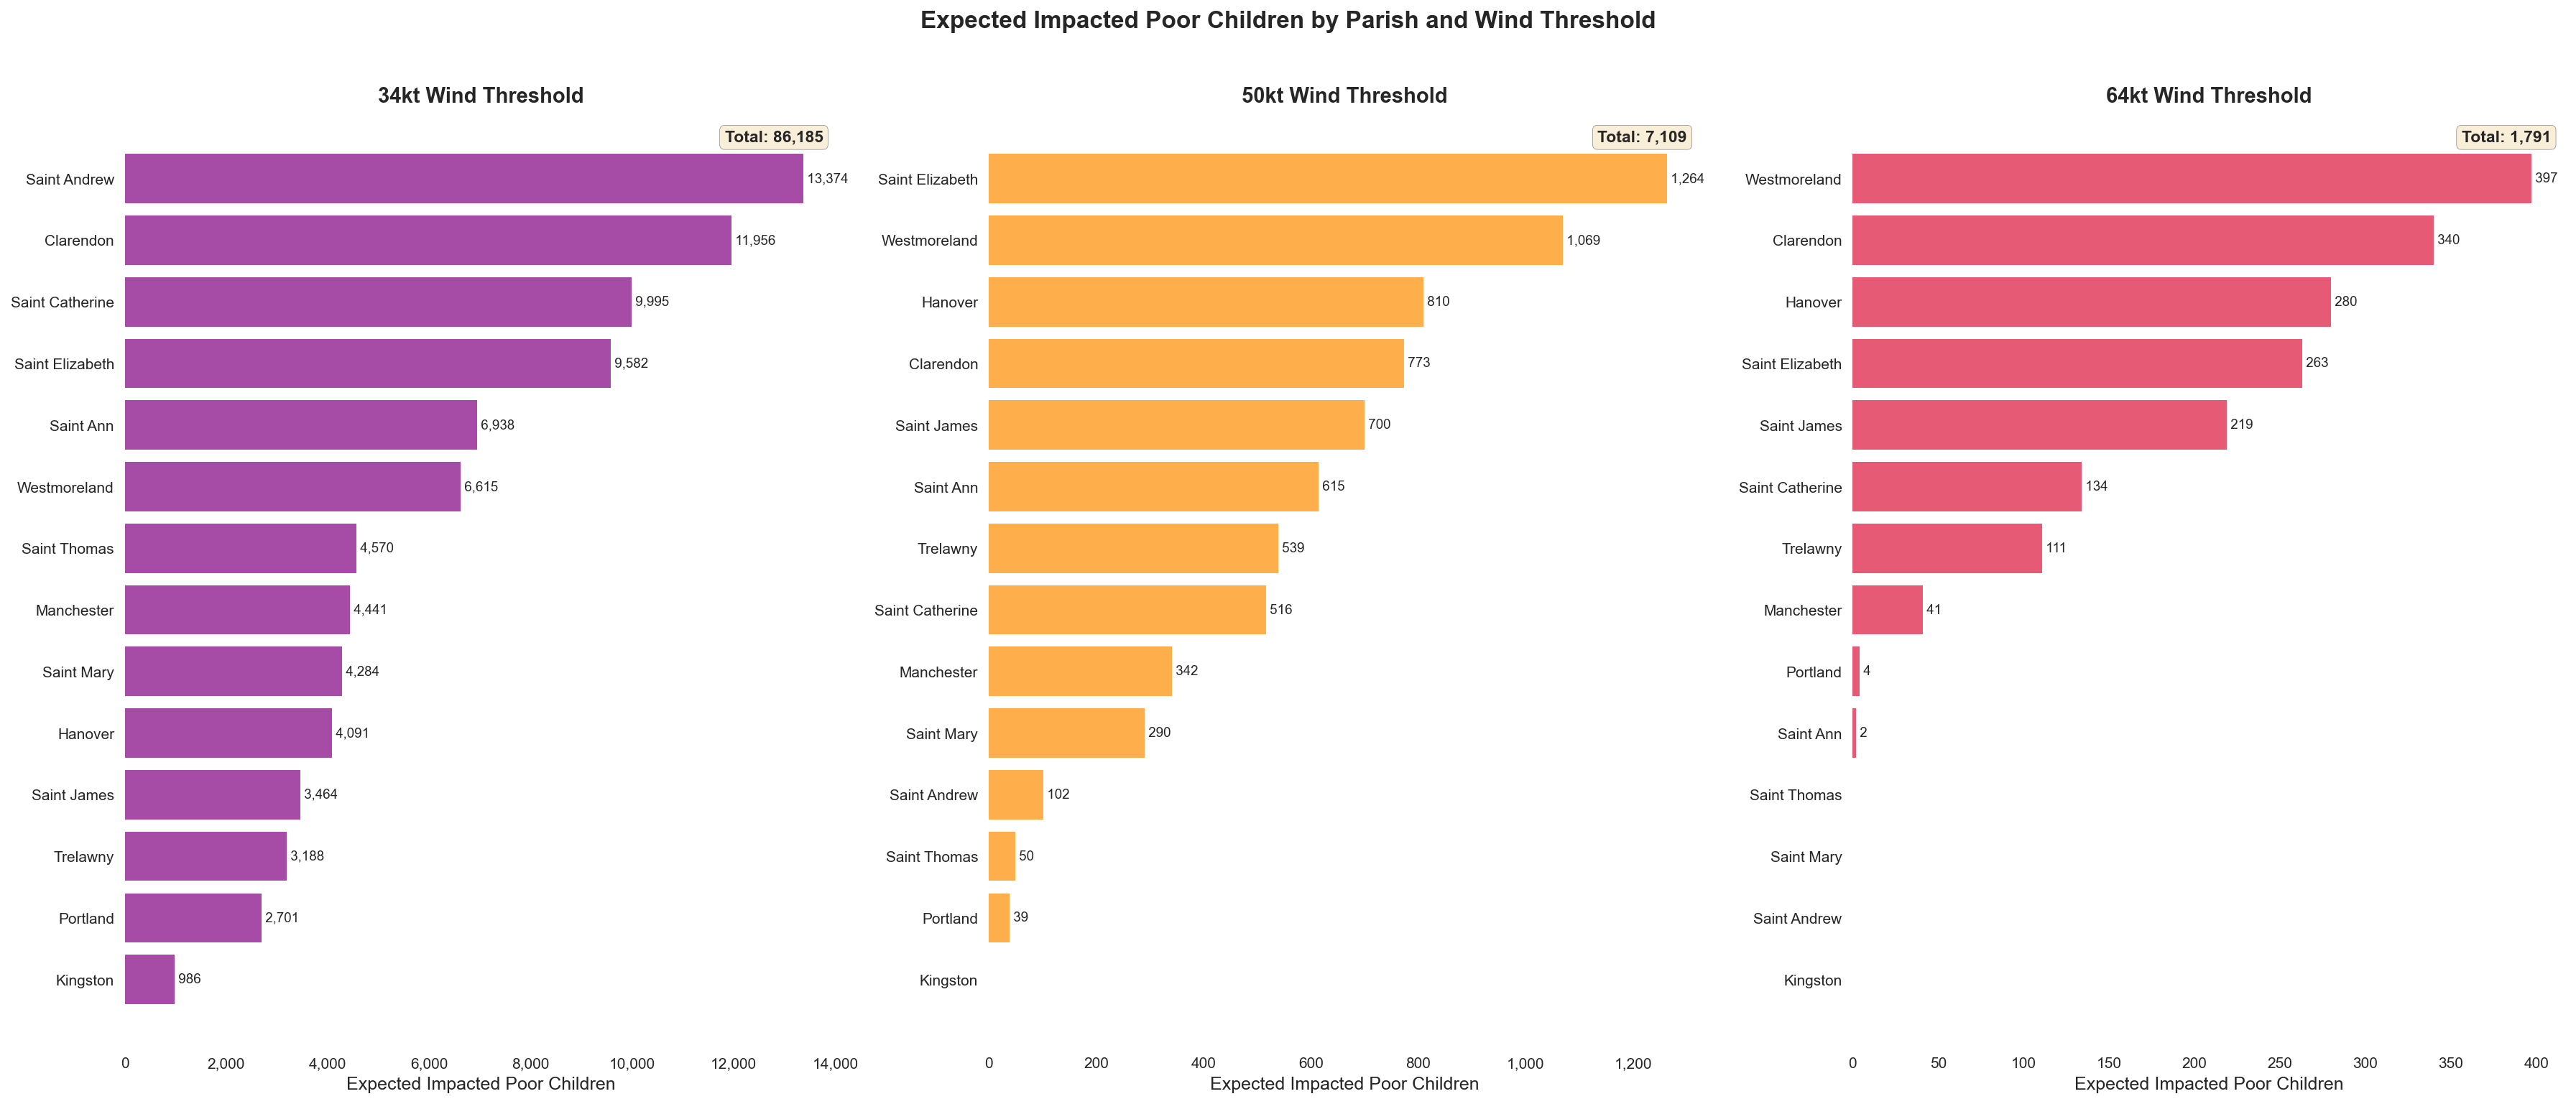

  Saved: analysis_output/visualizations/expected_impacted_poor_children_comparison_across_wind_thresholds_by_parish.png


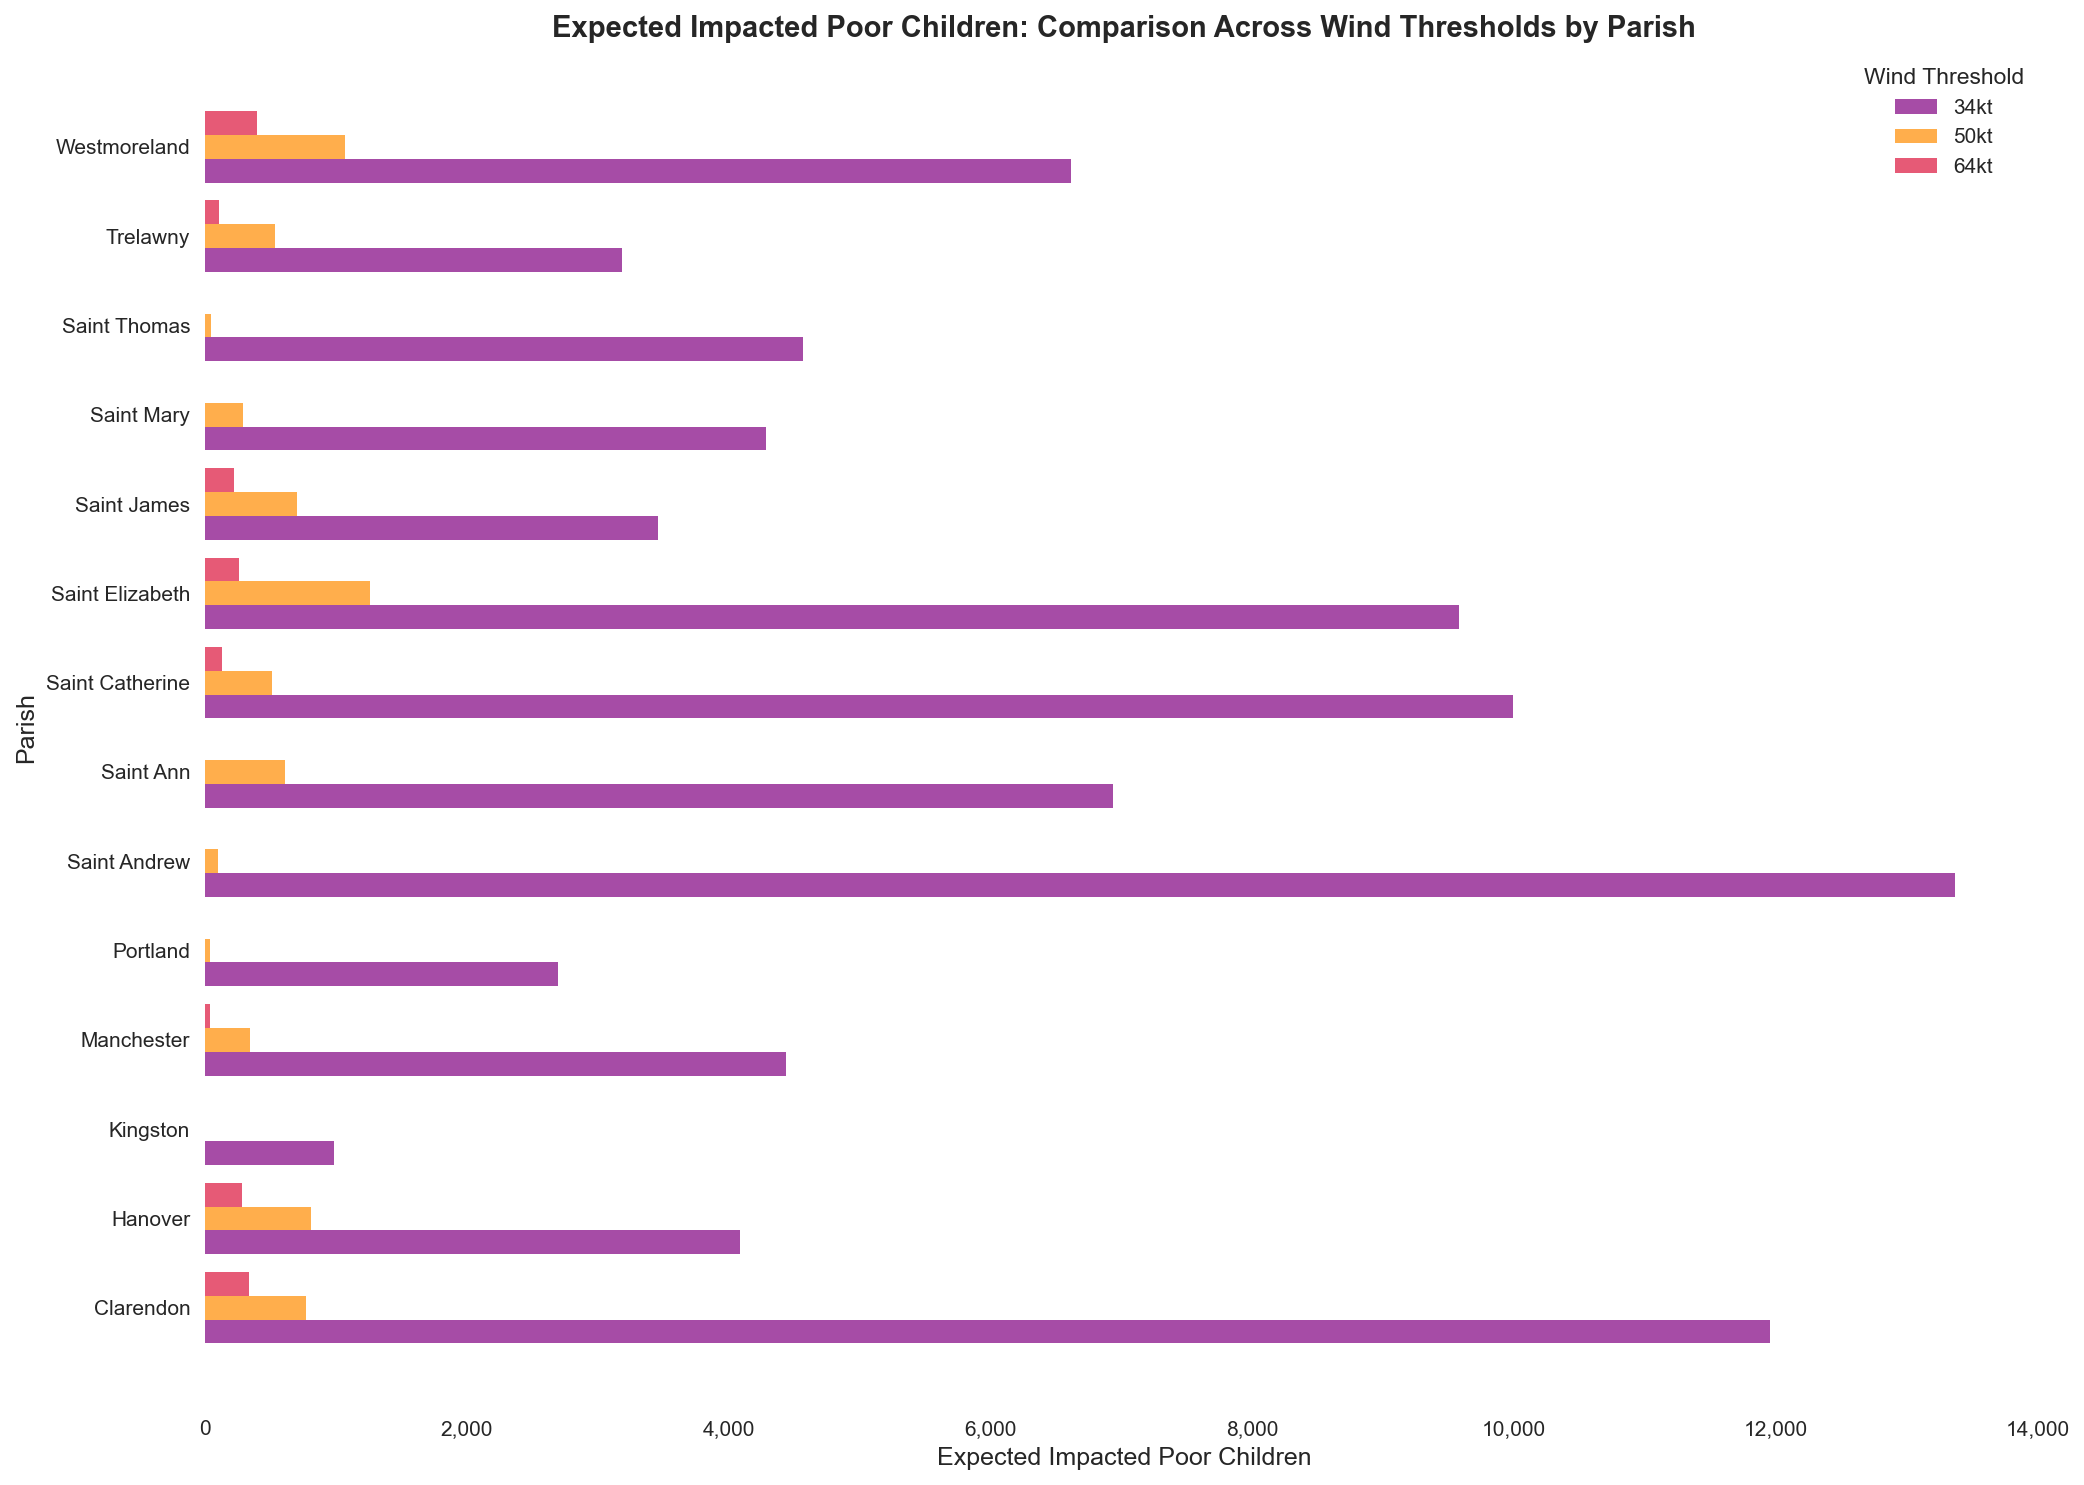

  Saved: analysis_output/visualizations/expected_impacted_poor_children_by_parish_map_view.png


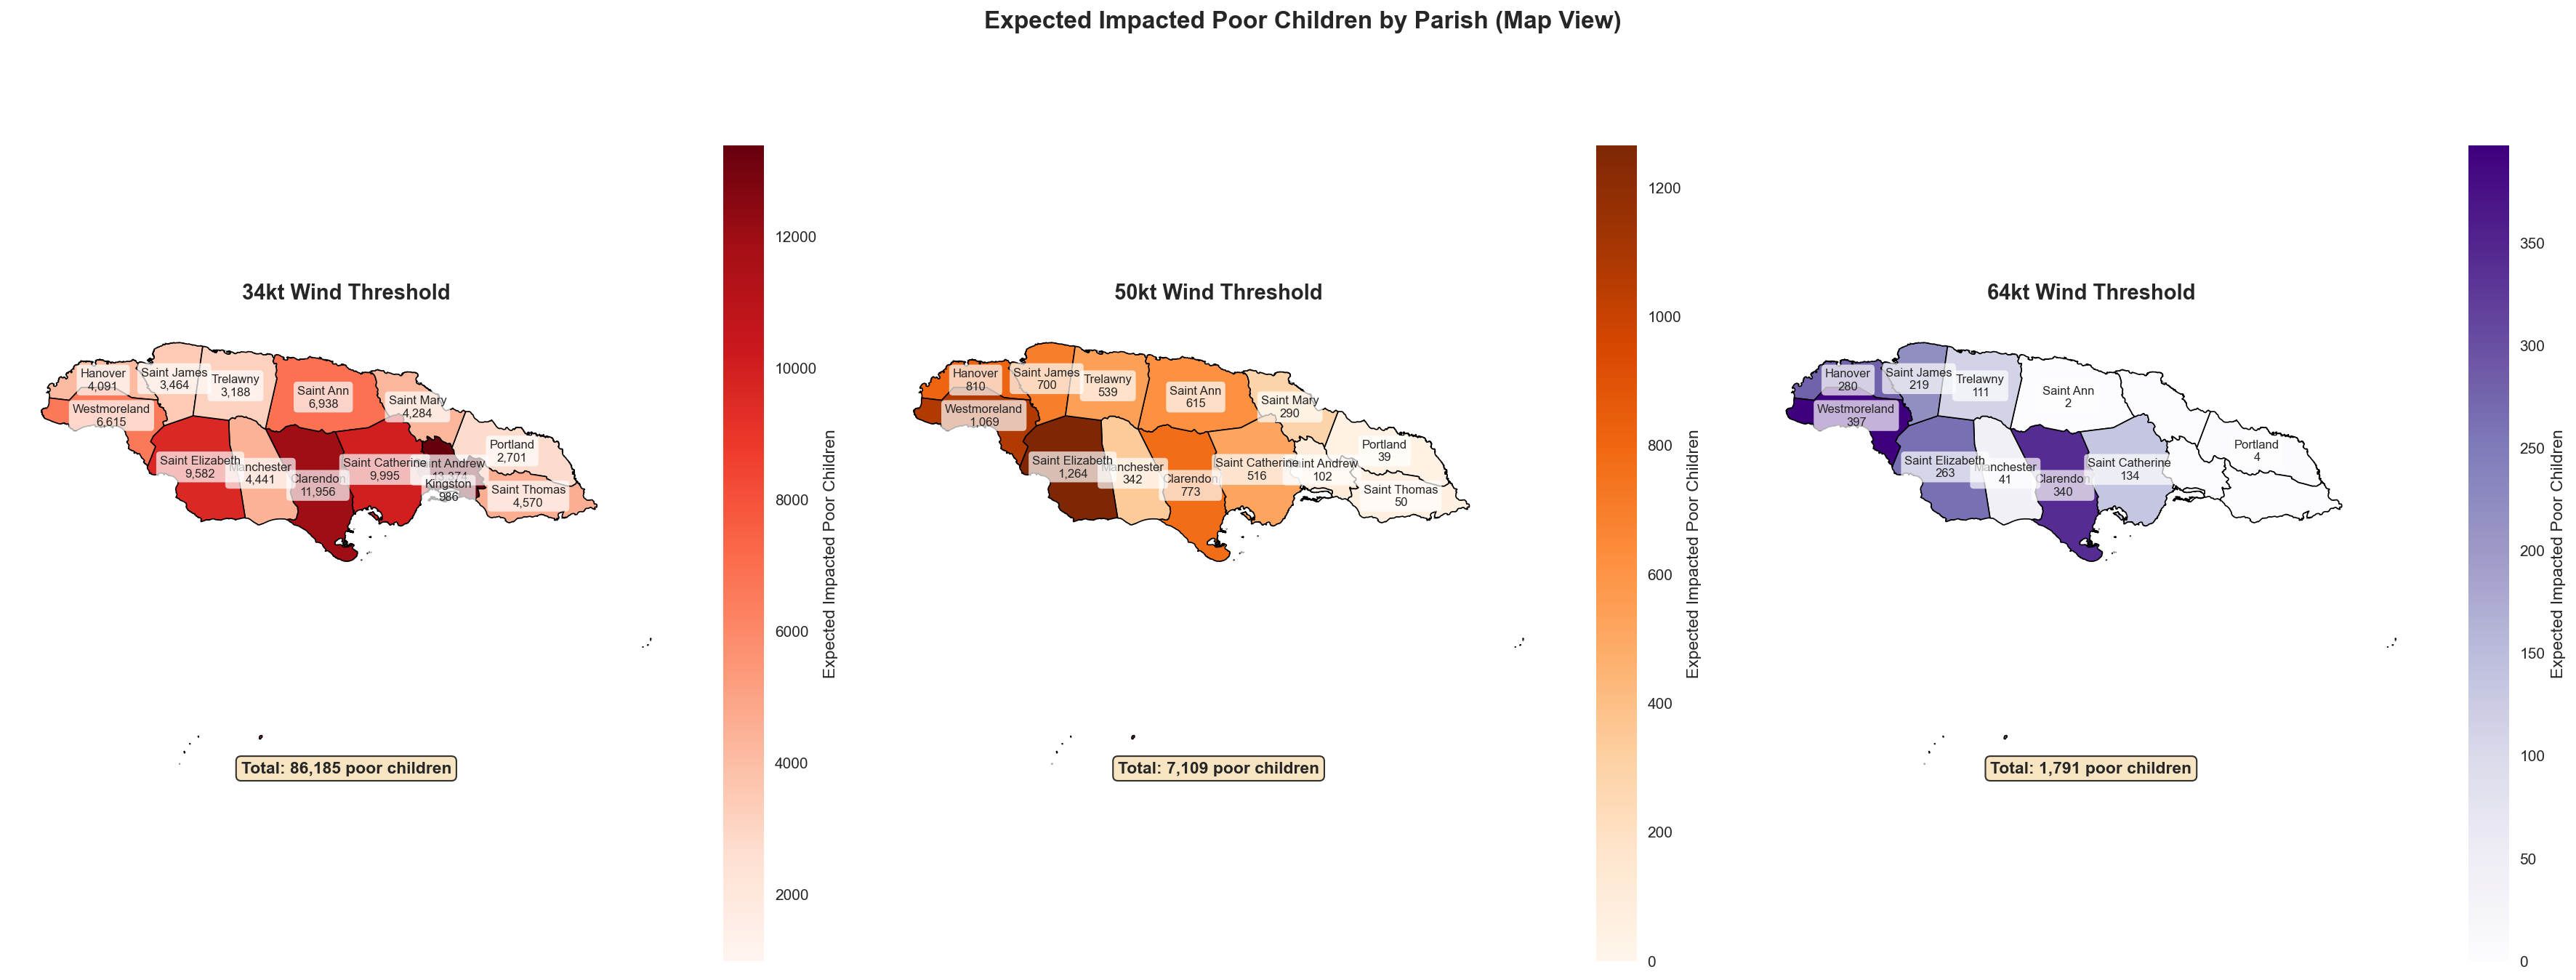

In [15]:
# Check if we have impact data (either from tile-level files or configured thresholds)
has_impact_data = (DATE and FORECAST_TIME and WIND_THRESHOLDS and STORM and 
                   any(f'potentially_impacted_poor_children_{wt}kt' in gdf_poorest.columns 
                       for wt in WIND_THRESHOLDS))

if has_impact_data:
    
    # Aggregate by parish
    parish_impact_summary = []
    
    for parish_name in sorted(gdf_poorest['parish'].unique()):
        parish_tiles = gdf_poorest[(gdf_poorest['parish'] == parish_name) & (gdf_poorest['is_poorest'])]
        
        if len(parish_tiles) > 0:
            row = {
                'parish': parish_name,
                'selected_tiles': len(parish_tiles),
                'children_in_selected': parish_tiles['children_population'].sum()
            }
            
            # Add impact data for each threshold
            for wind_threshold in WIND_THRESHOLDS:
                impact_col = f'potentially_impacted_poor_children_{wind_threshold}kt'
                if impact_col in parish_tiles.columns:
                    row[impact_col] = parish_tiles[impact_col].sum()
                else:
                    row[impact_col] = 0
            
            parish_impact_summary.append(row)
    
    df_parish_impact = pd.DataFrame(parish_impact_summary)
    
    print(f"\nParish Impact Summary:")
    print(df_parish_impact[['parish', 'selected_tiles', 'children_in_selected']].to_string(index=False))
    
    # Create visualizations per parish for each wind threshold
    impact_pop_cols = [col for col in df_parish_impact.columns if col.startswith('potentially_impacted_poor_children_')]
    
    if impact_pop_cols:
        # Determine layout based on number of thresholds
        n_thresholds = len(impact_pop_cols)
        
        if n_thresholds == 1:
            fig, axes = plt.subplots(1, 1, figsize=(14, 10))
            axes = [axes]
        elif n_thresholds == 2:
            fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        elif n_thresholds == 3:
            fig, axes = plt.subplots(1, 3, figsize=(24, 10))
        else:
            n_cols = 3
            n_rows = (n_thresholds + n_cols - 1) // n_cols
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 6*n_rows))
            axes = axes.flatten()
        
        colors = ['purple', 'darkorange', 'crimson', 'teal', 'navy', 'maroon']
        
        for idx, impact_col in enumerate(impact_pop_cols):
            ax = axes[idx]
            threshold = impact_col.replace('potentially_impacted_poor_children_', '').replace('kt', '')
            
            # Sort by impact poor children
            df_plot = df_parish_impact.sort_values(impact_col, ascending=True)
            
            # Create horizontal bar chart
            bars = ax.barh(df_plot['parish'], df_plot[impact_col], color=colors[idx % len(colors)], alpha=0.7)
            
            # Add value labels on bars
            for i, (bar, val) in enumerate(zip(bars, df_plot[impact_col])):
                if val > 0:
                    ax.text(val, i, f' {val:,.0f}', va='center', fontsize=9)
            
            ax.set_xlabel('Expected Impacted Poor Children', fontsize=12)
            ax.set_title(f'{threshold}kt Wind Threshold', fontsize=14, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
            
            # Add total at the top
            total = df_parish_impact[impact_col].sum()
            ax.text(0.98, 0.98, f'Total: {total:,.0f}', 
                   transform=ax.transAxes, ha='right', va='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=11, fontweight='bold')
        
        # Hide unused subplots
        for idx in range(n_thresholds, len(axes)):
            axes[idx].axis('off')
        
        plt.suptitle('Expected Impacted Poor Children by Parish and Wind Threshold',
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        
        # Create side-by-side comparison
        fig, ax = plt.subplots(figsize=(14, 10))
        
        parishes = df_parish_impact['parish'].values
        x = np.arange(len(parishes))
        width = 0.8 / n_thresholds
        
        for idx, impact_col in enumerate(impact_pop_cols):
            threshold = impact_col.replace('potentially_impacted_poor_children_', '').replace('kt', '')
            values = df_parish_impact[impact_col].values
            offset = (idx - (n_thresholds - 1) / 2) * width
            ax.barh(x + offset, values, width, label=f'{threshold}kt', 
                   color=colors[idx % len(colors)], alpha=0.7)
        
        ax.set_xlabel('Expected Impacted Poor Children', fontsize=12)
        ax.set_ylabel('Parish', fontsize=12)
        ax.set_title('Expected Impacted Poor Children: Comparison Across Wind Thresholds by Parish',
                    fontsize=14, fontweight='bold')
        ax.set_yticks(x)
        ax.set_yticklabels(parishes)
        ax.legend(title='Wind Threshold', fontsize=10, title_fontsize=11)
        ax.grid(axis='x', alpha=0.3)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
        
        plt.tight_layout()
        plt.show()


        
        # Create map visualizations for expected impacted poor children by parish (AGGREGATED)
        
        # Aggregate impact data by parish from tiles
        parish_impact_map = {}
        for wind_threshold in WIND_THRESHOLDS:
            impact_col = f'potentially_impacted_poor_children_{wind_threshold}kt'
            if impact_col in gdf_poorest.columns:
                parish_impact_map[impact_col] = gdf_poorest[gdf_poorest['is_poorest']].groupby('parish')[impact_col].sum().to_dict()
        
        # Create a DataFrame with parish impact data
        df_parish_impact_map = pd.DataFrame(parish_impact_map)
        df_parish_impact_map = df_parish_impact_map.reset_index()
        df_parish_impact_map = df_parish_impact_map.rename(columns={'index': 'parish'})
        
        # Join impact data to admin boundaries for mapping
        gdf_admin_impact = gdf_admin.merge(df_parish_impact_map, left_on='name', right_on='parish', how='left')
        
        # Determine layout based on number of thresholds
        if n_thresholds == 1:
            fig, axes = plt.subplots(1, 1, figsize=(12, 10))
            axes = [axes]
        elif n_thresholds == 2:
            fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        elif n_thresholds == 3:
            fig, axes = plt.subplots(1, 3, figsize=(24, 10))
        else:
            n_cols = 3
            n_rows = (n_thresholds + n_cols - 1) // n_cols
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(10*n_cols, 8*n_rows))
            axes = axes.flatten()
        
        colormaps = ['Reds', 'Oranges', 'Purples', 'Blues', 'Greens', 'YlOrRd']
        
        for idx, impact_col in enumerate(impact_pop_cols):
            ax = axes[idx]
            threshold = impact_col.replace('potentially_impacted_poor_children_', '').replace('kt', '')
            
            # Plot admin boundaries colored by potentially impacted poor children
            gdf_admin_impact.plot(
                ax=ax,
                column=impact_col,
                cmap=colormaps[idx % len(colormaps)],
                edgecolor='black',
                linewidth=0.8,
                legend=True,
                legend_kwds={
                    'label': 'Expected Impacted Poor Children',
                    'shrink': 0.8
                },
                missing_kwds={
                    'color': 'lightgray',
                    'edgecolor': 'black',
                    'hatch': '///',
                    'label': 'No data'
                }
            )
            
            # Add parish labels
            for idx_parish, row in gdf_admin_impact.iterrows():
                if pd.notna(row[impact_col]) and row[impact_col] > 0:
                    centroid = row.geometry.centroid
                    ax.text(
                        centroid.x, centroid.y,
                        f"{row['name']}\n{row[impact_col]:,.0f}",
                        ha='center', va='center',
                        fontsize=8,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
                    )
            
            ax.set_title(f'{threshold}kt Wind Threshold', fontsize=14, fontweight='bold', pad=15)
            ax.set_xlabel('Longitude', fontsize=11)
            ax.set_ylabel('Latitude', fontsize=11)
            ax.axis('off')
            
            # Add total at the bottom
            total = df_parish_impact[impact_col].sum()
            ax.text(0.5, 0.02, f'Total: {total:,.0f} poor children', 
                   transform=ax.transAxes, ha='center', va='bottom',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black', linewidth=1),
                   fontsize=11, fontweight='bold')
        
        # Hide unused subplots
        for idx in range(n_thresholds, len(axes)):
            axes[idx].axis('off')
        
        plt.suptitle('Expected Impacted Poor Children by Parish (Map View)',
                     fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.show()
        
    else:
        print("No impact probability columns found in parish data")
else:
    print("No impact probability data available for parish-level visualization")


## Summary Statistics Visualization


  Saved: analysis_output/visualizations/poor_children_selection_summary_statistics.png


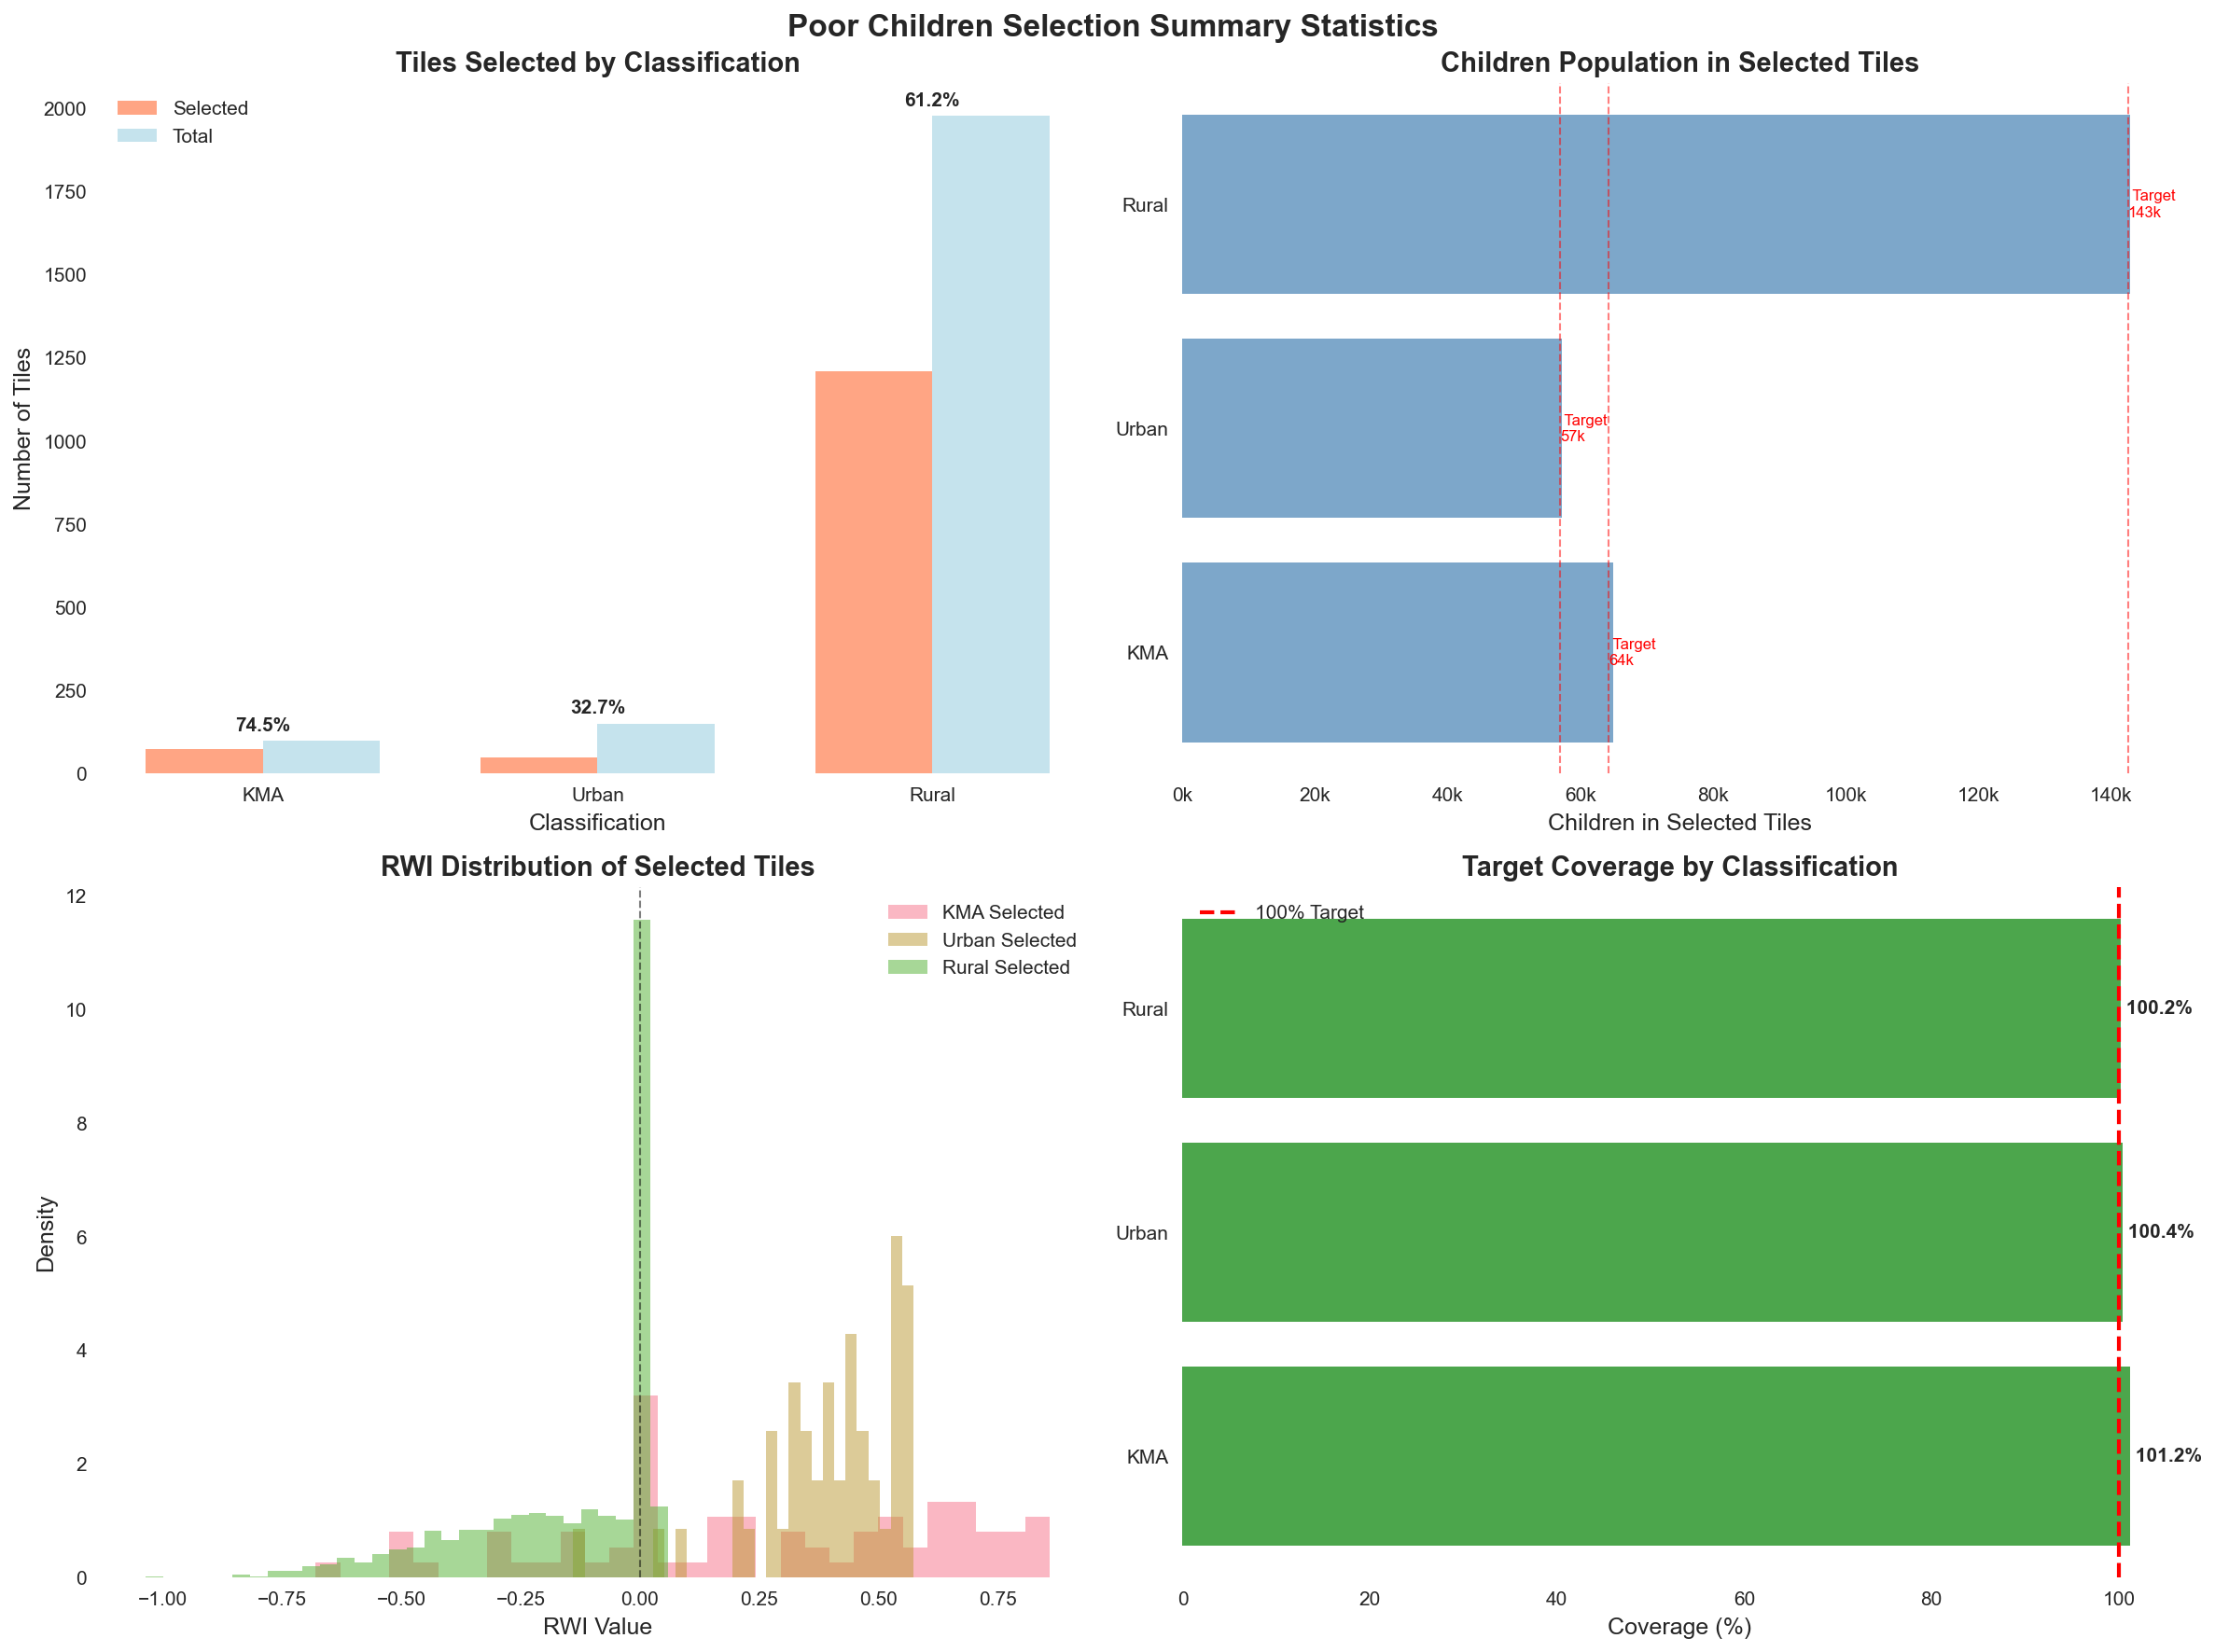

In [16]:
# Create summary statistics visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Tiles selected by classification
ax1 = axes[0, 0]
x = np.arange(len(df_summary))
width = 0.35
ax1.bar(x - width/2, df_summary['cells_selected'], width, label='Selected', color='coral', alpha=0.7)
ax1.bar(x + width/2, df_summary['total_tiles_in_classification'], width, label='Total', color='lightblue', alpha=0.7)
ax1.set_xlabel('Classification', fontsize=12)
ax1.set_ylabel('Number of Tiles', fontsize=12)
ax1.set_title('Tiles Selected by Classification', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_summary['classification'])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (idx, row) in enumerate(df_summary.iterrows()):
    pct = row['cells_selected'] / row['total_tiles_in_classification'] * 100
    ax1.text(i, row['total_tiles_in_classification'] + 20, f"{pct:.1f}%", 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Children coverage
ax2 = axes[0, 1]
ax2.barh(df_summary['classification'], df_summary['children_pop_covered'], color='steelblue', alpha=0.7)
for i, (idx, row) in enumerate(df_summary.iterrows()):
    ax2.axvline(x=row['target_poor_children'], color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax2.text(row['target_poor_children'], i, f" Target\n{row['target_poor_children']/1000:.0f}k", 
            ha='left', va='center', fontsize=8, color='red')
ax2.set_xlabel('Children in Selected Tiles', fontsize=12)
ax2.set_title('Children Population in Selected Tiles', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}k'))

# 3. RWI distribution
ax3 = axes[1, 0]
for classification in ['KMA', 'Urban', 'Rural']:
    classification_tiles = gdf_poorest[gdf_poorest['area_classification'] == classification]
    selected = classification_tiles[classification_tiles['is_poorest']]
    if len(selected) > 0:
        ax3.hist(selected['rwi'], bins=30, alpha=0.5, label=f'{classification} Selected', density=True)
ax3.set_xlabel('RWI Value', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.set_title('RWI Distribution of Selected Tiles', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)
ax3.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# 4. Coverage percentage
ax4 = axes[1, 1]
coverage_pct = df_summary['coverage_pct'].values
colors = ['green' if pct <= 105 else 'orange' if pct <= 110 else 'red' for pct in coverage_pct]
ax4.barh(df_summary['classification'], coverage_pct, color=colors, alpha=0.7)
ax4.axvline(x=100, color='red', linestyle='--', linewidth=2, label='100% Target')
ax4.set_xlabel('Coverage (%)', fontsize=12)
ax4.set_title('Target Coverage by Classification', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(df_summary.iterrows()):
    pct = row['coverage_pct']
    ax4.text(pct, i, f' {pct:.1f}%', va='center', fontsize=10, fontweight='bold')

plt.suptitle('Poor Children Selection Summary Statistics', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()


## Export Results


In [17]:
# Export the results
output_dir = "analysis_output"
os.makedirs(output_dir, exist_ok=True)

# Export poorest children cells GeoDataFrame
output_file = os.path.join(output_dir, f"poorest_children_cells.geojson")
try:
    gdf_poorest[gdf_poorest['is_poorest']].to_file(output_file, driver='GeoJSON')
    print(f"Exported poorest children cells to: {output_file}")
except PermissionError:
    print(f"Warning: Could not export to {output_file} (permission error)")

# Export all tiles with poorest flag
all_tiles_file = os.path.join(output_dir, f"all_tiles_with_poor_children_flag.parquet")
gdf_poorest.to_parquet(all_tiles_file)
print(f"Exported all tiles to: {all_tiles_file}")

# Export summary statistics
summary_file = os.path.join(output_dir, f"poor_children_selection_summary.csv")
df_summary.to_csv(summary_file, index=False)
print(f"Exported summary statistics to: {summary_file}")

# Export parish impact summary if available
if 'df_parish_impact' in locals():
    parish_impact_file = os.path.join(output_dir, f"poor_children_parish_impact_summary.csv")
    df_parish_impact.to_csv(parish_impact_file, index=False)
    print(f"Exported parish impact summary to: {parish_impact_file}")


Exported poorest children cells to: analysis_output/poorest_children_cells.geojson
Exported all tiles to: analysis_output/all_tiles_with_poor_children_flag.parquet
Exported summary statistics to: analysis_output/poor_children_selection_summary.csv
Exported parish impact summary to: analysis_output/poor_children_parish_impact_summary.csv
